In [2692]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os



#Sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score,f1_score, roc_curve, auc, accuracy_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
#from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.inspection import permutation_importance


#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

#Others
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2693]:
import xgboost
import sklearn

print("XGBoost version:", xgboost.__version__)
print("Scikit-learn version:", sklearn.__version__)

XGBoost version: 2.1.4
Scikit-learn version: 1.3.1


In [2694]:
# !pip uninstall -y scikit-learn
# !pip install scikit-learn==1.3.1

# Understanding Business Objective

**Objective**

Lending Club is a consumer finance company which specialises in lending various types of loans to customers. When the company receives a loan application, the company has to make a decision for loan approval based on the applicant’s profile. Two types of risks are associated with the bank’s decision:

1. If the applicant is likely to repay the loan, then not approving the loan results in a loss of business to the company

2. If the applicant is not likely to repay the loan, i.e. he/she is likely to default, then approving the loan may lead to a financial loss for the company

Lending loans to ‘risky’ applicants causes credit loss which is the amount of money lost by the lender when the borrower refuses to pay or absconds with the money owed. These sort of customers labelled as 'charged-off' are the 'defaulters'.

The objective is to identify the driving factors behind loan default, the patterns indicating risky loan applicants, hence reducing the credit loss and saving the Lending Club from any financial setback.




# Loading Data

**Data Loading**

Loading the data which contains information about past loan applicants and whether they defaulted or not

In [2695]:
df=pd.read_csv('df_train.csv')
df.head(10)

id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0   845462    1056663       8700         8700      8700.000000   36 months   
1  1038609    1268518      20450        20450     20400.000000   60 months   
2   531980     687698       7500         7500      7282.522099   60 months   
3   381607     410259       5000         5000      4000.000000   36 months   
4   447490     548228      10000        10000      9800.000000   36 months   
5   852879    1065011       1000         1000      1000.000000   36 months   
6   824890    1033648      20000        20000     17659.110270   60 months   
7  1030237    1259640       2500         2500      2500.000000   36 months   
8  1005153    1231833       3000         3000      3000.000000   36 months   
9   412148     464843       6000         6000      5108.118298   36 months   

  int_rate  installment grade sub_grade  ... num_tl_90g_dpd_24m  \
0   12.99%       293.10     C        C1  ...                NaN   
1   18.64%       526.45     E        E1  ...                NaN   
2   11.49%       164.91     B        B4  ...                NaN   
3   15.37%       174.24     D        D5  ...                NaN   
4   12.18%       333.00     B        B4  ...                NaN   
5   17.99%        36.15     E        E1  ...                NaN   
6   13.49%       460.10     C        C2  ...                NaN   
7   11.71%        82.69     B        B3  ...                NaN   
8   10.65%        97.72     B        B2  ...                NaN   
9   13.79%       204.46     C        C5  ...                NaN   

  num_tl_op_past_12m pct_tl_nvr_dlq  percent_bc_gt_75 pub_rec_bankruptcies  \
0                NaN            NaN               NaN                  0.0   
1                NaN            NaN               NaN                  0.0   
2                NaN            NaN               NaN                  0.0   
3                NaN            NaN               NaN                  0.0   
4                NaN            NaN               NaN                  0.0   
5                NaN            NaN               NaN                  0.0   
6                NaN            NaN               NaN                  0.0   
7                NaN            NaN               NaN                  0.0   
8                NaN            NaN               NaN                  0.0   
9                NaN            NaN               NaN                  0.0   

  tax_liens tot_hi_cred_lim total_bal_ex_mort total_bc_limit  \
0       0.0             NaN               NaN            NaN   
1       0.0             NaN               NaN            NaN   
2       0.0             NaN               NaN            NaN   
3       0.0             NaN               NaN            NaN   
4       0.0             NaN               NaN            NaN   
5       0.0             NaN               NaN            NaN   
6       0.0             NaN               NaN            NaN   
7       0.0             NaN               NaN            NaN   
8       0.0             NaN               NaN            NaN   
9       0.0             NaN               NaN            NaN   

  total_il_high_credit_limit  
0                        NaN  
1                        NaN  
2                        NaN  
3                        NaN  
4                        NaN  
5                        NaN  
6                        NaN  
7                        NaN  
8                        NaN  
9                        NaN  

[10 rows x 111 columns]

In [2696]:
df.drop_duplicates(subset=None, keep='first', inplace=True)

In [2697]:
df.shape

(30861, 111)

# Data Preparation & Handling





## Checking Target Column

In [2698]:
df['loan_status'].value_counts()

loan_status
Fully Paid     26329
Charged Off     4532
Name: count, dtype: int64

In [2699]:
x_train=df.drop(columns=['loan_status'])
y_train=df['loan_status']

In [2700]:
df=x_train.copy(deep=True)

## Removing columns with greater than 40% nulls

In [2701]:
null_pctg=df.isnull().sum()/len(df)*100
high_null_cols=null_pctg[null_pctg>40].index.tolist()
low_null_cols=null_pctg[null_pctg<=40].index.tolist()
print("Columns with null proportion > 40% : \n",high_null_cols)
print("Columns with null proportion <= 40% : \n",low_null_cols)

Columns with null proportion > 40% : 
 ['mths_since_last_delinq', 'mths_since_last_record', 'next_pymnt_d', 'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr

Handle missing Values - null column analysis

In [2702]:
null_pctg = df.isnull().sum() / len(df) * 100
null_pctg = null_pctg.sort_values(ascending=False)

print("Null percentages for each column:")
print(null_pctg)

print("\nColumns with null proportion > 40%:")
print(null_pctg[null_pctg > 40])

print("\nColumns with null proportion <= 40%:")
print(null_pctg[null_pctg <= 40])

Null percentages for each column:
total_il_high_credit_limit    100.0
dti_joint                     100.0
mo_sin_rcnt_tl                100.0
mo_sin_rcnt_rev_tl_op         100.0
mo_sin_old_rev_tl_op          100.0
                              ...  
total_acc                       0.0
revol_bal                       0.0
pub_rec                         0.0
open_acc                        0.0
acc_now_delinq                  0.0
Length: 110, dtype: float64

Columns with null proportion > 40%:
total_il_high_credit_limit        100.000000
dti_joint                         100.000000
mo_sin_rcnt_tl                    100.000000
mo_sin_rcnt_rev_tl_op             100.000000
mo_sin_old_rev_tl_op              100.000000
mo_sin_old_il_acct                100.000000
bc_util                           100.000000
bc_open_to_buy                    100.000000
avg_cur_bal                       100.000000
acc_open_past_24mths              100.000000
next_pymnt_d                      100.000000
mths_since

Deleting coluns with more than 40% nulls; adding a duplicate dataframe to facilitate reversal

In [2703]:
df_cleaned = df.drop(columns=high_null_cols)
print(f"Dropped {len(high_null_cols)} columns. New shape: {df_cleaned.shape}")
print("Dropped columns:", high_null_cols)
df = df_cleaned

Dropped 57 columns. New shape: (30861, 53)
Dropped columns: ['mths_since_last_delinq', 'mths_since_last_record', 'next_pymnt_d', 'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_p

In [2704]:
df_cleaned.shape

(30861, 53)

## Checking Datatypes - Checking Categorical columns

In [2705]:
object_cols=df.select_dtypes(include=['object'])
object_cols.nunique()

term                       2
int_rate                 369
grade                      7
sub_grade                 35
emp_title              22938
emp_length                11
home_ownership             5
verification_status        3
issue_d                   55
pymnt_plan                 1
url                    30861
desc                   20649
purpose                   14
title                  15830
zip_code                 810
addr_state                50
earliest_cr_line         515
revol_util              1070
initial_list_status        1
last_pymnt_d             101
last_credit_pull_d       104
application_type           1
dtype: int64

Checking if some columns like term, int_rate, emp_length marked as 'object' data type need to be converted to numerical data.

In [2706]:
df['term'].head(10)

0     36 months
1     60 months
2     60 months
3     36 months
4     36 months
5     36 months
6     60 months
7     36 months
8     36 months
9     36 months
Name: term, dtype: object

In [2707]:
df['term'].value_counts()

term
36 months    23289
60 months     7572
Name: count, dtype: int64

We see only 2 values are present for term indicating these are 2 predefined options offered by the Lending Club to borrowers. So we leave them as is for analysis purpose.

In [2708]:
df['int_rate'].head(10)

0    12.99%
1    18.64%
2    11.49%
3    15.37%
4    12.18%
5    17.99%
6    13.49%
7    11.71%
8    10.65%
9    13.79%
Name: int_rate, dtype: object

In [2709]:
df['int_rate'].value_counts()

int_rate
10.99%    745
11.49%    630
7.51%     623
13.49%    590
7.88%     576
         ... 
14.67%      1
18.72%      1
17.44%      1
20.40%      1
16.15%      1
Name: count, Length: 369, dtype: int64

In [2710]:
# converting int_rate to float
df['int_rate']=df['int_rate'].str.rstrip('%').astype('float')
print(df['int_rate'].dtype)
print(df['int_rate'].head(10))

float64
0    12.99
1    18.64
2    11.49
3    15.37
4    12.18
5    17.99
6    13.49
7    11.71
8    10.65
9    13.79
Name: int_rate, dtype: float64


In [2711]:
df['revol_util'].head(10)

0    38.60%
1    78.50%
2       43%
3    87.20%
4    72.10%
5    98.40%
6    73.20%
7    82.50%
8    17.30%
9    54.60%
Name: revol_util, dtype: object

In [2712]:
# converting revol_util to float
df['revol_util']=df['revol_util'].str.rstrip('%').astype(float)
print(df['revol_util'].dtype)
print(df['revol_util'].head(10))

float64
0    38.6
1    78.5
2    43.0
3    87.2
4    72.1
5    98.4
6    73.2
7    82.5
8    17.3
9    54.6
Name: revol_util, dtype: float64


In [2713]:
df['emp_length'].head(10)

0      6 years
1     < 1 year
2    10+ years
3      5 years
4      4 years
5       1 year
6      8 years
7      6 years
8      7 years
9      2 years
Name: emp_length, dtype: object

In [2714]:
df['emp_length'].value_counts()

emp_length
10+ years    6836
< 1 year     3604
2 years      3441
3 years      3214
4 years      2630
5 years      2582
1 year       2497
6 years      1735
7 years      1331
8 years      1177
9 years       971
Name: count, dtype: int64

Employee experience is showing discrete integers, but generally employee experience can be any numerical value. Converting emp_length to float.

In [2715]:
# converting emp_length to float
df['emp_length']=df['emp_length'].str.replace('years','')
df['emp_length']=df['emp_length'].str.replace('year','')
df['emp_length']=df['emp_length'].str.replace('+','')
df['emp_length']=df['emp_length'].str.replace('< 1','0.5')
df['emp_length']=df['emp_length'].astype('float')
print(df['emp_length'].dtype)
print(df['emp_length'].value_counts)

float64
<bound method IndexOpsMixin.value_counts of 0         6.0
1         0.5
2        10.0
3         5.0
4         4.0
         ... 
30856     0.5
30857     NaN
30858     8.0
30859     2.0
30860    10.0
Name: emp_length, Length: 30861, dtype: float64>


In [2716]:
df['emp_length'].head(15)

0      6.0
1      0.5
2     10.0
3      5.0
4      4.0
5      1.0
6      8.0
7      6.0
8      7.0
9      2.0
10    10.0
11    10.0
12     2.0
13     2.0
14     4.0
Name: emp_length, dtype: float64

There are some columns which have only 1 unique value. There are not suitable for analysis.

In [2717]:
# columns which have 1 unique value
cols_uniq1=df.columns[df.nunique()==1]
cols_uniq1

Index(['pymnt_plan', 'initial_list_status', 'out_prncp', 'out_prncp_inv',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt',
       'tax_liens'],
      dtype='object')

In [2718]:
for col in cols_uniq1:
  print(df[col].value_counts())
  print('--'*50)

pymnt_plan
n    30861
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
initial_list_status
f    30861
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
out_prncp
0.0    30861
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
out_prncp_inv
0.0    30861
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
collections_12_mths_ex_med
0.0    30814
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
policy_code
1    30861
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
application_type
INDIVIDUAL    30861
Name: count, dtype: int64
---------

In [2719]:
df.drop(columns=cols_uniq1,inplace=True)
df.shape

(30861, 42)

In [2720]:
print('Unique value counts of below columns-')
for col in ['title','purpose','desc','addr_state']:
  print(col,' -- ',df[col].nunique())


Unique value counts of below columns-
title  --  15830
purpose  --  14
desc  --  20649
addr_state  --  50


Columns like url, id, member_id, do not carry much insightful information to help in analysis.

Also, since we have addr_state which is the state provided by borrower, we do not need zip codes. addr_state indicates the place of the borrower.

Columns like title and desc are most probably handwritten by the borrowers while filling up the loan application, so it is much varied. The purpose column is a much better and compact summary having 14 unique categories into which the reason for taking loan can be mapped may be because the options were selected from dropdown list. So we can drop title and desc and keep purpose.

In [2721]:
# dropping columns not having significance in analysis
df.drop(columns=['url','desc','zip_code','title','id','member_id'],inplace=True)
df.shape

(30861, 36)

Now that redundant columsns are removed and the right data types are assigned to the right columns, we can seggregate columns as numerical and categorical based on data types and then proceed to impute missing values accordingly.

## Segregating columns based on datatypes

In [2722]:
numcols=[]
catcols=[]
for col in df.columns:
  #print(col,"-->",df[col].dtype)
  if df[col].dtype=='object':
    catcols.append(col)
  elif df[col].dtype in ['int64','float64']:
    numcols.append(col)
print("categorical columns :",catcols)
print("numerical columns :",numcols)

categorical columns : ['term', 'grade', 'sub_grade', 'emp_title', 'home_ownership', 'verification_status', 'issue_d', 'purpose', 'addr_state', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d']
numerical columns : ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'pub_rec_bankruptcies']


## Imputing nulls in Categorical Columns

checking null values in categorical columns

In [2723]:
# checking null values in categorical columns

for col in catcols:
  print(col,"--->  ",df[col].isnull().sum()/len(df)*100,"%")

term --->   0.0 %
grade --->   0.0 %
sub_grade --->   0.0 %
emp_title --->   6.286251255630083 %
home_ownership --->   0.0 %
verification_status --->   0.0 %
issue_d --->   0.0 %
purpose --->   0.0 %
addr_state --->   0.0 %
earliest_cr_line --->   0.0 %
last_pymnt_d --->   0.19117980622792521 %
last_credit_pull_d --->   0.0064806713975567865 %


Checking emp_title column

In [2724]:
emptitles=df['emp_title'].value_counts()
print(emptitles)

emp_title
US Army                                  106
Bank of America                           89
IBM                                       53
AT&T                                      50
Kaiser Permanente                         47
                                        ... 
Siltanen & Partners                        1
Transamerica Insurance and Investment      1
Howard Rice Law Firm                       1
pss                                        1
glendalle adventist medical center         1
Name: count, Length: 22938, dtype: int64


In [2725]:
low_freq_emptitles=emptitles[emptitles<20]
print("Proportion of emp_titles below frequency 20 is",round(len(low_freq_emptitles)/len(emptitles)*100,2),"%.")
print(low_freq_emptitles)

Proportion of emp_titles below frequency 20 is 99.82 %.
emp_title
walmart                                  19
Citigroup                                19
Department of Veterans Affairs           19
Department of Homeland Security          18
Merrill Lynch                            18
                                         ..
Siltanen & Partners                       1
Transamerica Insurance and Investment     1
Howard Rice Law Firm                      1
pss                                       1
glendalle adventist medical center        1
Name: count, Length: 22896, dtype: int64


In [2726]:
low_freq_emptitles=emptitles[emptitles<50]
print("Proportion of emp_titles below frequency 50 is",round(len(low_freq_emptitles)/len(emptitles)*100,2),"%.")
print(low_freq_emptitles)

Proportion of emp_titles below frequency 50 is 99.98 %.
emp_title
Kaiser Permanente                        47
Wells Fargo                              41
US Air Force                             39
UPS                                      38
USAF                                     38
                                         ..
Siltanen & Partners                       1
Transamerica Insurance and Investment     1
Howard Rice Law Firm                      1
pss                                       1
glendalle adventist medical center        1
Name: count, Length: 22934, dtype: int64


In [2727]:
high_freq_emptitles=emptitles[emptitles>=50]
print("Proportion of emp_titles >=50 is",round(len(high_freq_emptitles)/len(emptitles)*100,2),"%.")
print(high_freq_emptitles)

Proportion of emp_titles >=50 is 0.02 %.
emp_title
US Army            106
Bank of America     89
IBM                 53
AT&T                50
Name: count, dtype: int64


In [2728]:
emptitles.describe()

count    22938.000000
mean         1.260834
std          1.798892
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        106.000000
Name: count, dtype: float64

There is a high imbalance and diversity in frequency of the employee titles.

To avoid biasness, discrimination and partiality towards a certain profession of people while providing loans, we will fill the missing values with 'unknown' tag and not mode.

In [2729]:
df['emp_title']=df['emp_title'].fillna('Unknown')

Since presence of numerous emptitle categories is cluttering the visuals and hindering analysis, we will club up the less frequent emptitles (frequency<20) in 'Other' category in later steps when we do the analysis.

Checking missing values of column last_payment_d

In [2730]:
blank_last_paydates=df[df['last_pymnt_d'].isnull()]
print(len(blank_last_paydates))

59


In [2731]:
blank_last_paydates_status = y_train.loc[blank_last_paydates.index]
blank_last_paydates_status.value_counts()

loan_status
Charged Off    59
Name: count, dtype: int64

The missing values of last_pymnt_d indicate that all the borrowers who have last_payment_d missing in their records were charged off. So we will impute missing values with value 'Not paid'

In [2732]:
# imputing last_pymnt_d with 'Not paid'
df['last_pymnt_d']=df['last_pymnt_d'].fillna('Not paid')

In [2733]:
# imputing last_credit_pull_d with mode
credit_pull_mode=df['last_credit_pull_d'].mode()[0]
df['last_credit_pull_d']=df['last_credit_pull_d'].fillna(credit_pull_mode)

In [2734]:
for col in catcols:
  print(col,"--->  ",df[col].isnull().sum()/len(df)*100,"%")

term --->   0.0 %
grade --->   0.0 %
sub_grade --->   0.0 %
emp_title --->   0.0 %
home_ownership --->   0.0 %
verification_status --->   0.0 %
issue_d --->   0.0 %
purpose --->   0.0 %
addr_state --->   0.0 %
earliest_cr_line --->   0.0 %
last_pymnt_d --->   0.0 %
last_credit_pull_d --->   0.0 %


## Imputing nulls in numerical columns

In [2735]:
for col in numcols:
  print(col,"--->  ",df[col].isnull().sum()/len(df)*100,"%")

loan_amnt --->   0.0 %
funded_amnt --->   0.0 %
funded_amnt_inv --->   0.0 %
int_rate --->   0.0 %
installment --->   0.0 %
emp_length --->   2.7316029940701854 %
annual_inc --->   0.0 %
dti --->   0.0 %
delinq_2yrs --->   0.0 %
inq_last_6mths --->   0.0 %
open_acc --->   0.0 %
pub_rec --->   0.0 %
revol_bal --->   0.0 %
revol_util --->   0.12313275655357896 %
total_acc --->   0.0 %
total_pymnt --->   0.0 %
total_pymnt_inv --->   0.0 %
total_rec_prncp --->   0.0 %
total_rec_int --->   0.0 %
total_rec_late_fee --->   0.0 %
recoveries --->   0.0 %
collection_recovery_fee --->   0.0 %
last_pymnt_amnt --->   0.0 %
pub_rec_bankruptcies --->   1.8243089984122354 %


In [2736]:
df['pub_rec_bankruptcies'].value_counts()

pub_rec_bankruptcies
0.0    28969
1.0     1324
2.0        5
Name: count, dtype: int64

Null values of pub_rec_bankruptcies simply mean person was not bankrupted. So imputing with 0

In [2737]:
df['pub_rec_bankruptcies']=df['pub_rec_bankruptcies'].fillna(0)

In [2738]:
# imputing columns 'emp_length', 'revol_util' with median
medians = {col: df[col].median() for col in ['emp_length', 'revol_util']}
for col in ['emp_length','revol_util']:
  df[col]=df[col].fillna(df[col].median())

In [2739]:
# checking null values in numerical columns

for col in numcols:
  print(col,"--->  ",df[col].isnull().sum()/len(df)*100,"%")

loan_amnt --->   0.0 %
funded_amnt --->   0.0 %
funded_amnt_inv --->   0.0 %
int_rate --->   0.0 %
installment --->   0.0 %
emp_length --->   0.0 %
annual_inc --->   0.0 %
dti --->   0.0 %
delinq_2yrs --->   0.0 %
inq_last_6mths --->   0.0 %
open_acc --->   0.0 %
pub_rec --->   0.0 %
revol_bal --->   0.0 %
revol_util --->   0.0 %
total_acc --->   0.0 %
total_pymnt --->   0.0 %
total_pymnt_inv --->   0.0 %
total_rec_prncp --->   0.0 %
total_rec_int --->   0.0 %
total_rec_late_fee --->   0.0 %
recoveries --->   0.0 %
collection_recovery_fee --->   0.0 %
last_pymnt_amnt --->   0.0 %
pub_rec_bankruptcies --->   0.0 %


Sanity test on the date columns

In [2740]:
for col in ['earliest_cr_line', 'issue_d','last_credit_pull_d']:
  print(col)
  dates = pd.to_datetime(df[col], format='%b-%y')
  lowest_date = dates.min()
  highest_date = dates.max()

  # Count values with years greater than 2025
  count_future_years = (dates.dt.year > 2025).sum()

  print(f"Column: {col}")
  print(f"  Lowest Date: {lowest_date}")
  print(f"  Highest Date: {highest_date}")
  print(f"  Count of dates with year greater than 2024: {count_future_years}")
  print('--'*50)


earliest_cr_line
Column: earliest_cr_line
  Lowest Date: 1969-02-01 00:00:00
  Highest Date: 2068-12-01 00:00:00
  Count of dates with year greater than 2024: 68
----------------------------------------------------------------------------------------------------
issue_d
Column: issue_d
  Lowest Date: 2007-06-01 00:00:00
  Highest Date: 2011-12-01 00:00:00
  Count of dates with year greater than 2024: 0
----------------------------------------------------------------------------------------------------
last_credit_pull_d
Column: last_credit_pull_d
  Lowest Date: 2007-05-01 00:00:00
  Highest Date: 2016-05-01 00:00:00
  Count of dates with year greater than 2024: 0
----------------------------------------------------------------------------------------------------


In [2741]:
df['issue_dd'] = pd.to_datetime(df['issue_d'], format='%b-%y')

def adjust_earliest_cr_line(row):
    month, year = row['earliest_cr_line'].split('-')
    year = int(year)

    # Initialize the adjusted year
    adjusted_year = None

    # Check the year and adjust accordingly
    if year > 11:
        adjusted_year = year + 1900  # Add 1900 for years greater than 11
    else:
        adjusted_year = year + 2000  # Add 2000 for years less than or equal to 11

        # Create a temporary date for comparison
        temp_date = pd.to_datetime(f"{month}-{adjusted_year}", format='%b-%Y', errors='coerce')

        # Compare with issue_d
        if temp_date > row['issue_dd']:
            adjusted_year = year + 1900  # Adjust to 1900s if it exceeds issue_d

    return f"{month}-{adjusted_year}"

# Apply the function to create a new adjusted column
df['earliest_cr_line'] = df.apply(adjust_earliest_cr_line, axis=1)

# Convert to datetime
#df['adjusted_earliest_cr_line'] = pd.to_datetime(df['adjusted_earliest_cr_line'], format='%b-%Y', errors='coerce')

#print(df.loc[[1576, 1764, 3274, 3349], ['earliest_cr_line','issue_d']])

# Univariate Analysis of Numerical Columns

**Purpose** - To understand the nature of distributions of the columns, to know the overall nature of the dataset.

In [2742]:
plt.style.use('default')

In [2743]:
# Split the numcols list into two halves
mid_index = len(numcols) // 2
first_half = numcols[:mid_index]
second_half = numcols[mid_index:]

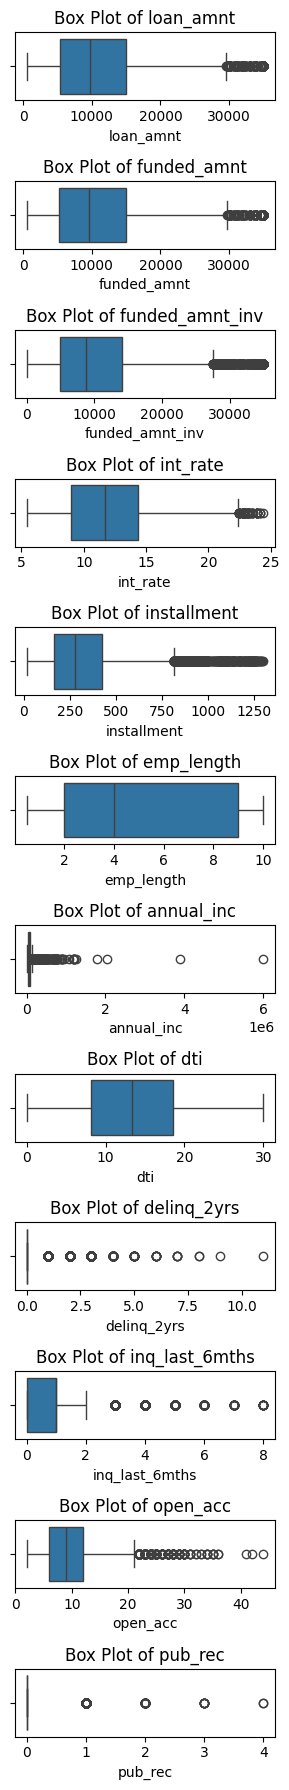

In [2744]:
# Create a subplot for the first half of the columns
fig, axes = plt.subplots(len(first_half), 1, figsize=(3, 1.5 * len(first_half)))
for i, col in enumerate(first_half):
    sns.boxplot(data=df, x=col, ax=axes[i])
    axes[i].set_title(f'Box Plot of {col}')

plt.tight_layout()
plt.show()



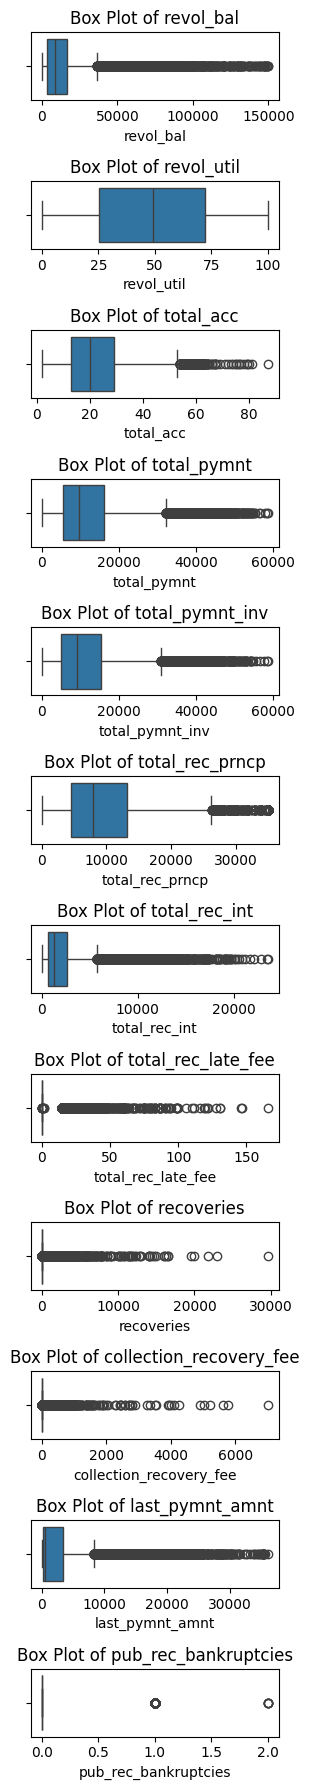

In [2745]:
# Create a subplot for the second half of the columns
fig, axes = plt.subplots(len(second_half), 1, figsize=(3, 1.5 * len(second_half)))
for i, col in enumerate(second_half):
    sns.boxplot(data=df, x=col, ax=axes[i])
    axes[i].set_title(f'Box Plot of {col}')

plt.tight_layout()
plt.show()

In [2746]:
df.describe()

loan_amnt   funded_amnt  funded_amnt_inv      int_rate  \
count  30861.000000  30861.000000     30861.000000  30861.000000   
mean   11078.651048  10811.790772     10252.570888     11.929982   
min      500.000000    500.000000         0.000000      5.420000   
25%     5300.000000   5200.000000      5000.000000      8.940000   
50%     9800.000000   9600.000000      8775.000000     11.710000   
75%    15000.000000  15000.000000     14025.000000     14.350000   
max    35000.000000  35000.000000     35000.000000     24.400000   
std     7380.102468   7121.657930      7059.365612      3.698637   

        installment    emp_length    annual_inc           dti   delinq_2yrs  \
count  30861.000000  30861.000000  3.086100e+04  30861.000000  30861.000000   
mean     323.265732      4.985807  6.886991e+04     13.271921      0.149379   
min       15.690000      0.500000  4.000000e+03      0.000000      0.000000   
25%      165.820000      2.000000  4.000000e+04      8.140000      0.000000   
50%      278.480000      4.000000  5.897700e+04     13.360000      0.000000   
75%      426.470000      9.000000  8.200800e+04     18.530000      0.000000   
max     1302.690000     10.000000  6.000000e+06     29.990000     11.000000   
std      209.482244      3.435890  6.640008e+04      6.668448      0.499428   

       inq_last_6mths  ...   total_pymnt  total_pymnt_inv  total_rec_prncp  \
count    30861.000000  ...  30861.000000     30861.000000     30861.000000   
mean         0.871326  ...  11882.605240     11292.459430      9664.131088   
min          0.000000  ...      0.000000         0.000000         0.000000   
25%          0.000000  ...   5508.133452      5017.910000      4500.000000   
50%          1.000000  ...   9705.537611      9095.390000      8000.000000   
75%          1.000000  ...  16129.720010     15367.070000     13200.000000   
max          8.000000  ...  58563.679930     58563.680000     35000.020000   
std          1.072336  ...   8834.014109      8727.810269      7044.095116   

       total_rec_int  total_rec_late_fee    recoveries  \
count   30861.000000        30861.000000  30861.000000   
mean     2119.875557            1.364129     97.234539   
min         0.000000            0.000000      0.000000   
25%       643.870000            0.000000      0.000000   
50%      1301.540000            0.000000      0.000000   
75%      2672.810000            0.000000      0.000000   
max     23563.680000          165.690000  29623.350000   
std      2384.330250            7.144447    684.800836   

       collection_recovery_fee  last_pymnt_amnt  pub_rec_bankruptcies  \
count             30861.000000     30861.000000          30861.000000   
mean                 12.230619      2758.633864              0.043226   
min                   0.000000         0.000000              0.000000   
25%                   0.000000       217.460000              0.000000   
50%                   0.000000       567.290000              0.000000   
75%                   0.000000      3457.660000              0.000000   
max                7002.190000     36115.200000              2.000000   
std                 139.573809      4527.138690              0.204164   

                            issue_dd  
count                          30861  
mean   2010-10-25 08:55:51.181102336  
min              2007-06-01 00:00:00  
25%              2010-05-01 00:00:00  
50%              2011-01-01 00:00:00  
75%              2011-08-01 00:00:00  
max              2011-12-01 00:00:00  
std                              NaN  

[8 rows x 25 columns]

Key Insights:


1. Columns loan_amt, funded_amnt, funded_amnt_inv are right skewed. Outliers indicate that seldom, applicants request exorbitant loans crossing the highest value in the range (as per uppermost whisker of the box plot) at \$30,000.

  Median of loan amount demanded by borrowers= \$9800

  Median of loan amount funded= \$9600

  Median of loan amount funded by investors= \$8775

  The funded amounts are never higher than the loan amount. Also, not all loans are funded by investors as per the minimum value of funded_amnt_inv.

  Out of the 3, we can consider that funded_amnt and funded_amnt_inv depends on loan_amnt.


2. Median interest rate is 11.7% , 75% of values are under 14.38% although as per outliers, sometimes there are extremely high interest rates crossing 22%.


3. Installments owed by borrowers have median value of \$278 but many outliers are present beyond $800.


4. Column emp_length have median at 4 years and maximum is at 10 years. Although there are many senior applicants requesting loans, more applicants are mainly in the junior or mid level of employment experience.


5. Column annual_inc is hard to interpret, so we will bucket the values for better understanding in subsequent steps.


6. Column dti ( ratio calculated using the borrower’s total monthly debt payments on the total debt obligations) follows nearly normal distribution. Median is near 13.36.


7. Column delinq_2yrs  are 0 in majority, with a few outliers indicating those who have 30+ days past-due incidences of delinquency for past 2 years. Majority do not have any such case.


8. Column inq_last_6_mnth imply that not many inquiries are made over last 6 months.


9. Column open_acc which denotes number of open credit lines of a borrower, is right skewed having median about 11 with few outliers.


10. Column pub_rec indicates almost all people have clean public records but very few outlier people have derogatory public records.


11. Columns revol_balance denote the balance the borrowers owe on the credit accounts and revol_util denote the ratio of the credit used by the borrower relative to the overall available credit. Though borrowers use the credits judiciously, there are many outliers in box plot of revol_balance indicating that many borrowers are using the credits a lot and owing high balance. This has also pushed up the median of revol_util to nearly 50%. This needs to be treated with caution.



12. Columns total_acc (total number of credit files in a borrower's file), total_pymnt, total_pymnt_inv, total_rec_int, total_rec_prncp (the payments recieved from the borrowers) have outliers indicating that people are highly reliant on the Lending Club and heavily using their loan provision services. But outliers in total_pymnt_late_fee column indicate that many people were fined for paying late.


13. Columns recoveries and collection_recovery_fee have outliers indicating that many borrowers charged off due to which they were handed over to collection agencies for recovering the amount and very high recovery fees were collected from them


14. Column last_pymnt_amnt has outliers implying high amounts paid by borrowers.


15. Column pub_rec_bankruptcies have majority 0 values indicating majority people have no such record of bankruptcy.


16. credit_score is left skewed showing outliers having too less credit scores. This needs to be treated with caution.


17. credit_histrory_length is right skewed showing outliers having too long credit history lengths.


In [2747]:
df['pub_rec_bankruptcies'].value_counts()

pub_rec_bankruptcies
0.0    29532
1.0     1324
2.0        5
Name: count, dtype: int64

In [2748]:
df['pub_rec'].value_counts()

pub_rec
0    29198
1     1616
2       38
3        7
4        2
Name: count, dtype: int64

In [2749]:
df['inq_last_6mths'].value_counts()

inq_last_6mths
0    14959
1     8558
2     4513
3     2374
4      247
5      117
6       53
7       27
8       13
Name: count, dtype: int64

In [2750]:
df['delinq_2yrs'].value_counts()

delinq_2yrs
0     27453
1      2612
2       542
3       168
4        51
5        20
6         7
7         4
8         2
9         1
11        1
Name: count, dtype: int64

For the above columns, it is possible to have extreme values. Although these are outliers but such kind of candidates are possible.

# Univariate Analysis of Categorical Columns

**Purpose** - To understand the nature and frequency of values in the columns, to know the overall nature of the dataset.

As decided earlier, we have to segment annual_inc into some categories for better visualization. Furhermore, lets also segment the other continuous numerical values like loan_amnt, int_rate

In [2751]:
# need to segment annual income and then plot graphs
# df['annual_inc_category']=pd.qcut(df['annual_inc'],q=5,labels=['VL', 'L', 'M', 'H', 'VH'])
quantiles = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
labels = ['VL', 'L', 'M', 'H', 'VH']
bucket_ranges = {}
store_bucket_ranges = {}
columns_to_categorize = ['annual_inc', 'loan_amnt', 'int_rate']
for col in columns_to_categorize:
    col2=col+"_category"
    df[col2] = pd.qcut(df[col], q=quantiles, labels=labels)
    bin_edges = pd.qcut(df[col], q=quantiles, retbins=True)[1]
    store_bucket_ranges[col] = bin_edges
    # Create a dictionary to hold the ranges for each bucket
    bucket_ranges = {}

    # Create ranges for each bucket
    for i in range(len(bin_edges) - 1):
        bucket_ranges[labels[i]] = (bin_edges[i], bin_edges[i + 1])

    # Display the ranges for each bucket
    print("column:",col2)
    for label, range_ in bucket_ranges.items():
        print(f'Range for {label}: {range_[0]:.2f} to {range_[1]:.2f}')
    print("--"*50)

column: annual_inc_category
Range for VL: 4000.00 to 37000.00
Range for L: 37000.00 to 50004.00
Range for M: 50004.00 to 65004.00
Range for H: 65004.00 to 90000.00
Range for VH: 90000.00 to 6000000.00
----------------------------------------------------------------------------------------------------
column: loan_amnt_category
Range for VL: 500.00 to 5000.00
Range for L: 5000.00 to 7800.00
Range for M: 7800.00 to 11200.00
Range for H: 11200.00 to 16000.00
Range for VH: 16000.00 to 35000.00
----------------------------------------------------------------------------------------------------
column: int_rate_category
Range for VL: 5.42 to 7.90
Range for L: 7.90 to 10.99
Range for M: 10.99 to 12.73
Range for H: 12.73 to 15.21
Range for VH: 15.21 to 24.40
----------------------------------------------------------------------------------------------------


In [2752]:
store_bucket_ranges

{'annual_inc': array([4.0000e+03, 3.7000e+04, 5.0004e+04, 6.5004e+04, 9.0000e+04,
        6.0000e+06]),
 'loan_amnt': array([  500.,  5000.,  7800., 11200., 16000., 35000.]),
 'int_rate': array([ 5.42,  7.9 , 10.99, 12.73, 15.21, 24.4 ])}

We want to know on what basis are the loan grades A to E assigned. Generally Loan grading is a system that lenders use to evaluate the risk of a loan and assign it a grade or rating. Let us check basis of what factors this grading is assigned.

In [2753]:
import scipy.stats as stats

# List of columns to test
columns_to_test = ['int_rate', 'dti', 'revol_util', 'recoveries', 'total_rec_late_fee', 'collection_recovery_fee']

# Loop through each column and perform ANOVA
for column in columns_to_test:
    grades = df['grade'].unique()
    groups = [df[df['grade'] == grade][column] for grade in grades]
    f_statistic, p_value = stats.f_oneway(*groups)
    print(f"ANOVA results for {column}: F-statistic = {f_statistic}, p-value = {p_value}")


ANOVA results for int_rate: F-statistic = 60340.62350901359, p-value = 0.0
ANOVA results for dti: F-statistic = 63.84399599932956, p-value = 3.8743391476873347e-79
ANOVA results for revol_util: F-statistic = 1428.193364829037, p-value = 0.0
ANOVA results for recoveries: F-statistic = 92.21968237689082, p-value = 3.0465043817330386e-115
ANOVA results for total_rec_late_fee: F-statistic = 53.7793846187424, p-value = 2.5495490374430397e-66
ANOVA results for collection_recovery_fee: F-statistic = 31.532048198022952, p-value = 4.983476652567353e-38


The ANOVA tests revealed that interest rate is a critical indicator that strongly influence the assigned loan grades associated with varying risk levels.

In [2754]:
objectcols=df.select_dtypes(include=['object','category'])
objectcols.nunique()

term                       2
grade                      7
sub_grade                 35
emp_title              22939
home_ownership             5
verification_status        3
issue_d                   55
purpose                   14
addr_state                50
earliest_cr_line         515
last_pymnt_d             102
last_credit_pull_d       104
annual_inc_category        5
loan_amnt_category         5
int_rate_category          5
dtype: int64

Due to high number of values in above columns , first we will only consider columns having <=60 values.

In [2755]:
unique_counts = objectcols.nunique()
filtered_columns = unique_counts[unique_counts <= 60].index.tolist()
#filtered_columns.remove('loan_status')
num_cols = len(filtered_columns)

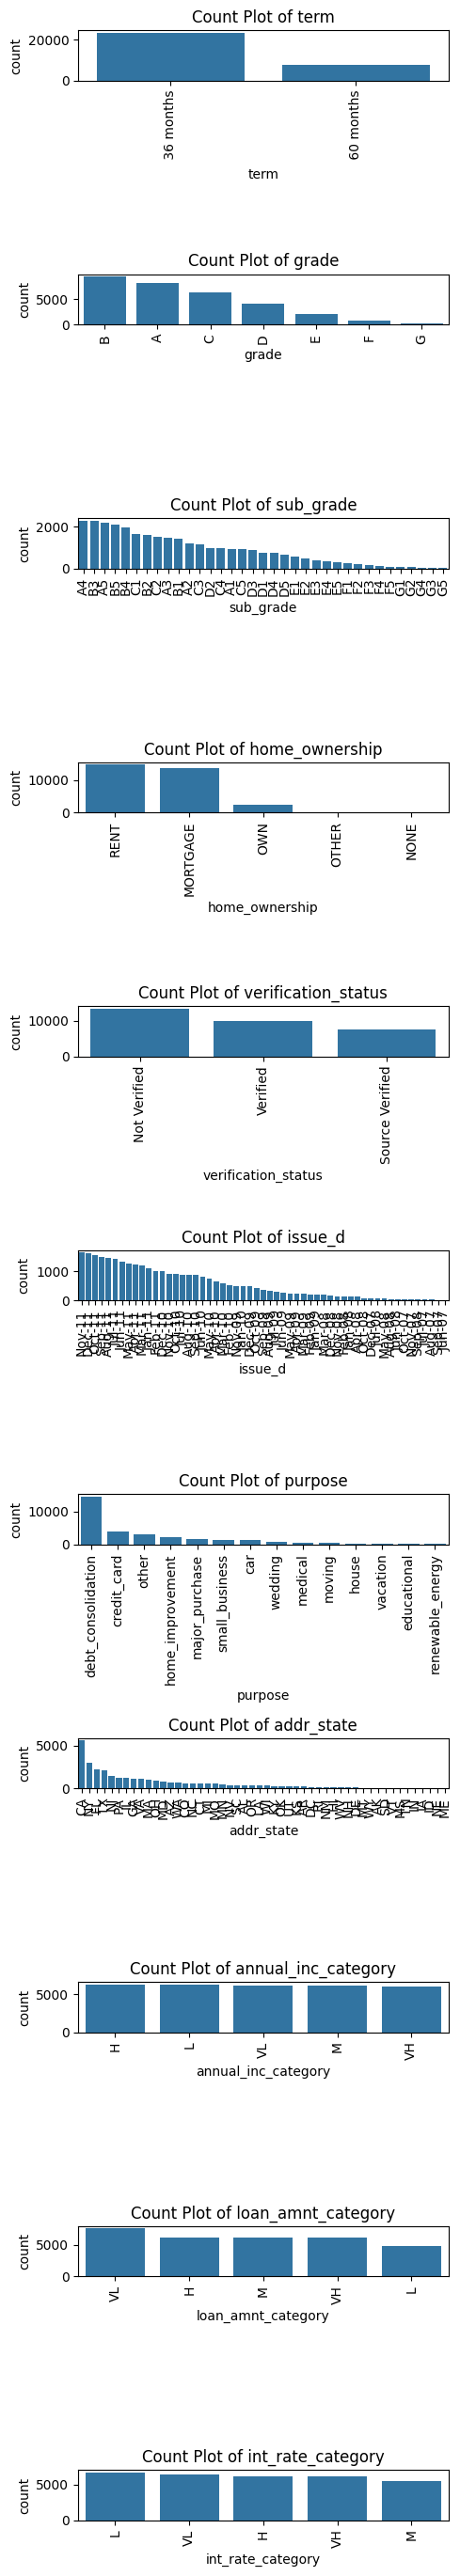

In [2756]:

fig, axes = plt.subplots(num_cols, 1, figsize=(5, 2.5 * num_cols))
for i, col in enumerate(filtered_columns):
    sns.countplot(data=df, x=col, ax=axes[i],order=df[col].value_counts().sort_values(ascending=False).index)
    axes[i].set_title(f'Count Plot of {col}')
    axes[i].tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

Key Insights:

1. Most applicants apply for short term loans (36 months)


2. B grade of loan systems prefered to A grade although not much can be said about sub_grades.


3. Most loan applicants have rented or mortaged homes.


4. Most applicants status is not verified.



5. If we notice the pattern of issuing loans in each year, we notice that more loans generally get issued near the end of the years generally October to December.



6. Mostly applicants apply for debt_consolidation loans.


7. Applicants from CA state is quite dominant followed by NewYork.


8. Applicants from all income groups are present and nothing much can be said from this.



Since loan subgrades do not capture much useful insights like loan grades already capture, we can drop loan subgrades as this will not help much in the analysis.

In [2757]:
df.drop(columns=['sub_grade'],inplace=True)

last_cr_pull_d - indicates the most recent month Lending Club pulled credit for this loan.

earliest_cr_line - The month the borrower's earliest reported credit line was opened.

Logically the most recent month the club pulled his credit has not got much to do in deciding between paid or charged off applicants.
Hence dropping.

In [2758]:
# dropping redundant columns
df.drop(columns=['last_credit_pull_d'],inplace=True)

In [2759]:
df['Last payment made']=np.where(df['last_pymnt_d']=='Not paid','Not paid','Paid')
df['Last payment made'].value_counts()

Last payment made
Paid        30802
Not paid       59
Name: count, dtype: int64

In [2760]:
# dropping last_pymnt_d column
df.drop(columns=['last_pymnt_d'],inplace=True)

For emp_title we can consolidate the designations over fewer categories by analysing the distribution.

Checking emp_title values frequencies

Categorizing emp_titles and clubbing the varied infrequent employee titles under 'Other' category.

In [2761]:
# bringing the common synonnymous titles under single title for reducing redundancy

df['emp_title'] = df['emp_title'].replace({'walmart': 'Walmart','WALMART': 'Walmart','WalMart': 'Walmart'})
df['emp_title'] = df['emp_title'].replace({'self': 'Self'})
df['emp_title'] = df['emp_title'].replace({'U.S. Army': 'US Army','US ARMY':'US Army','us army':'US Army','United States Army':'US Army'})
df['emp_title'] = df['emp_title'].replace({'United States Postal Service':'US Postal Service','USPS':'US Postal Service'})
df['emp_title'] = df['emp_title'].replace({'USAF':'US Air Force','United States Air Force':'US Air Force'})
df['emp_title'] = df['emp_title'].replace({'UPS':'United Parcel Service'})
df['emp_title'] = df['emp_title'].replace({'JPMorgan Chase':'JP Morgan Chase'})

In [2762]:
# categorizing infrequent emp titles under Other category

emptitles=df['emp_title'].value_counts()
mapper={title:title if count>=20 else 'Other' for title,count in emptitles.items()}
print(mapper)

{'Unknown': 'Unknown', 'US Army': 'US Army', 'US Air Force': 'US Air Force', 'Bank of America': 'Bank of America', 'US Postal Service': 'US Postal Service', 'Walmart': 'Walmart', 'JP Morgan Chase': 'JP Morgan Chase', 'United Parcel Service': 'United Parcel Service', 'IBM': 'IBM', 'Self': 'Self', 'AT&T': 'AT&T', 'Kaiser Permanente': 'Kaiser Permanente', 'Wells Fargo': 'Wells Fargo', 'Self Employed': 'Self Employed', 'Walgreens': 'Walgreens', 'Lockheed Martin': 'Lockheed Martin', 'Verizon Wireless': 'Verizon Wireless', 'State of California': 'State of California', 'US Navy': 'US Navy', 'Department of Defense': 'Department of Defense', 'Verizon': 'Verizon', 'Target': 'Target', 'Fidelity Investments': 'Fidelity Investments', 'Accenture': 'Accenture', 'Northrop Grumman': 'Northrop Grumman', 'Booz Allen Hamilton': 'Booz Allen Hamilton', 'Comcast': 'Comcast', 'Home Depot': 'Home Depot', 'Social Security Administration': 'Social Security Administration', 'Wells Fargo Bank': 'Wells Fargo Bank',

In [2763]:
df['emp_title']=df['emp_title'].map(mapper)
df['emp_title'].value_counts()

emp_title
Other                             27512
Unknown                            1940
US Army                             222
US Air Force                        107
Bank of America                      89
US Postal Service                    71
Walmart                              63
JP Morgan Chase                      62
United Parcel Service                61
IBM                                  53
Self                                 52
AT&T                                 50
Kaiser Permanente                    47
Wells Fargo                          41
Self Employed                        36
Walgreens                            33
Verizon Wireless                     32
Lockheed Martin                      32
State of California                  29
US Navy                              28
Department of Defense                27
Verizon                              26
Fidelity Investments                 25
Accenture                            25
Target                               25
Northrop Grumman                     24
Booz Allen Hamilton                  23
Comcast                              22
Wells Fargo Bank                     21
Best Buy                             21
Social Security Administration       21
Home Depot                           21
General Electric                     20
Name: count, dtype: int64

In [2764]:
df['emp_title'].nunique()

33

The emp_title categories reduced to 33 unique categories. Most people are clubbed in 'Others' category. Apart from the 'Other' and 'Unknown', the number of people in US Army and US Air Force have higher frequencies than the rest.

In [2765]:
valid_emptitles = df['emp_title'].unique().tolist()

In [2766]:
x_train=df.copy(deep=True)
df.shape, x_train.shape

((30861, 38), (30861, 38))

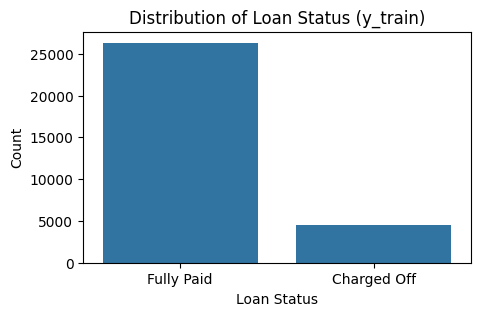

In [2767]:
plt.figure(figsize=(5, 3))
sns.countplot(x=y_train)  # Use y_train directly for countplot
plt.title('Distribution of Loan Status (y_train)')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.show()

# Bivariate Analysis of loan_status with Numerical Columns

**Purpose** - To check how numerical columns influence the target column loan_status

For eda and visualization purpose we are having the features and target variables together. The training data is already preserved in x_train.

In [2768]:
df['loan_status'] = y_train

In [2769]:
mid_index = len(numcols) // 2
first_half = numcols[:mid_index]
second_half = numcols[mid_index:]

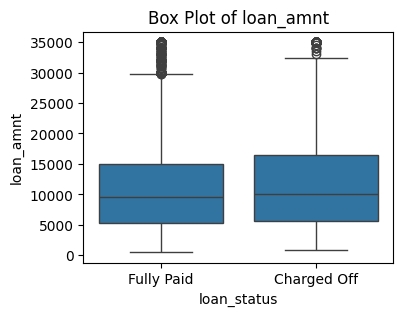

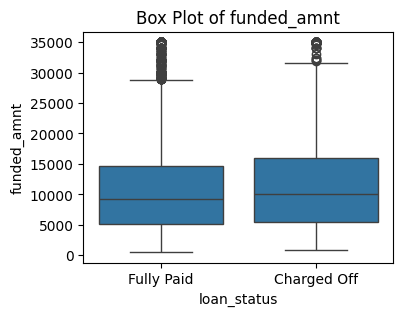

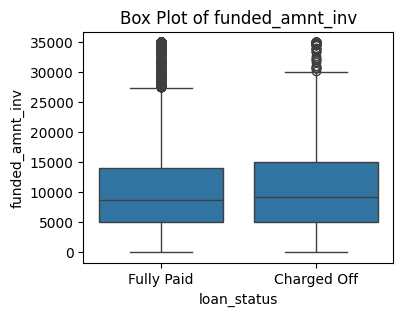

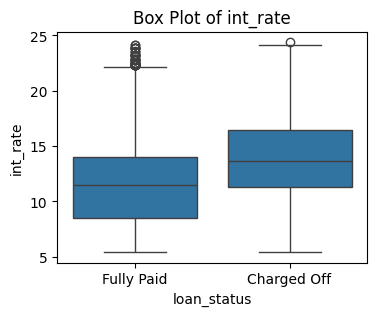

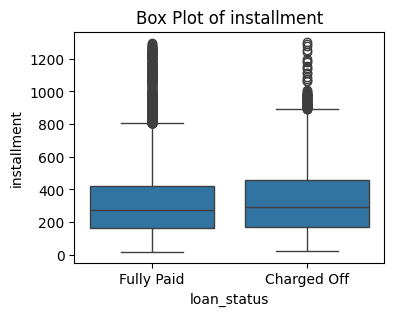

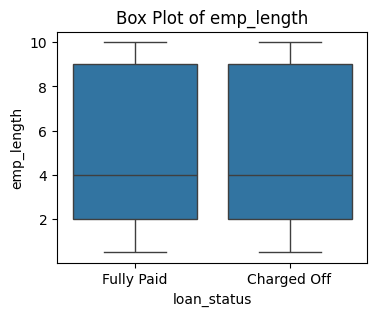

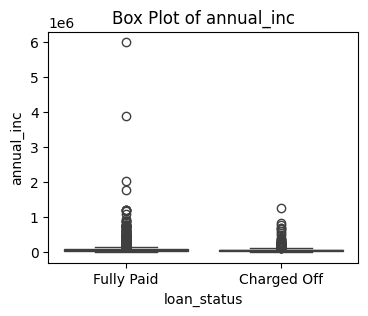

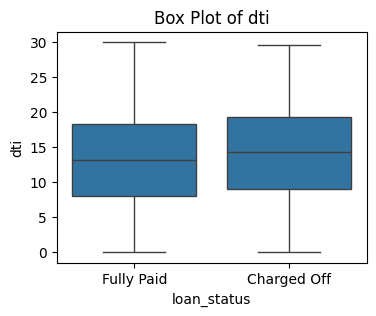

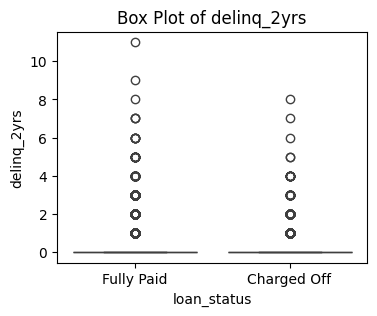

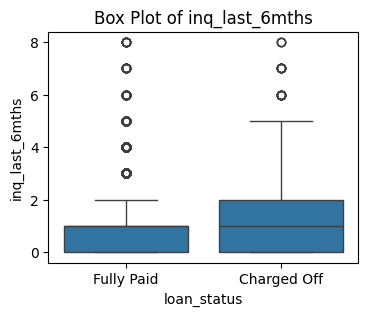

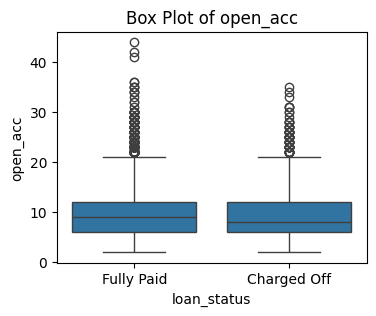

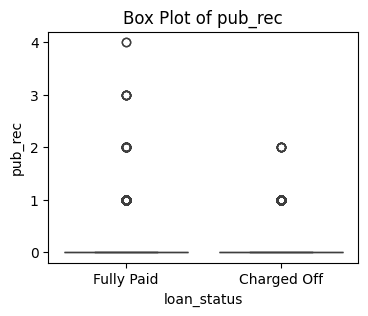

In [2770]:
# Plot for the first half of the columns
for col in first_half:
    plt.figure(figsize=(4, 3))
    sns.boxplot(data=df, x='loan_status', y=col)
    plt.title(f'Box Plot of {col}')
    plt.show()

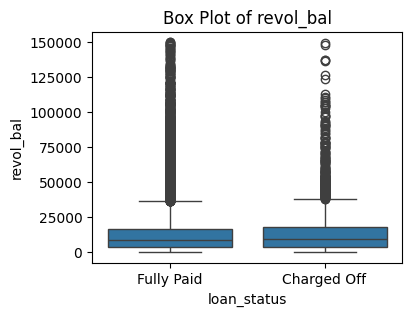

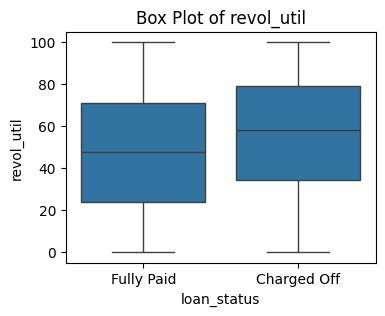

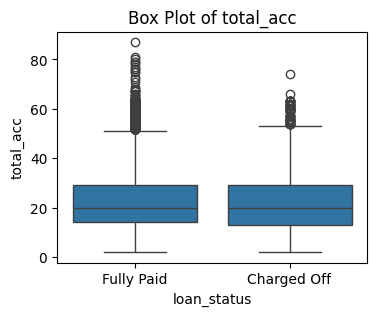

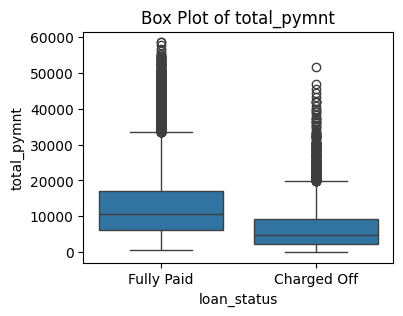

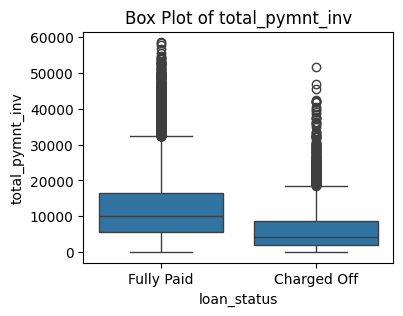

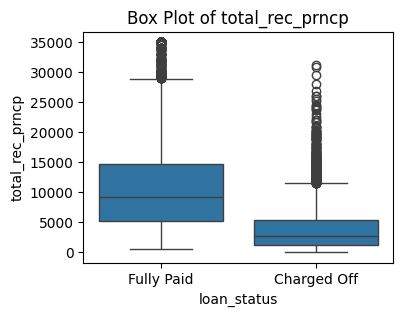

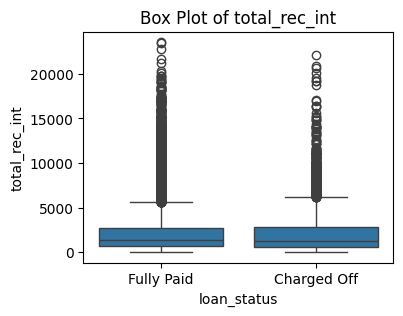

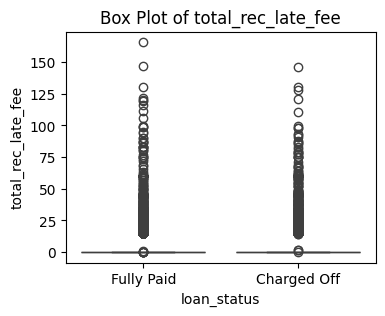

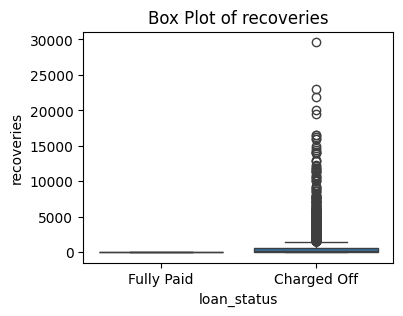

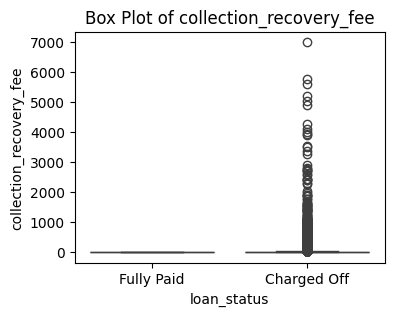

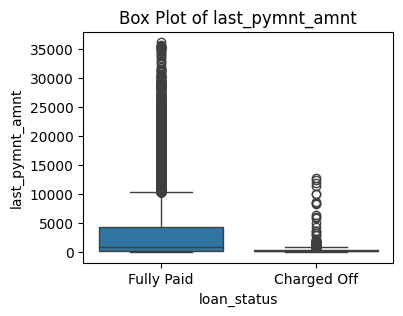

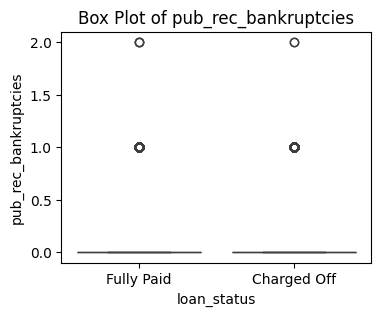

In [2771]:
# Plot for the second half of the columns
for col in second_half:
    plt.figure(figsize=(4, 3))
    sns.boxplot(data=df, x='loan_status', y=col)
    plt.title(f'Box Plot of {col}')
    plt.show()

Key Insights:

1. The upper whisker which is the maximum accepted value of the range of the distribution is higher for Charged Off applicants and crossing 30,000.
More charged off applicants requested for higher loans. Although the median of the loan amount is similar for both charged off applicants and fully paid candidates, for the Charged Off applicants, the 75th percentile value for loan amounts is higher than that of fully paid ones, and crossing 15,000. This implies, that applicants demanding higher loans are not able to pay them and get charged off.

Since we saw earlier, that funded_amnt and funded_amnt_inv depend on loan_amnt, they follow similar nature.

To prevent charged off cases, it is advised not to offer very high loans.


2. Applicants with high interest rate on their loans get charged off more. From the int_rate plots, we see that the median value of interest rate for Charged Off applicants are much higher than the paid ones (crossing 12.5%). The maximum value of the range is also higher (crossing 22.5%) for charged off applicants than paid ones. This implies all applicants cannot afford high interest rate and get charged off.

It is advised to keep a reasonable interest rate to avoid defaulter cases.


3. Applicants providing higher amount of installments are charged off because they cannot consistently provide the high installment amount throughout the term.


4. Applicants with medium level of employeement experience (4 to 8 yrs) comprise a greater portion of the Charged Off applicants population. Although that does not imply much.


5. Charged off applicants have a slightly higher dti ( debt to income ratio ) indicating that they might rely too much on loans and cannot keep up with all the debts.


6. For column revol_util (revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit), a higher proportion of Charged Off population has a higher value. This is evident from the higher median, 25th percentile and 75th percentile values.


7. The plots related to total payment received (total_pymnt, total_pymnt_inv, total_rec_prncp, total_rec_inv) are self-explanatory, where Charged Off applicants naturally have a lower proportion because they are not paying much.


8. For the visual, total_rec_late_fee, not many applicants paid late fee, but Charged Off applicants have greater outliers who have paid high late fee (higher than the fees of fully paid applicants). But we observe, even fully paid applicants were fined for paying late. So if somebody is paying high late fees there is a slight indication that the person might default.


9. The plots related to recoveries collected (recoveries,collection_recovery_fee) are self-explanatory, where Charged Off applicants naturally have a higher proportion. The presence of many outliers imply that although from many Charged Off applicants, recovery fees has been received, a significantly high proportion of charged off applicants have provided 0 or very nominal recovery fee. The high outlier collection fees were paid by charged off candidates.


10. Visual for inq_last_6mnths show Charged Off borrowers inquired more for the last 6 months, probably seeking more credits and having discussions due to the hindrances they were facing while paying the dues.


11. Plot for pub_rec_bankruptcies dont carry much useful information. Very few people were bankrupted as per outliers, and some of them fully paid loans even after having public bankruptcy records. Majority people had clean records.

12. Charged Off borrowers have lower credit score. Credit score below 0.8 should be treated with caution.


Since emp_length and pub_rec_bankruptcies are discrete numerical values let us plot and see percentage of charged off applicants for each value.

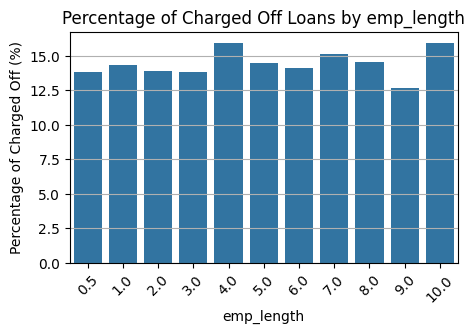

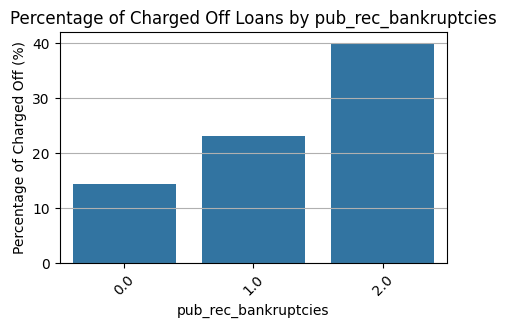

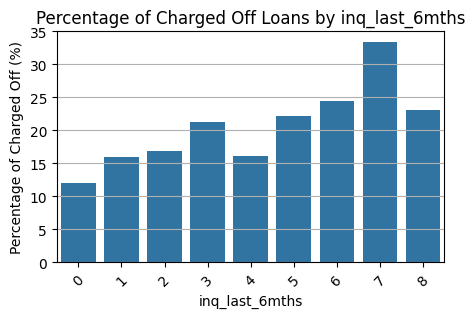

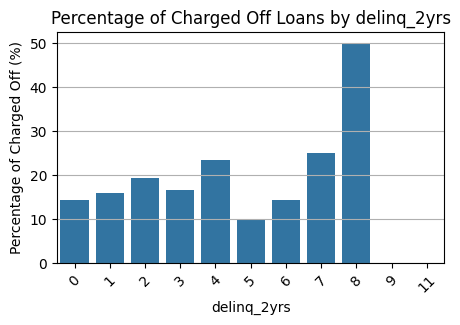

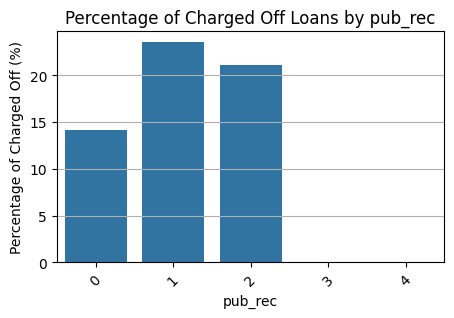

In [2772]:
columns_to_analyze = ['emp_length', 'pub_rec_bankruptcies','inq_last_6mths','delinq_2yrs','pub_rec']

for col in columns_to_analyze:
    # Calculate the percentage of charged off loans for each column
    charged_off_percentage = (
        df.groupby(col)['loan_status']
        .value_counts(normalize=True)
        .unstack()
        .fillna(0) * 100
    )

    # Create a DataFrame for plotting
    charged_off_percentage = charged_off_percentage['Charged Off'].reset_index()

    # Plotting
    plt.figure(figsize=(5, 3))
    sns.barplot(data=charged_off_percentage, x=col, y='Charged Off')
    plt.title(f'Percentage of Charged Off Loans by {col}')
    plt.ylabel('Percentage of Charged Off (%)')
    plt.xlabel(col)
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.show()

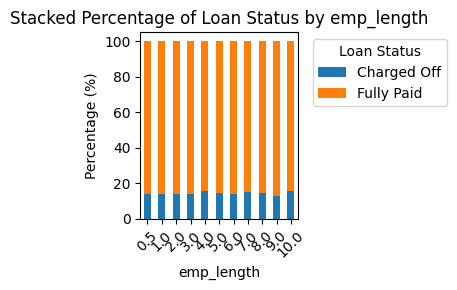

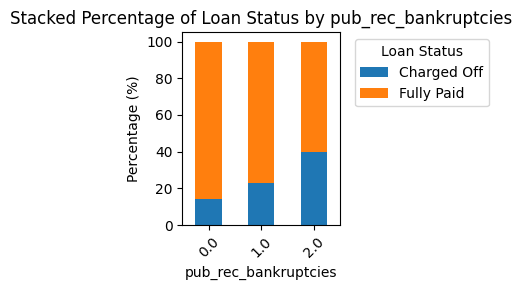

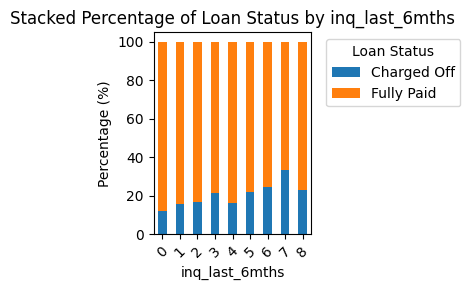

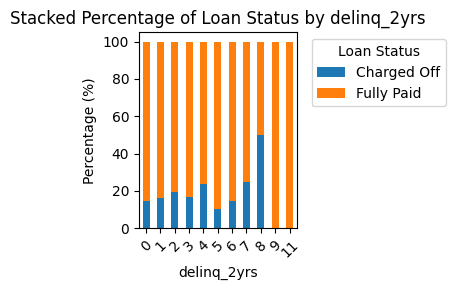

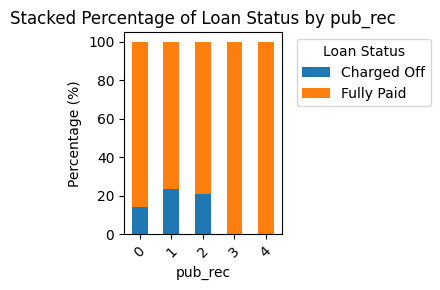

In [2773]:
# List of columns to analyze
columns_to_analyze = ['emp_length', 'pub_rec_bankruptcies', 'inq_last_6mths', 'delinq_2yrs', 'pub_rec']

# Loop through each column to analyze
for col in columns_to_analyze:
    # Calculate the percentage of each loan status for each column
    loan_status_percentage = (
        df.groupby([col, 'loan_status'])
        .size()
        .unstack()
        .fillna(0)
        .apply(lambda x: x / x.sum(), axis=1) * 100  # Calculate percentage for each loan status
    )

    # Plotting the stacked bar chart
    ax = loan_status_percentage.plot(kind='bar', stacked=True, figsize=(4, 3))

    plt.title(f'Stacked Percentage of Loan Status by {col}')
    plt.xlabel(col)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.legend(title='Loan Status', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

Out of the above visuals, only pub_rec_bankruptcies show a clear pattern that defaulter rate is higher for more number of bankruptcies.

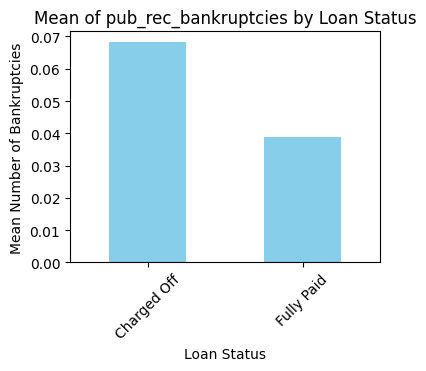

In [2774]:
mean_result = df.groupby('loan_status')['pub_rec_bankruptcies'].mean()

# Plot
plt.figure(figsize=(4, 3))
mean_result.plot(kind='bar', color='skyblue')
plt.title('Mean of pub_rec_bankruptcies by Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('Mean Number of Bankruptcies')
plt.xticks(rotation=45)
plt.show()

Key Insights:

Very few people had bankruptcy records. For those who had such records, the proportion of charge off rate is high. Charged off borrowers had more bankruptcies on an average than fully paid ones.


# Bivariate Analysis of loan_status with Categorical Columns

**Purpose** - To understand how the categorical variables influence target column loan_status

In [2775]:
objectcols=df.select_dtypes(include=['object','category'])
objectcols.nunique()

term                     2
grade                    7
emp_title               33
home_ownership           5
verification_status      3
issue_d                 55
purpose                 14
addr_state              50
earliest_cr_line       515
annual_inc_category      5
loan_amnt_category       5
int_rate_category        5
Last payment made        2
loan_status              2
dtype: int64

In [2776]:
unique_counts = objectcols.nunique()
filtered_columns = unique_counts.index
num_cols = len(filtered_columns)

In [2777]:
filtered_columns

Index(['term', 'grade', 'emp_title', 'home_ownership', 'verification_status',
       'issue_d', 'purpose', 'addr_state', 'earliest_cr_line',
       'annual_inc_category', 'loan_amnt_category', 'int_rate_category',
       'Last payment made', 'loan_status'],
      dtype='object')

Plotting percentage of Charged Offs for better visualization

In [2778]:
# List of input categorical columns

input_columns =[]

filtered_columns_lis=filtered_columns.tolist()

filtered_columns_lis.remove('loan_status')

filtered_columns_lis.remove('emp_title')

input_columns.extend(filtered_columns_lis)

print(input_columns)

# Create a figure for the plots
num_cols = len(input_columns)

['term', 'grade', 'home_ownership', 'verification_status', 'issue_d', 'purpose', 'addr_state', 'earliest_cr_line', 'annual_inc_category', 'loan_amnt_category', 'int_rate_category', 'Last payment made']


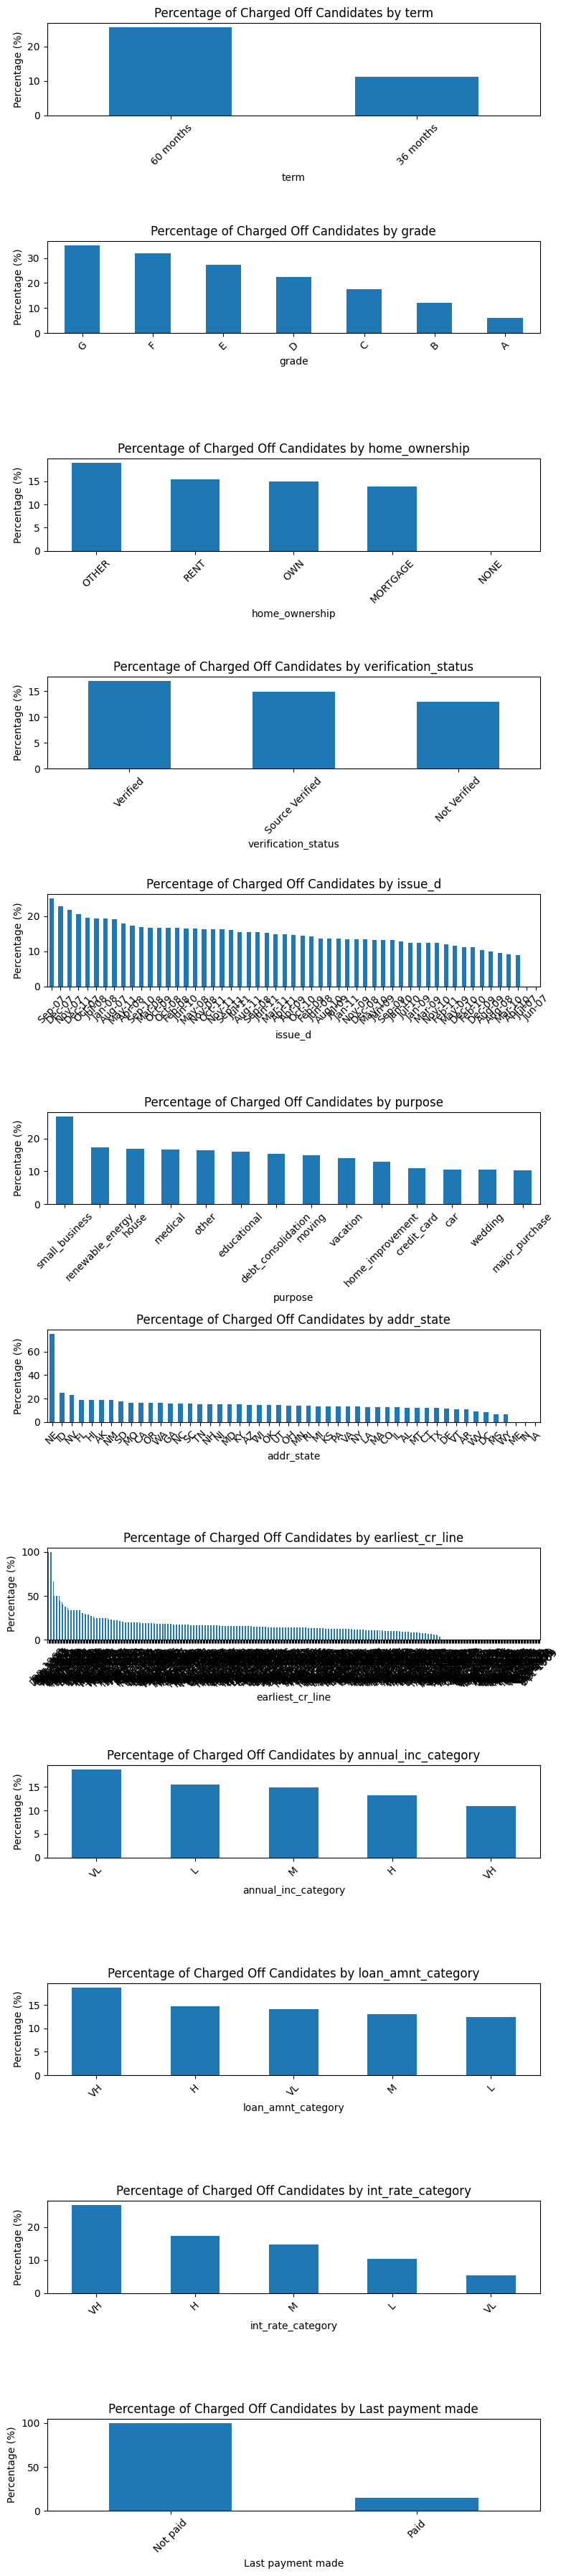

In [2779]:

#fig, axes = plt.subplots(num_cols, 1, figsize=(45, 12 * num_cols))


fig, axes = plt.subplots(num_cols, 1, figsize=(8, 3 * num_cols))

# Loop through each input column
for i, col in enumerate(input_columns):
    # Calculate the percentage of Charged Off candidates
    charged_off_percentage = df.groupby(col)['loan_status'].value_counts(normalize=True).unstack().fillna(0) * 100

    charged_off_sorted = charged_off_percentage['Charged Off'].sort_values(ascending=False)
    #print(charged_off_sorted)

    # Plot the percentage of Charged Off
    charged_off_sorted.plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Percentage of Charged Off Candidates by {col}')
    axes[i].set_ylabel('Percentage (%)')
    axes[i].set_xlabel(col)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

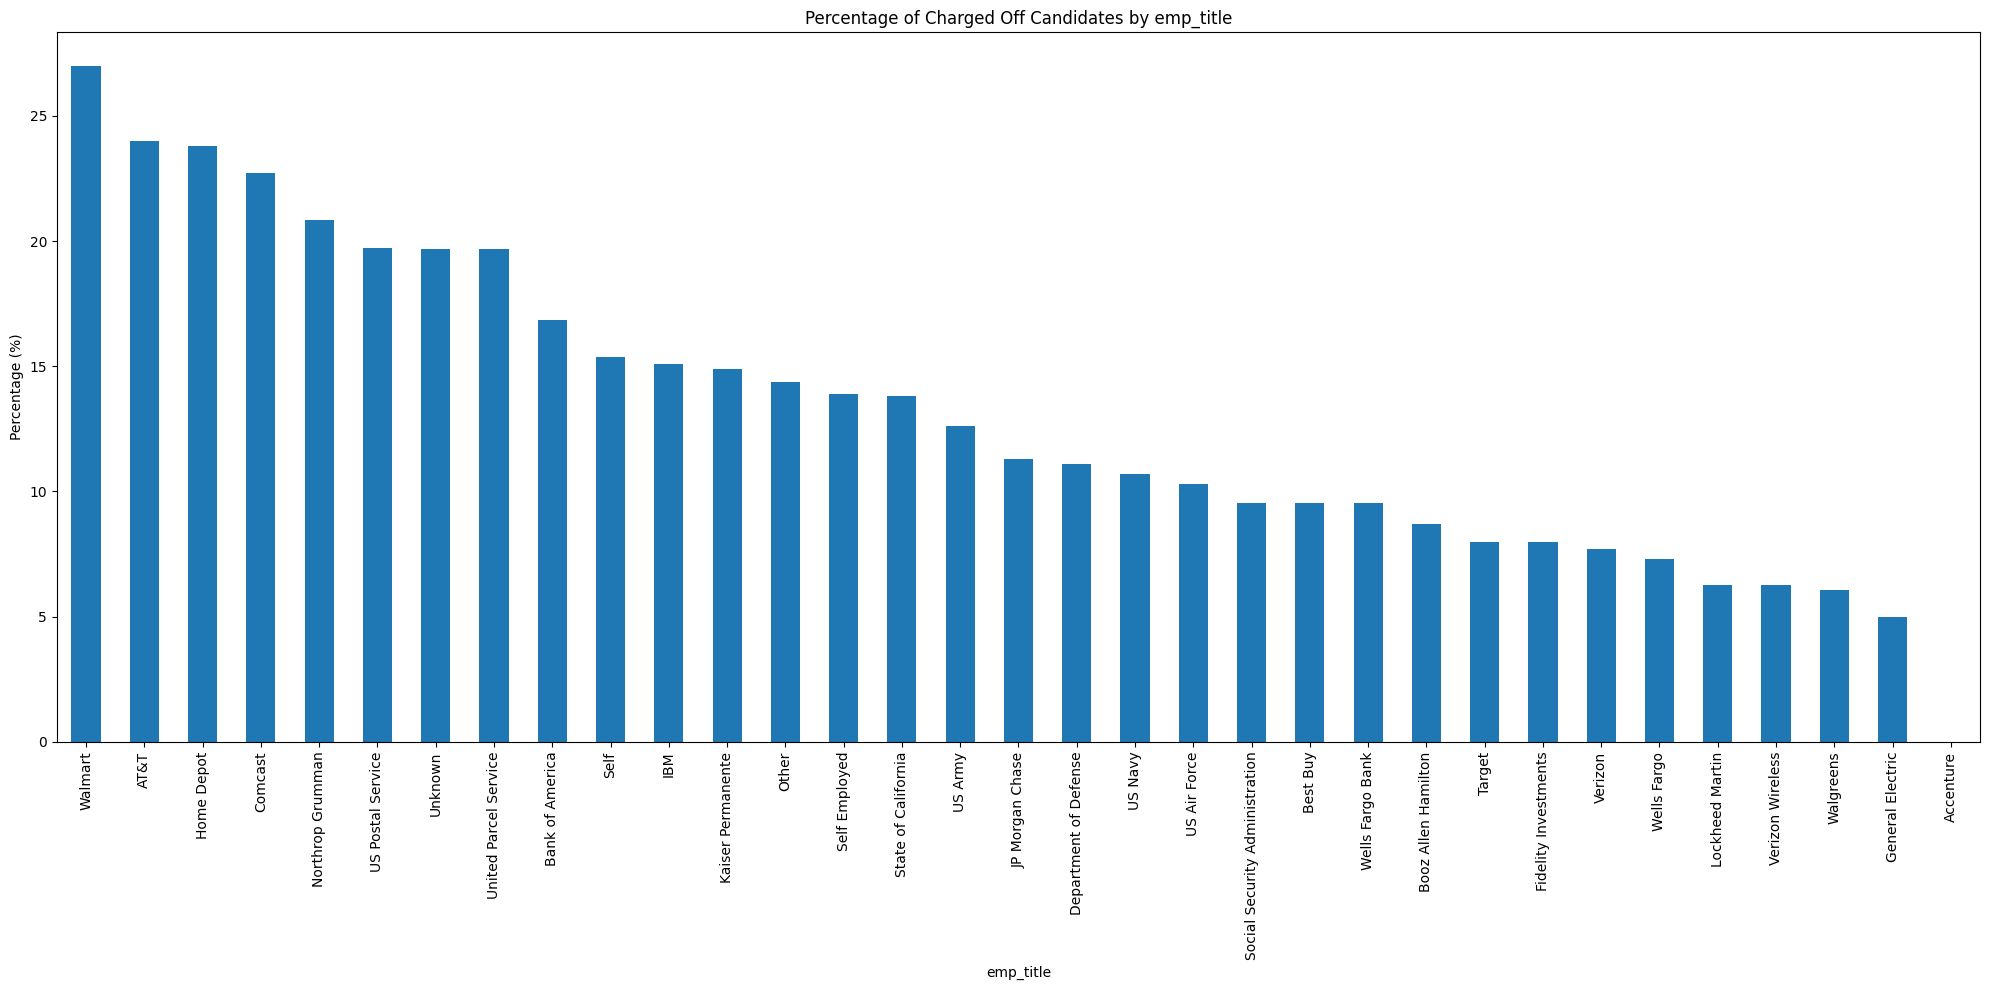

In [2780]:
# viewing charged off percentage per emp_title separately for better visualising
plt.figure(figsize=(20,10))
# Calculate the percentage of Charged Off candidates
col='emp_title'
charged_off_percentage = df.groupby(col)['loan_status'].value_counts(normalize=True).unstack().fillna(0) * 100

charged_off_sorted = charged_off_percentage['Charged Off'].sort_values(ascending=False)
#print(charged_off_sorted)

# Plot the percentage of Charged Off
charged_off_sorted.plot(kind='bar')
plt.title(f'Percentage of Charged Off Candidates by {col}')
plt.ylabel('Percentage (%)')
plt.xlabel(col)
plt.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

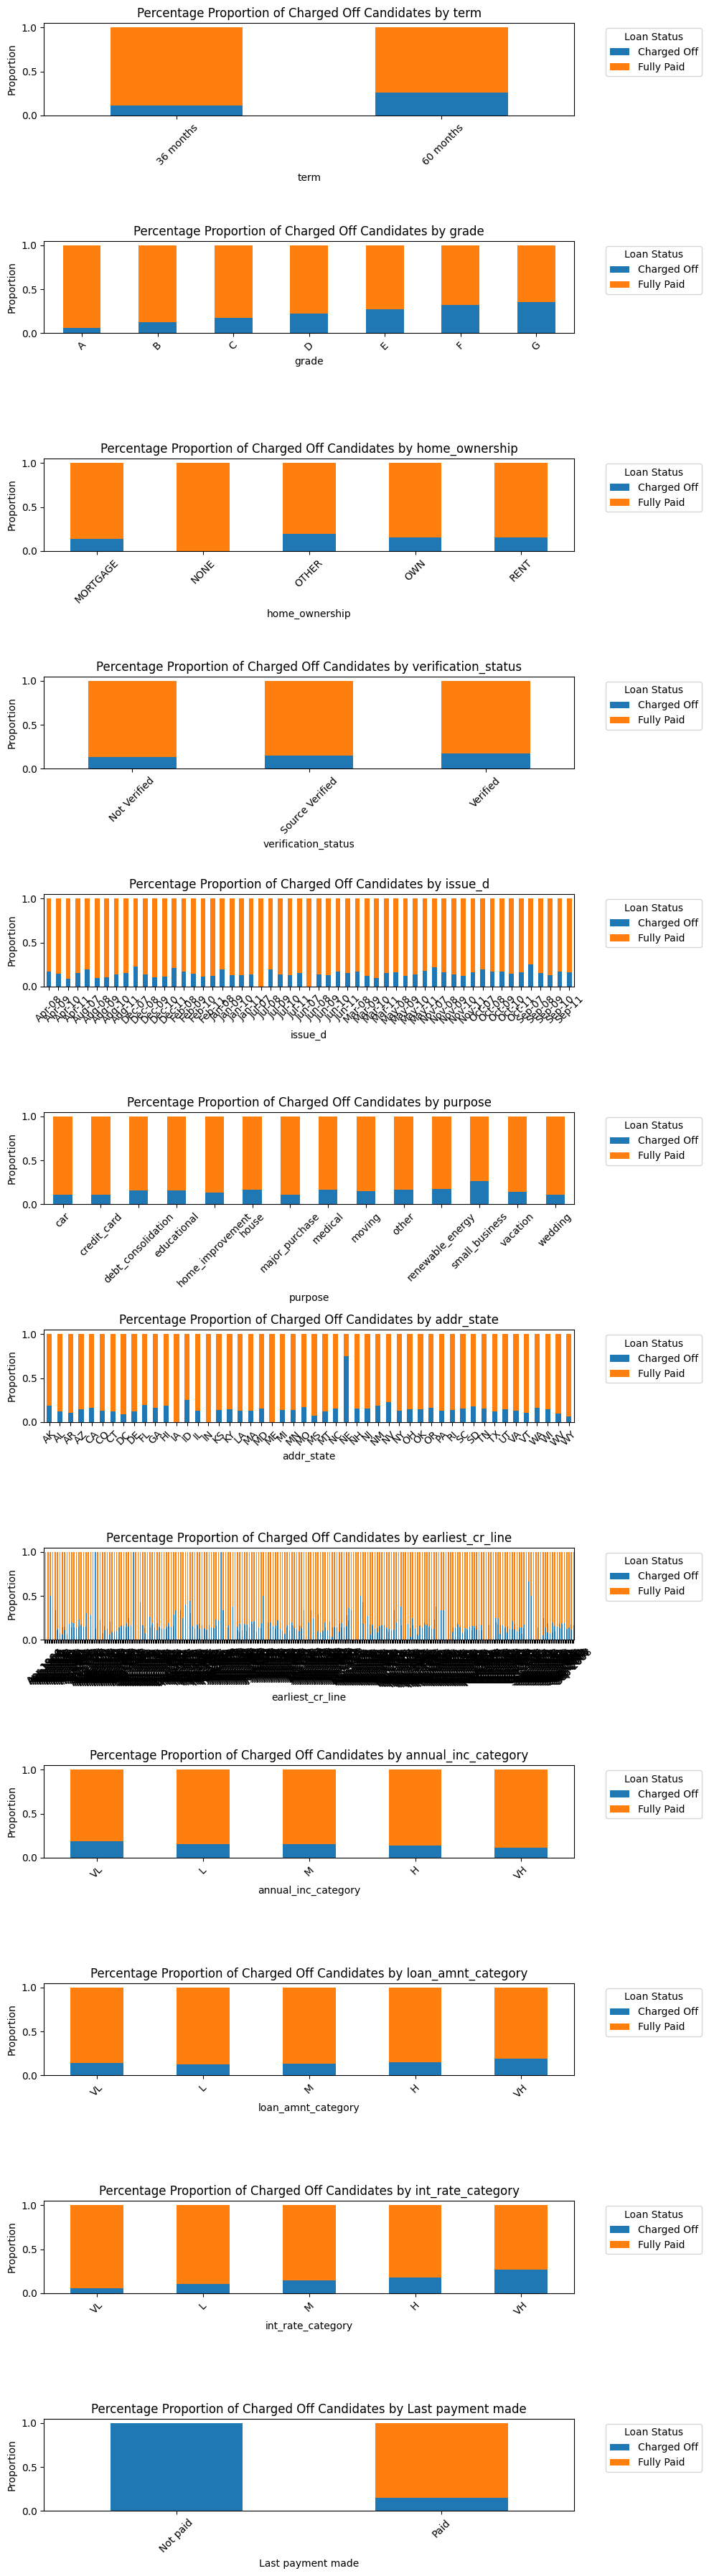

In [2781]:
# Create a figure for the plots
num_cols = len(input_columns)
#fig, axes = plt.subplots(num_cols, 1, figsize=(45, 12 * num_cols))
fig, axes = plt.subplots(num_cols, 1, figsize=(10, 3 * num_cols))

# Loop through each input column
for i, col in enumerate(input_columns):
    counts = df.groupby([col, 'loan_status']).size().unstack(fill_value=0)
    # Calculate the proportion of each category
    proportions = counts.div(counts.sum(axis=1), axis=0)

    # Plot the percentage proportion of Charged Off
    proportions.plot(kind='bar', stacked=True,ax=axes[i])
    axes[i].set_title(f'Percentage Proportion of Charged Off Candidates by {col}')
    axes[i].set_ylabel('Proportion')
    axes[i].set_xlabel(col)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].legend(title='Loan Status', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

<Figure size 4000x2000 with 0 Axes>

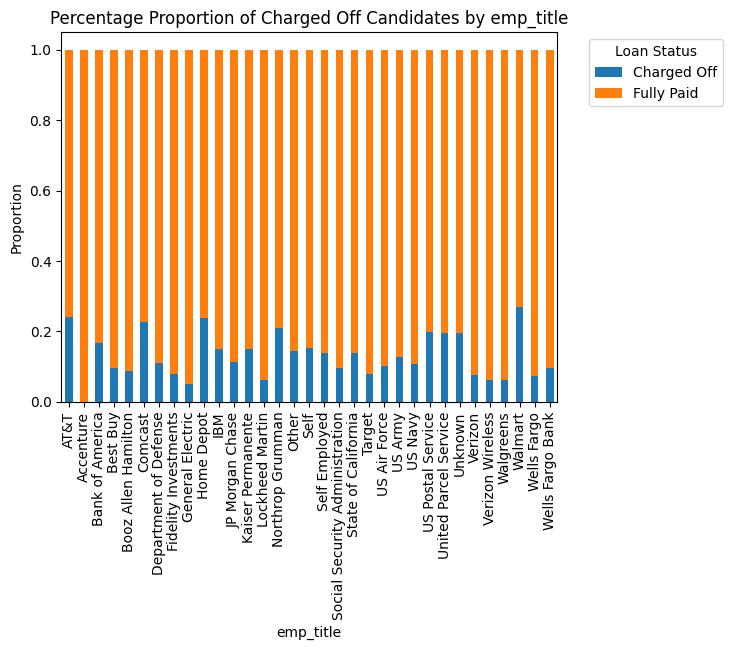

In [2782]:
# viewing charged off percentage per emp_title separately for better visualising

# Calculate the percentage of Charged Off candidates
col='emp_title'
plt.figure(figsize=(40,20))
counts = df.groupby([col, 'loan_status']).size().unstack(fill_value=0)
# Calculate the proportion of each category
proportions = counts.div(counts.sum(axis=1), axis=0)

# Plot the percentage proportion of Charged Off
proportions.plot(kind='bar', stacked=True)
plt.title(f'Percentage Proportion of Charged Off Candidates by {col}')
plt.ylabel('Proportion')
plt.xlabel(col)
plt.tick_params(axis='x', rotation=90)
plt.legend(title='Loan Status', bbox_to_anchor=(1.05, 1), loc='upper left')


#plt.tight_layout()
plt.show()

Key Insights:

1. Higher the loan amount loan_amnt, higher the charge off percentage. To keep charge off rate below 15%, by scrutinizing the all the loan_amnt visuals, its recommended that loan amounts should be maintained within range of 500 to 16,000 as per the range values of VL,L,M,H category buckets.


2. Higher the interest rate int_rate, more is charge off percentage. To keep Charge Off percentage near 10% select low (L: 7.9 - 10.99) or very low (VL: 5.42 - 7.90) interest rates.


3. Borrowers with long term loans get charged off more.


4. As loan grade / sub grade increases from A to G (calling A as lowest grade and G as highest grade), the percentage of Charge Off increases.


5. Borrowers with emp_title Walmart get charged off more.


6. As per univariate analysis of home_ownership, rent and mortage comprise nearly approximately 44% (highest proportion) of the data individually. Out of that, approximately 15% are charged off. 'Other' category comprises a very small portion but still shows highest percentage of defaulters. But difference in the charged off proportions across the home ownership categories is very less.


7. About 41% (highest proportion) of the borrower population are not verified. Out of them about 13% are getting charged off. Attention needs to be given towards their verification. However borrowers with verified status also show a significant percentage of getting charged off.


8. Month of issue of loan do not strongly imply any significant pattern.


9. Applicants borrowing loan for small business purpose charge off more , (about 26%) probably because they suffer loss and cannot repay. But the portion of borrowers taking loans for this purpose is 6% only. Borrowers with purpose of debt consolidation occupy about 44% of the population. Their charge off rate is about 15%.


10. Among the states, NE shows highest percentage of charged off applicants (nearly 60%). CA, which has maximum number of applicants from its region have about 18% charge off rates.


11. As income decreases, percentage of charge off increases.


12. Most of the defaulters, dont pay any amount.

Hence dropping month of issue

In [2783]:
df.drop(columns=['issue_dd','issue_d'],inplace=True)
x_train.drop(columns=['issue_dd','issue_d'],inplace=True)
df.shape,x_train.shape

((30861, 37), (30861, 36))

In [2784]:
x_train=x_train.drop(columns=['annual_inc_category','loan_amnt_category','int_rate_category'])

df.shape,x_train.shape

((30861, 37), (30861, 33))

# Multivariate Analysis

**Purpose** - To check how each column influences the other and also to check how target column loan_status behaves when segmented across 2 variables.

Checking loan status variations with annual income, grades, interest rate, loan amounts.

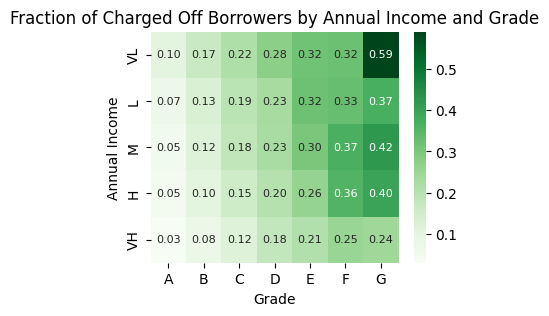

In [2785]:
# Create a pivot table
pivot_table = df.pivot_table(
    index='annual_inc_category',
    columns='grade',
    values='loan_status',
    aggfunc=lambda x: (x == 'Charged Off').sum() / len(x)  # Calculate the fraction of charged off
)

# Fill NaN values with 0 for better visualization
pivot_table.fillna(0, inplace=True)

# Plotting the heatmap
plt.figure(figsize=(4,3))
sns.heatmap(pivot_table, cmap='Greens', annot=True, fmt='.2f',annot_kws={'size': 8})
plt.title('Fraction of Charged Off Borrowers by Annual Income and Grade')
plt.ylabel('Annual Income')
plt.xlabel('Grade')
plt.show()

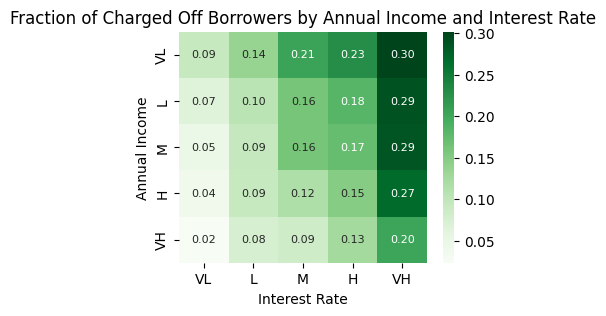

In [2786]:
pivot_table = df.pivot_table(
    index='annual_inc_category',
    columns='int_rate_category',
    values='loan_status',
    aggfunc=lambda x: (x == 'Charged Off').sum() / len(x)  # Calculate the fraction of charged off
)

# Fill NaN values with 0 for better visualization
pivot_table.fillna(0, inplace=True)

# Plotting the heatmap
plt.figure(figsize=(4,3))
sns.heatmap(pivot_table, cmap='Greens', annot=True, fmt='.2f',annot_kws={'size': 8})
plt.title('Fraction of Charged Off Borrowers by Annual Income and Interest Rate')
plt.ylabel('Annual Income')
plt.xlabel('Interest Rate')
plt.show()

As grade increases, the charged off proportion also increases and same pattern observed for interest rate. The greatest risk is with the lower income applicants. From this we can also infer that as grade increases from A to G, the interest rate increases. Interest rate at G is greater than at grade A so G grade is riskier than A.

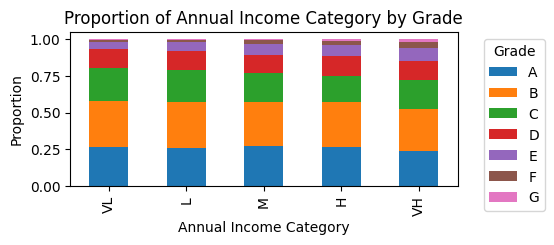

In [2787]:
counts = df.groupby(['annual_inc_category', 'grade']).size().unstack(fill_value=0)
# Calculate the proportion of each category
proportions = counts.div(counts.sum(axis=1), axis=0)

# Plotting
proportions.plot(kind='bar', stacked=True, figsize=(5, 2))
plt.title('Proportion of Annual Income Category by Grade')
plt.ylabel('Proportion')
plt.xlabel('Annual Income Category')
plt.legend(title='Grade', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Applicants from all income groups mostly prefer A grade and B grade loans but proportion of applicants with B grade loans is slightly higher than A. Since as per heatmap the charge off rate for B grade loans is higher than that of A, grade A should be prioritised.

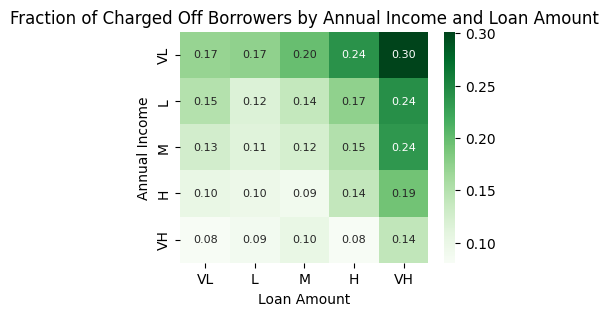

In [2788]:
# Create a pivot table
pivot_table = df.pivot_table(
    index='annual_inc_category',
    columns='loan_amnt_category',
    values='loan_status',
    aggfunc=lambda x: (x == 'Charged Off').sum() / len(x)  # Calculate the fraction of charged off
)

# Fill NaN values with 0 for better visualization
pivot_table.fillna(0, inplace=True)

# Plotting the heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(pivot_table, cmap='Greens', annot=True, fmt='.2f',annot_kws={'size': 8})
plt.title('Fraction of Charged Off Borrowers by Annual Income and Loan Amount')
plt.ylabel('Annual Income')
plt.xlabel('Loan Amount')
plt.show()

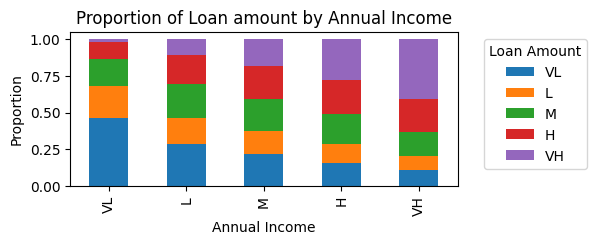

In [2789]:
counts = df.groupby(['annual_inc_category', 'loan_amnt_category']).size().unstack(fill_value=0)
# Calculate the proportion of each category
proportions = counts.div(counts.sum(axis=1), axis=0)

# Plotting
proportions.plot(kind='bar', stacked=True, figsize=(5,2))
plt.title('Proportion of Loan amount by Annual Income')
plt.ylabel('Proportion')
plt.xlabel('Annual Income')
plt.xticks(rotation=90)
plt.legend(title='Loan Amount', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

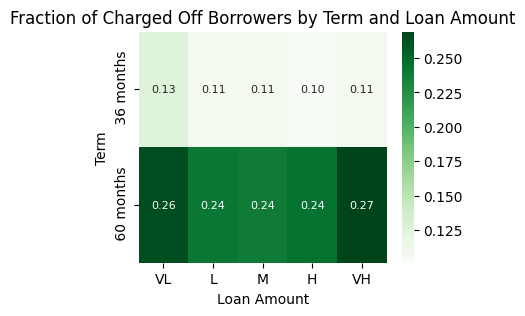

In [2790]:
# Create a pivot table
pivot_table = df.pivot_table(
    index='term',
    columns='loan_amnt_category',
    values='loan_status',
    aggfunc=lambda x: (x == 'Charged Off').sum() / len(x)  # Calculate the fraction of charged off
)

# Fill NaN values with 0 for better visualization
pivot_table.fillna(0, inplace=True)

# Plotting the heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(pivot_table, cmap='Greens', annot=True, fmt='.2f',annot_kws={'size': 8})
plt.title('Fraction of Charged Off Borrowers by Term and Loan Amount')
plt.ylabel('Term')
plt.xlabel('Loan Amount')
plt.show()

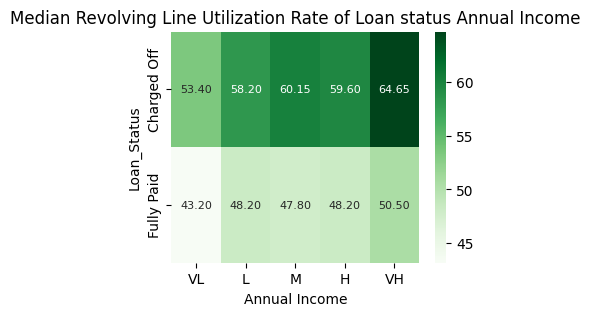

In [2791]:
pivot_table = df.pivot_table(
    index='loan_status',
    columns='annual_inc_category',
    values='revol_util',
    aggfunc='median'  # Calculate the fraction of charged off
)

# Fill NaN values with 0 for better visualization
pivot_table.fillna(0, inplace=True)



# Plotting the heatmap
plt.figure(figsize=(4,3))
sns.heatmap(pivot_table, cmap='Greens', annot=True, fmt='.2f',annot_kws={'size': 8})
plt.title('Median Revolving Line Utilization Rate of Loan status Annual Income')
plt.ylabel('Loan_Status')
plt.xlabel('Annual Income')
plt.show()

Median employment length for different combinations of loan status and annual income categories

In [2792]:
loan_counts = df.groupby('annual_inc_category')['loan_status'].count()
charged_off_counts = df[df['loan_status'] == 'Charged Off'].groupby('annual_inc_category')['loan_status'].count()

# Calculate default rate
default_rates = (charged_off_counts / loan_counts) * 100

In [2793]:
emp_length_pivot = df.pivot_table(
    index='annual_inc_category',
    columns='loan_status',
    values='emp_length',
    aggfunc='median'
)

# Rename columns for clarity
emp_length_pivot.columns = ['Charged Off Emp Length', 'Fully Paid Emp Length']

# Add default rate to the pivot table
emp_length_pivot['Default Rate'] = default_rates

In [2794]:
emp_length_pivot.columns

Index(['Charged Off Emp Length', 'Fully Paid Emp Length', 'Default Rate'], dtype='object')

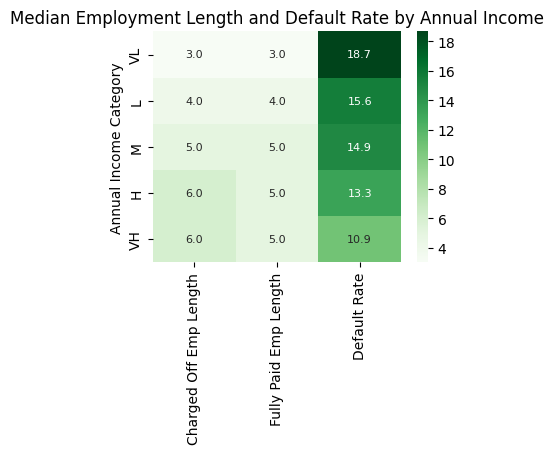

In [2795]:
plt.figure(figsize=(4,3))
sns.heatmap(emp_length_pivot, cmap='Greens', annot=True, fmt='.1f',annot_kws={'size': 8})
plt.title('Median Employment Length and Default Rate by Annual Income')
plt.ylabel('Annual Income Category')
plt.show()

Key Insights:

Income appears to be a stronger predictor of default risk than employment length. As income increases, default rates consistently decrease. Employment length doesn't show a clear correlation with default rates across income categories. This suggests that income level may be more important in predicting loan repayment than length of employment. The Very High income category shows an interesting pattern with longer employment length for charged off loans. This could indicate that for high earners, factors other than job stability might be influencing default risk. The difference in default rates between the lowest and highest income categories is significant (18.3% vs 10.9%), suggesting that income-based risk assessment could be valuable.

As per bivariate analysis of categorical columns, borrowers with smaller_business purpose charge off more. Let us check loan status variations with purpose and other driving factors.

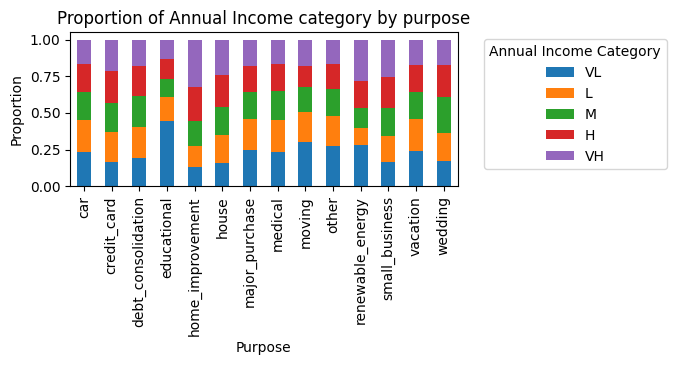

In [2796]:
counts = df.groupby(['purpose', 'annual_inc_category']).size().unstack(fill_value=0)
# Calculate the proportion of each category
proportions = counts.div(counts.sum(axis=1), axis=0)

# Plotting
proportions.plot(kind='bar', stacked=True, figsize=(5,2))
plt.title('Proportion of Annual Income category by purpose')
plt.ylabel('Proportion')
plt.xlabel('Purpose')
plt.legend(title='Annual Income Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

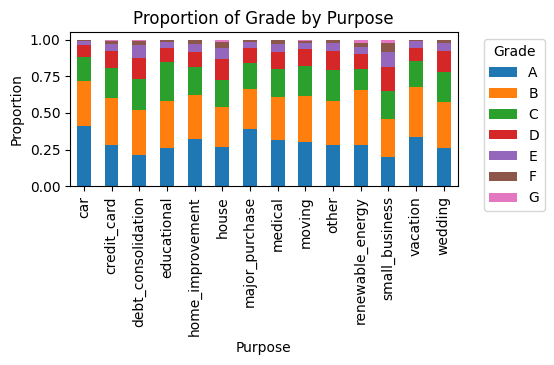

In [2797]:
counts = df.groupby(['purpose', 'grade']).size().unstack(fill_value=0)
# Calculate the proportion of each category
proportions = counts.div(counts.sum(axis=1), axis=0)

# Plotting
proportions.plot(kind='bar', stacked=True, figsize=(5,2))
plt.title('Proportion of Grade by Purpose')
plt.ylabel('Proportion')
plt.xlabel('Purpose')
plt.xticks(rotation=90)
plt.legend(title='Grade', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

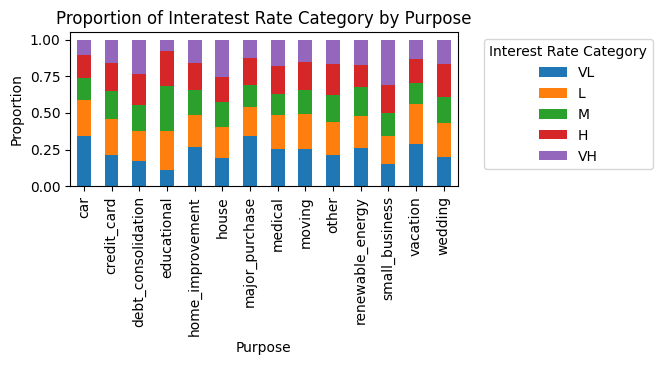

In [2798]:
counts = df.groupby(['purpose', 'int_rate_category']).size().unstack(fill_value=0)
# Calculate the proportion of each category
proportions = counts.div(counts.sum(axis=1), axis=0)

# Plotting
proportions.plot(kind='bar', stacked=True, figsize=(5,2))
plt.title('Proportion of Interatest Rate Category by Purpose')
plt.ylabel('Proportion')
plt.xlabel('Purpose')
plt.xticks(rotation=90)
plt.legend(title='Interest Rate Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

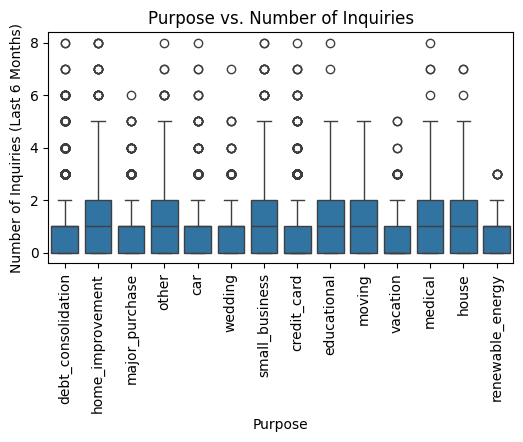

In [2799]:
plt.figure(figsize=(6, 3))
sns.boxplot(data=df, x='purpose', y='inq_last_6mths')
plt.title('Purpose vs. Number of Inquiries')
plt.xlabel('Purpose')
plt.ylabel('Number of Inquiries (Last 6 Months)')
plt.xticks(rotation=90)
plt.show()

Key Insights:

Applicants with small business purpose are charging off most, because to make up for their financial losses, they are taking more higher grade loans with higher interest rate and doing more inquiries for more credits, struggling with credit repay and consequently charging off.

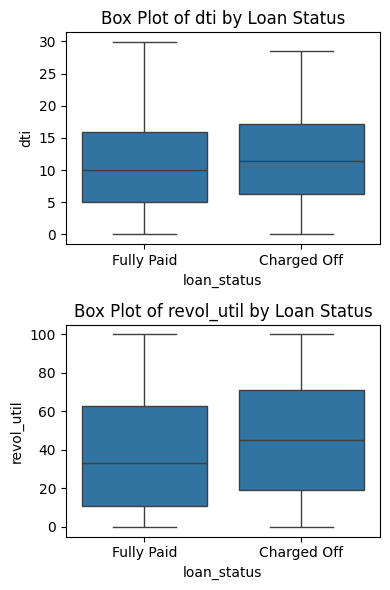

In [2800]:
df_small_business=df[df['purpose']=='small_business']
# List of columns to plot
columns_to_plot = ['dti','revol_util']

# Create box plots for each column
plt.figure(figsize=(4,6))
for i, column in enumerate(columns_to_plot):
    plt.subplot(len(columns_to_plot), 1, i + 1)
    sns.boxplot(x='loan_status', y=column, data=df_small_business)
    plt.title(f'Box Plot of {column} by Loan Status')

plt.tight_layout()
plt.show()

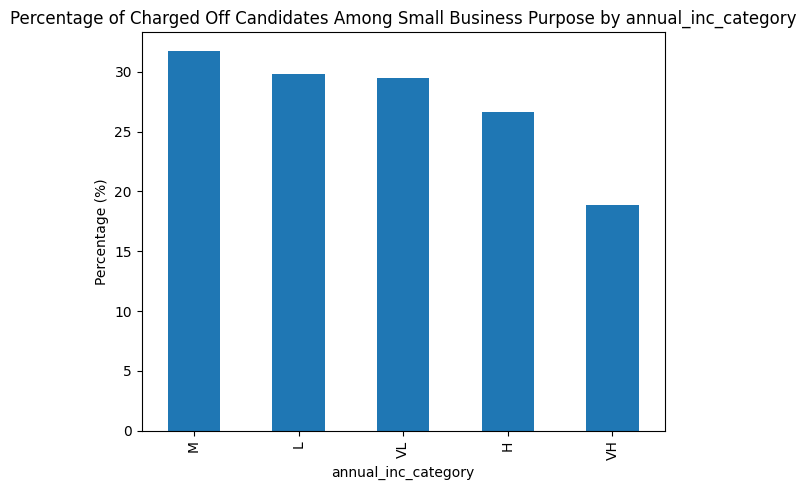

In [2801]:
plt.figure(figsize=(6,5))
# Calculate the percentage of Charged Off candidates
col='annual_inc_category'
charged_off_percentage = df_small_business.groupby(col)['loan_status'].value_counts(normalize=True).unstack().fillna(0) * 100

charged_off_sorted = charged_off_percentage['Charged Off'].sort_values(ascending=False)
#print(charged_off_sorted)

# Plot the percentage of Charged Off
charged_off_sorted.plot(kind='bar')
plt.title(f'Percentage of Charged Off Candidates Among Small Business Purpose by {col}')
plt.ylabel('Percentage (%)')
plt.xlabel(col)
plt.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

Key Insights:

While rejecting people taking loans for small business purpose as they had high charge off rates, it should be ensured that no opportunity is missed while rejecting a capable applicant with small business purpose from providing loan by taking care of the nuances. Criteria for applicants taking loans for small business purpose who should not be rejected from taking loans:

a. Revolving Line Utilization rate < 35

b. Annual Income group = VH (16000.00 to 35000.00)


Multivariate analysis with the address states

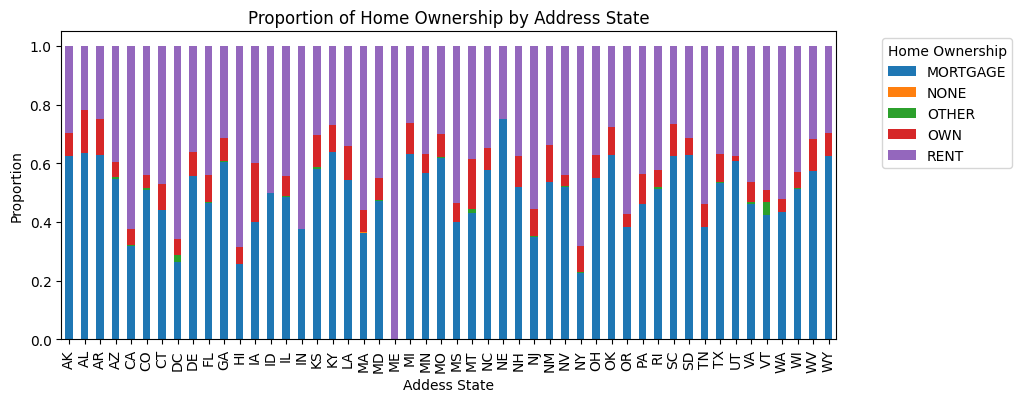

In [2802]:
counts = df.groupby(['addr_state', 'home_ownership']).size().unstack(fill_value=0)
# Calculate the proportion of each category
proportions = counts.div(counts.sum(axis=1), axis=0)

# Plotting
proportions.plot(kind='bar', stacked=True, figsize=(10, 4))
plt.title('Proportion of Home Ownership by Address State')
plt.ylabel('Proportion')
plt.xlabel('Addess State')
plt.legend(title='Home Ownership', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

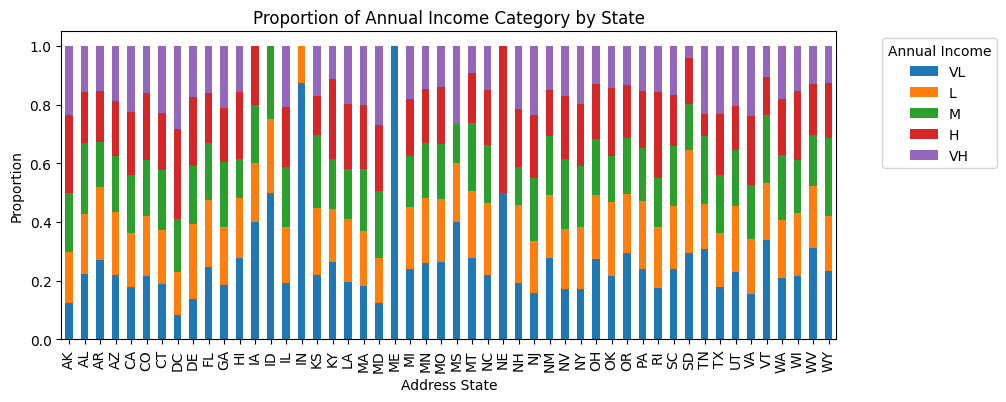

In [2803]:
counts = df.groupby(['addr_state', 'annual_inc_category']).size().unstack(fill_value=0)
# Calculate the proportion of each category
proportions = counts.div(counts.sum(axis=1), axis=0)

# Plotting
proportions.plot(kind='bar', stacked=True, figsize=(10, 4))
plt.title('Proportion of Annual Income Category by State')
plt.ylabel('Proportion')
plt.xlabel('Address State')
plt.legend(title='Annual Income', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

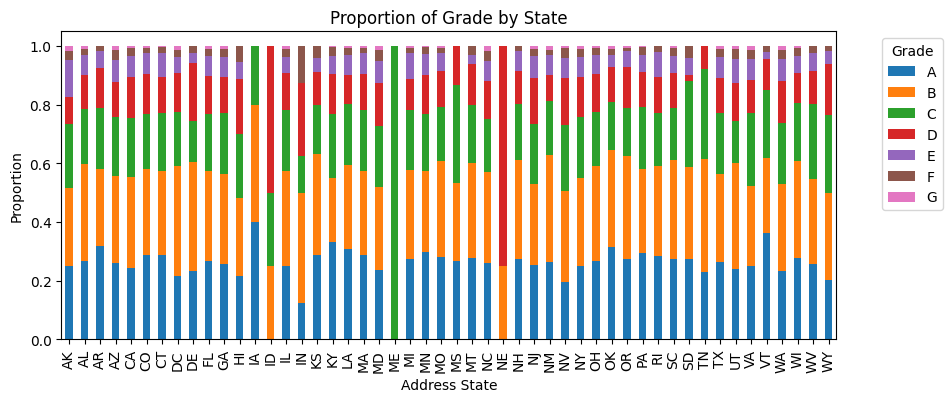

In [2804]:
counts = df.groupby(['addr_state', 'grade']).size().unstack(fill_value=0)
# Calculate the proportion of each category
proportions = counts.div(counts.sum(axis=1), axis=0)

# Plotting
proportions.plot(kind='bar', stacked=True, figsize=(10, 4))
plt.title('Proportion of Grade by State')
plt.ylabel('Proportion')
plt.xlabel('Address State')
plt.legend(title='Grade', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Let us check home_ownership with respect to different variables.

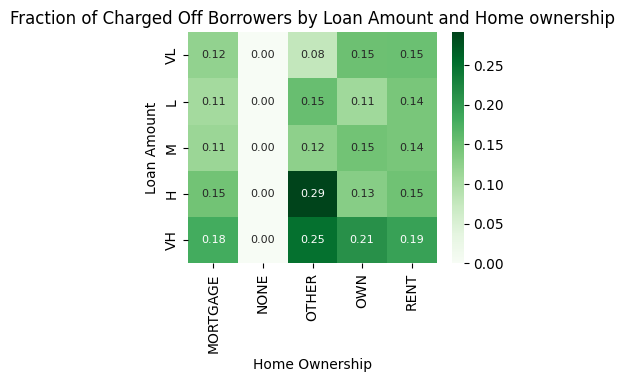

In [2805]:
pivot_table = df.pivot_table(
    index='loan_amnt_category',
    columns='home_ownership',
    values='loan_status',
    aggfunc=lambda x: (x == 'Charged Off').sum() / len(x)  # Calculate the fraction of charged off
)

# Fill NaN values with 0 for better visualization
pivot_table.fillna(0, inplace=True)

# Plotting the heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(pivot_table, cmap='Greens', annot=True, fmt='.2f',annot_kws={'size': 8})
plt.title('Fraction of Charged Off Borrowers by Loan Amount and Home ownership')
plt.ylabel('Loan Amount')
plt.xlabel('Home Ownership')
plt.show()

For 'Other' category of home ownership, loan amounts should be restricted to range of L (5000 to 7750) and VL (500 to 5000) for preventing defaults.

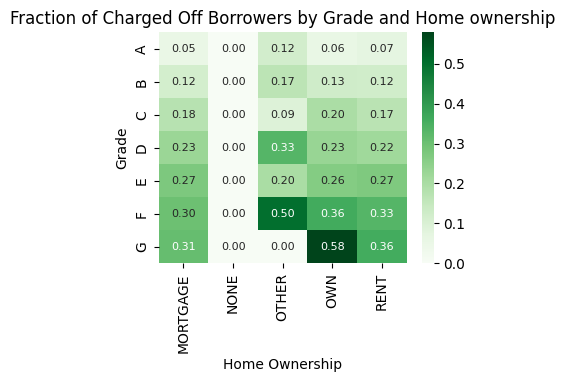

In [2806]:
pivot_table = df.pivot_table(
    index='grade',
    columns='home_ownership',
    values='loan_status',
    aggfunc=lambda x: (x == 'Charged Off').sum() / len(x)  # Calculate the fraction of charged off
)

# Fill NaN values with 0 for better visualization
pivot_table.fillna(0, inplace=True)

# Plotting the heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(pivot_table, cmap='Greens', annot=True, fmt='.2f',annot_kws={'size': 8})
plt.title('Fraction of Charged Off Borrowers by Grade and Home ownership')
plt.ylabel('Grade')
plt.xlabel('Home Ownership')
plt.show()

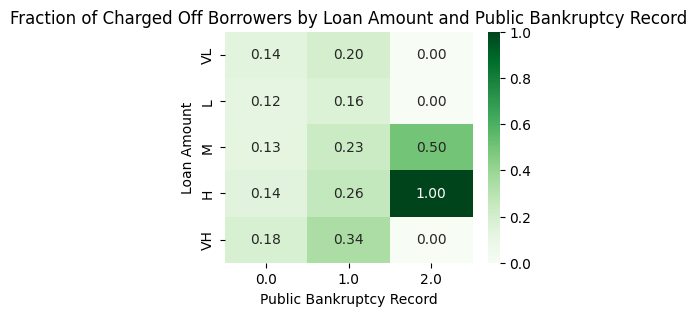

In [2807]:
# Checking charged off proportion by loan amount categories and bankruptcies

pivot_table = df.pivot_table(
    index='loan_amnt_category',
    columns='pub_rec_bankruptcies',
    values='loan_status',
    aggfunc=lambda x: (x == 'Charged Off').sum() / len(x)  # Calculate the fraction of charged off
)

# Fill NaN values with 0 for better visualization
pivot_table.fillna(0, inplace=True)

# Plotting the heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(pivot_table, cmap='Greens', annot=True, fmt='.2f')
plt.title('Fraction of Charged Off Borrowers by Loan Amount and Public Bankruptcy Record')
plt.ylabel('Loan Amount')
plt.xlabel('Public Bankruptcy Record')
plt.show()

People with maximum bankrupt records took loans in High and Medium range and defaulted.

Let us check emp_length with different variables.

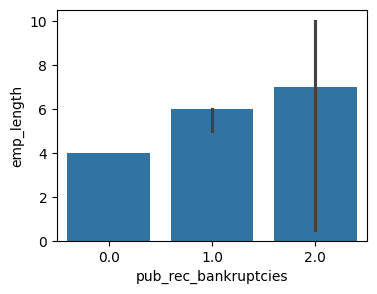

In [2808]:
plt.figure(figsize=[4,3])
sns.barplot(x='pub_rec_bankruptcies', y='emp_length', data=df, estimator='median')
plt.show()

Higher employee length had more bankruptcies. But this cannot be said with much confidence, as very few people had bankruptcy cases.

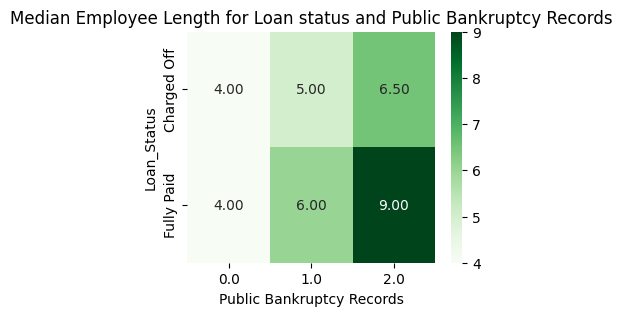

In [2809]:
pivot_table = df.pivot_table(
    index='loan_status',
    columns='pub_rec_bankruptcies',
    values='emp_length',
    aggfunc='median'  # Calculate the fraction of charged off
)

# Fill NaN values with 0 for better visualization
pivot_table.fillna(0, inplace=True)

# Plotting the heatmap
plt.figure(figsize=(4,3))
sns.heatmap(pivot_table, cmap='Greens', annot=True, fmt='.2f')
plt.title('Median Employee Length for Loan status and Public Bankruptcy Records')
plt.ylabel('Loan_Status')
plt.xlabel('Public Bankruptcy Records')
plt.show()

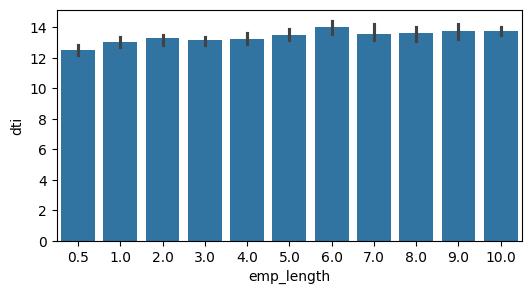

In [2810]:
plt.figure(figsize=[6,3])
sns.barplot(x='emp_length', y='dti', data=df, estimator='median')
plt.show()

DTI is very slightly increasing with employee length.

Let us check number of inquires made against various categories.

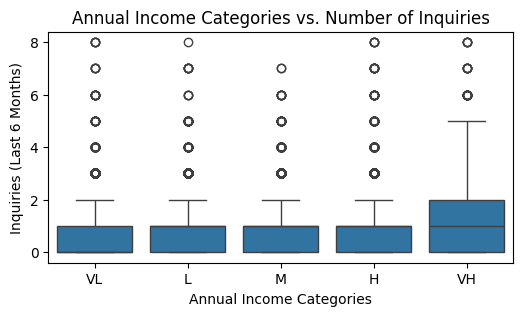

In [2811]:
# Box plot for Income categories vs. Inquiries

plt.figure(figsize=(6, 3))
sns.boxplot(data=df, x='annual_inc_category', y='inq_last_6mths')
plt.title('Annual Income Categories vs. Number of Inquiries')
plt.xlabel('Annual Income Categories')
plt.ylabel('Inquiries (Last 6 Months)')
plt.show()


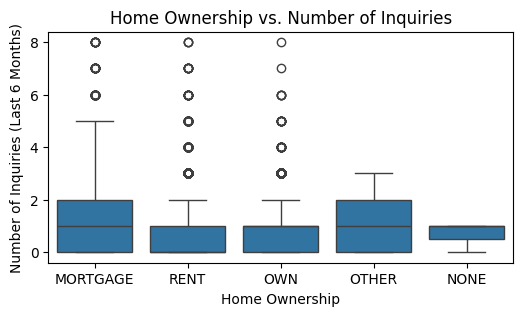

In [2812]:
plt.figure(figsize=(6, 3))
sns.boxplot(data=df, x='home_ownership', y='inq_last_6mths')
plt.title('Home Ownership vs. Number of Inquiries')
plt.xlabel('Home Ownership')
plt.ylabel('Number of Inquiries (Last 6 Months)')
plt.show()

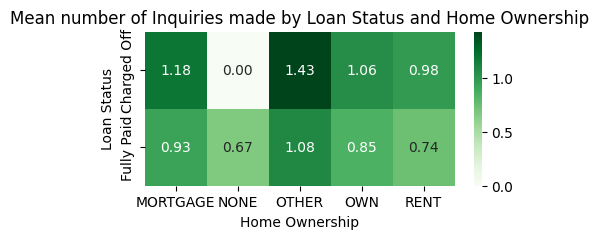

In [2813]:
pivot_table = df.pivot_table(
    index='loan_status',
    columns='home_ownership',
    values='inq_last_6mths',
    aggfunc='mean'
)

# Fill NaN values with 0 for better visualization
pivot_table.fillna(0, inplace=True)

# Plotting the heatmap
plt.figure(figsize=(5, 2))
sns.heatmap(pivot_table, cmap='Greens', annot=True, fmt='.2f')
plt.title('Mean number of Inquiries made by Loan Status and Home Ownership')
plt.ylabel('Loan Status')
plt.xlabel('Home Ownership')
plt.show()

# Derived Features

## Credit History Length

In [2814]:
x_train['earliest_cr_line'] = pd.to_datetime(x_train['earliest_cr_line'], format='%b-%Y')

# Calculate credit history length in years
x_train['credit_history_length'] = (pd.to_datetime('today') - x_train['earliest_cr_line']).dt.days / 365.25

x_train.drop(columns=['earliest_cr_line'],inplace=True)

len(x_train[x_train['credit_history_length']<0])

0

## Credit Score

**Calculating credit score:**

**Weightage on the criterion:**

Payment history: 35%

Credit utilization: 30%

Length of credit history: 15%

Credit mix: 10%

**Columns considered for each criterion:**

Payment history: 'delinq_2yrs', 'pub_rec_bankruptcies', 'total_rec_late_fee', 'collection_recovery_fee'

Credit utilization: 'revol_util'

Length of credit history: 'credit_history_length'

Credit mix: 'total_acc'

In [2815]:
from sklearn.preprocessing import MinMaxScaler

mscaler = MinMaxScaler()

# Normalize the relevant columns and create new ones
x_train[['delinq_2yrs_norm', 'pub_rec_bankruptcies_norm', 'total_rec_late_fee_norm',
    'collection_recovery_fee_norm', 'revol_util_norm', 'credit_history_length_norm',
    'total_acc_norm']] = mscaler.fit_transform(
    x_train[['delinq_2yrs', 'pub_rec_bankruptcies', 'total_rec_late_fee', 'collection_recovery_fee',
        'revol_util', 'credit_history_length', 'total_acc']]
)

# Calculate the credit score using the normalized columns
x_train['credit_score'] = (
    (1 - x_train['delinq_2yrs_norm']) * 0.35 +    # Invert since lower is better
    (1 - x_train['pub_rec_bankruptcies_norm']) * 0.35 +  # Invert
    (1 - x_train['total_rec_late_fee_norm']) * 0.35 +  # Invert
    (1 - x_train['collection_recovery_fee_norm']) * 0.35 +  # Invert
    (1 - x_train['revol_util_norm']) * 0.30 +      # Invert since lower is better
    (x_train['credit_history_length_norm'] * 0.15) +  # Keep as is
    (x_train['total_acc_norm'] * 0.10)              # Keep as is
)

# Drop the normalization columns
x_train.drop(columns=['delinq_2yrs_norm', 'pub_rec_bankruptcies_norm',
                     'total_rec_late_fee_norm', 'collection_recovery_fee_norm',
                     'revol_util_norm', 'credit_history_length_norm',
                     'total_acc_norm'], inplace=True)

# Normalize the total score to fall within [0, 1]
x_train['credit_score'] = x_train['credit_score'] / x_train['credit_score'].max()
print(x_train[['credit_score']].head(10))


   credit_score
0      0.880940
1      0.827404
2      0.887198
3      0.787506
4      0.840068
5      0.749311
6      0.841455
7      0.800738
8      0.890024
9      0.822264


## Analysis

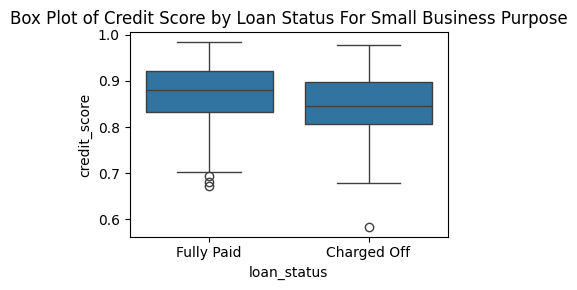

In [2816]:
x_vis=x_train.copy(deep=True)
x_vis['loan_status']=y_train

df_small_business=x_vis[x_vis['purpose']=='small_business']

plt.figure(figsize=(4, 3))

sns.boxplot(x='loan_status', y="credit_score", data=df_small_business)
plt.title(f'Box Plot of Credit Score by Loan Status For Small Business Purpose')


plt.tight_layout()
plt.show()

Key Insight:

While rejecting people taking loans for small business purpose as they had high charge off rates, it should be ensured that no opportunity is missed while rejecting a capable applicant with small business purpose from providing loan by taking care of the nuances. Adding to the criteria for applicants taking loans for small business purpose who should not be rejected from taking loans:

credit_score > 0.85

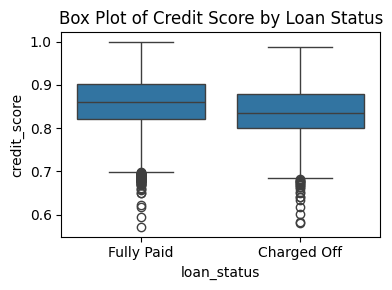

In [2817]:
plt.figure(figsize=(4, 3))
sns.boxplot(x='loan_status', y="credit_score", data=x_vis)
plt.title(f'Box Plot of Credit Score by Loan Status')


plt.tight_layout()
plt.show()

Insight: Charged Off candidates have lower credit score.

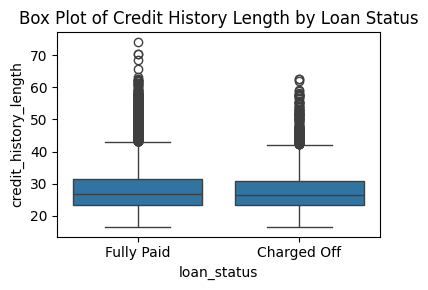

In [2818]:
plt.figure(figsize=(4, 3))

sns.boxplot(x='loan_status', y="credit_history_length", data=x_vis)
plt.title(f'Box Plot of Credit History Length by Loan Status')


plt.tight_layout()
plt.show()

# Data Preprocessing

In [2819]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30861 entries, 0 to 30860
Data columns (total 34 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   loan_amnt                30861 non-null  int64  
 1   funded_amnt              30861 non-null  int64  
 2   funded_amnt_inv          30861 non-null  float64
 3   term                     30861 non-null  object 
 4   int_rate                 30861 non-null  float64
 5   installment              30861 non-null  float64
 6   grade                    30861 non-null  object 
 7   emp_title                30861 non-null  object 
 8   emp_length               30861 non-null  float64
 9   home_ownership           30861 non-null  object 
 10  annual_inc               30861 non-null  float64
 11  verification_status      30861 non-null  object 
 12  purpose                  30861 non-null  object 
 13  addr_state               30861 non-null  object 
 14  dti                   

In [2820]:
numerical_columns = x_train.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = x_train.select_dtypes(include=['object']).columns
print("numerical columns: ",numerical_columns)
print("--"*50)
print("categorical columns: ",categorical_columns)

numerical columns:  Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
       'installment', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_amnt', 'pub_rec_bankruptcies',
       'credit_history_length', 'credit_score'],
      dtype='object')
----------------------------------------------------------------------------------------------------
categorical columns:  Index(['term', 'grade', 'emp_title', 'home_ownership', 'verification_status',
       'purpose', 'addr_state', 'Last payment made'],
      dtype='object')


In [2821]:
reqd_columns= numerical_columns.tolist()
reqd_columns.extend(categorical_columns.tolist())
print(reqd_columns)

['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'pub_rec_bankruptcies', 'credit_history_length', 'credit_score', 'term', 'grade', 'emp_title', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 'Last payment made']


## Skewness Check and Transformations

In [2822]:
# Initialize the lists for skewness classification
low_to_moderate_skew = []
high_positive_skew = []
high_negative_skew = []

In [2823]:
# Split the numerical columns into two halves
mid_index = len(numerical_columns) // 2
first_half = numerical_columns[:mid_index]
second_half = numerical_columns[mid_index:]

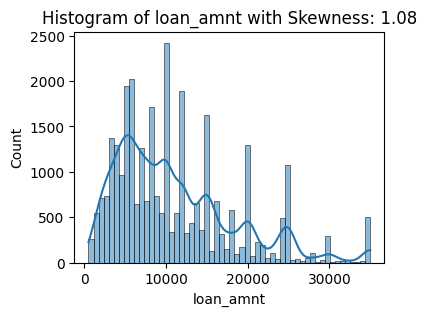

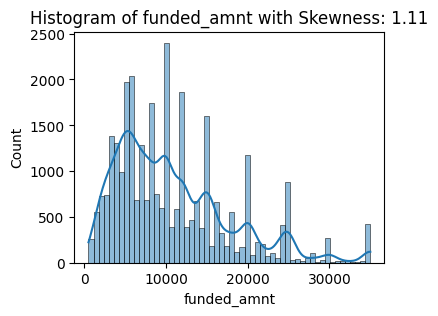

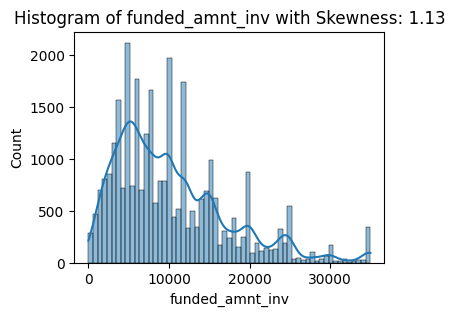

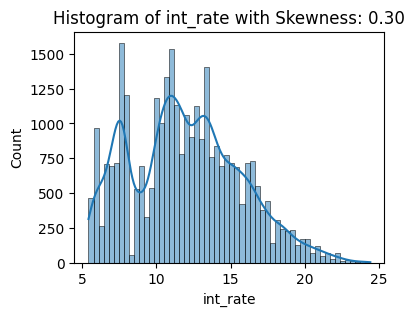

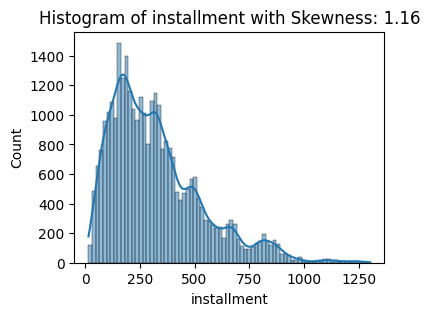

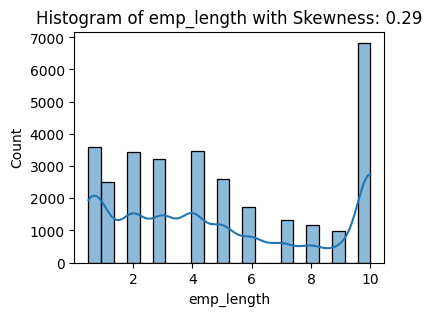

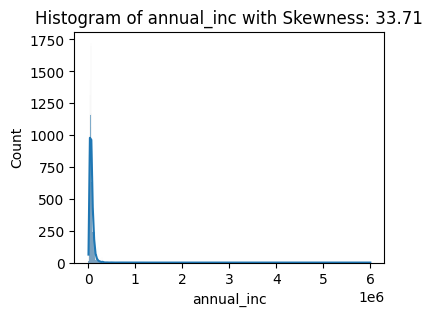

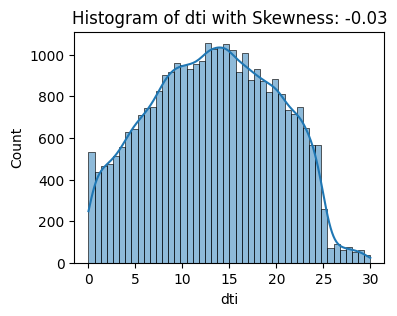

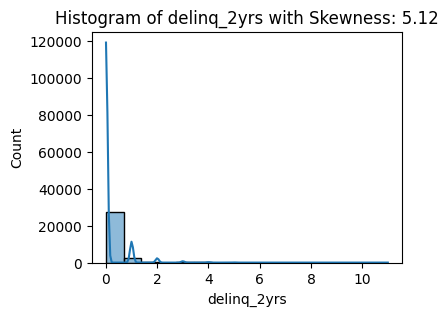

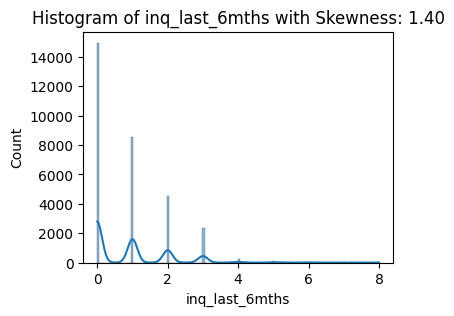

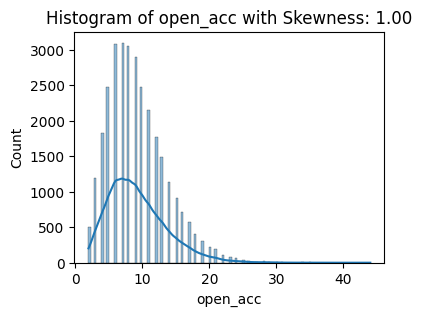

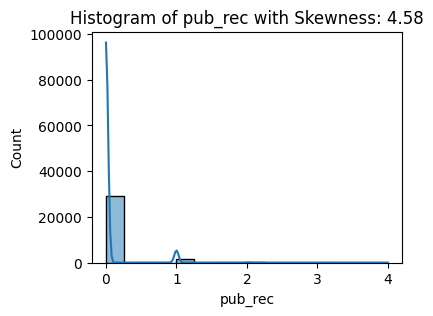

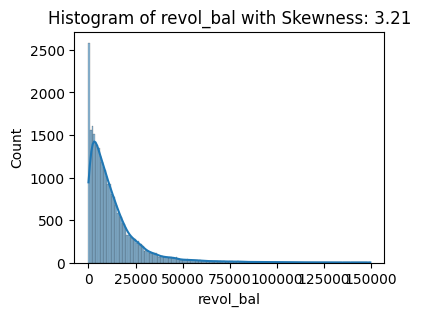

In [2824]:
# Process the first half of the columns
for col in first_half:
    # Calculate skewness
    skewness = x_train[col].skew()

    # Classify columns based on skewness
    if skewness > 1.3:
        high_positive_skew.append(col)
    elif skewness < -1.3:
        high_negative_skew.append(col)
    else:
        low_to_moderate_skew.append(col)

    # Print histogram and skewness value
    plt.figure(figsize=(4, 3))
    sns.histplot(x_train[col], kde=True)
    plt.title(f"Histogram of {col} with Skewness: {skewness:.2f}")
    plt.show()


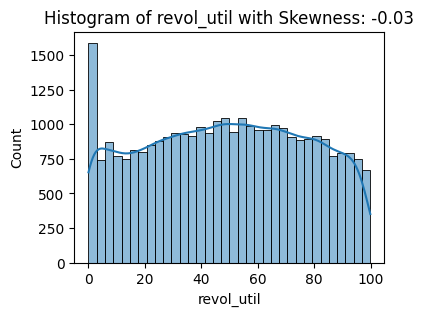

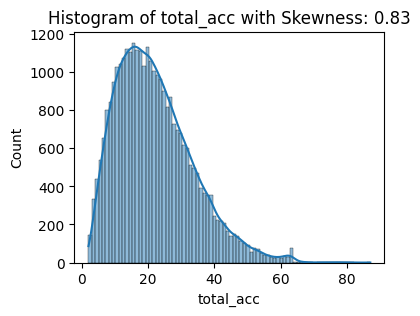

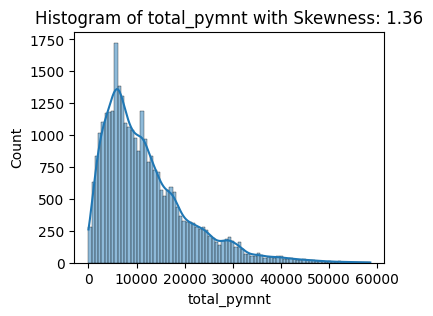

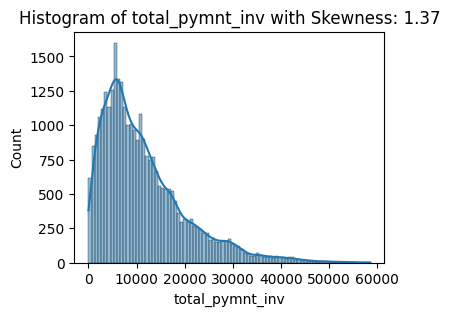

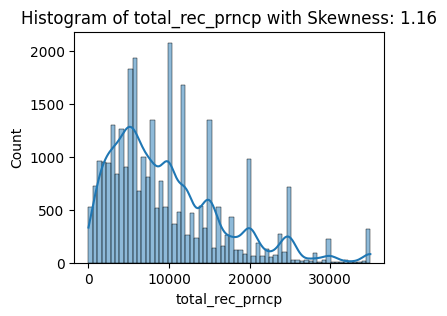

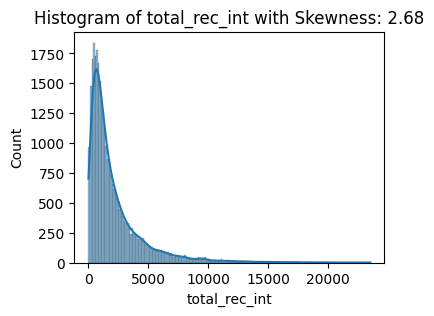

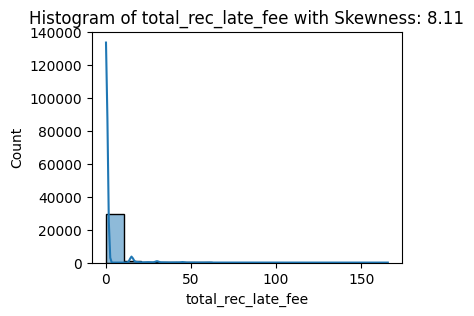

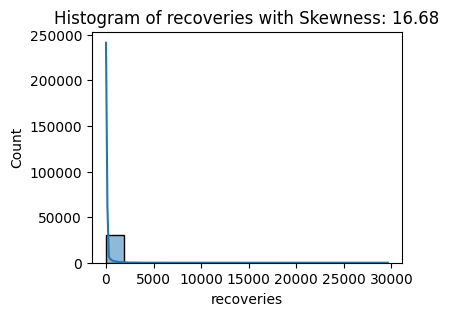

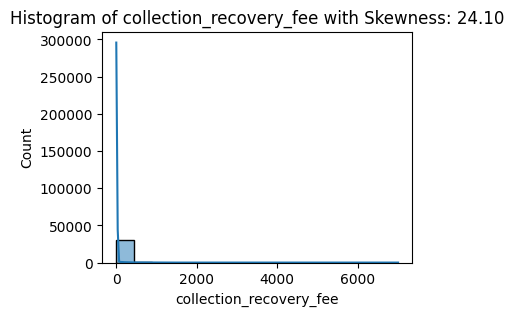

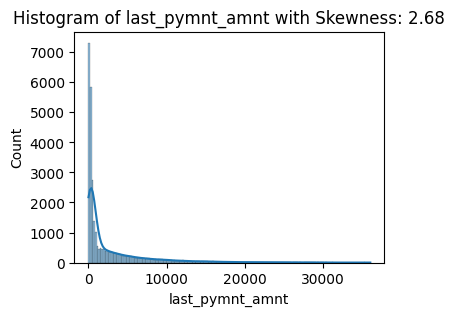

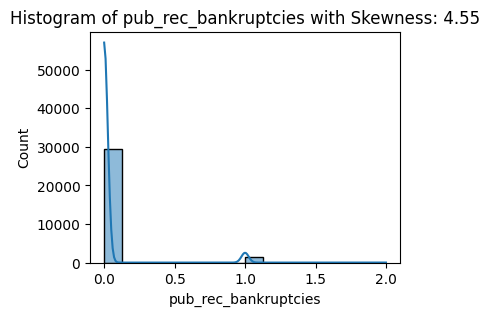

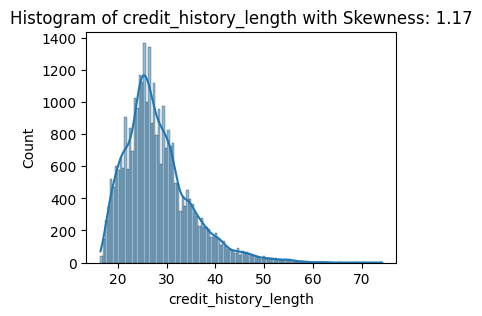

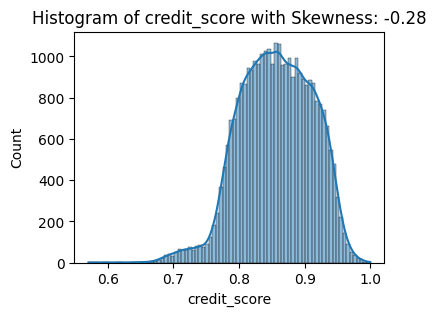

In [2825]:
# Process the second half of the columns
for col in second_half:
    # Calculate skewness
    skewness = x_train[col].skew()

    # Classify columns based on skewness
    if skewness > 1.3:
        high_positive_skew.append(col)
    elif skewness < -1.3:
        high_negative_skew.append(col)
    else:
        low_to_moderate_skew.append(col)

    # Print histogram and skewness value
    plt.figure(figsize=(4, 3))
    sns.histplot(x_train[col], kde=True)
    plt.title(f"Histogram of {col} with Skewness: {skewness:.2f}")
    plt.show()

In [2826]:
print("Low to Moderate Skew Columns:", low_to_moderate_skew)
print("High Positive Skew Columns:", high_positive_skew)
print("High Negative Skew Columns:", high_negative_skew)

Low to Moderate Skew Columns: ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'emp_length', 'dti', 'open_acc', 'revol_util', 'total_acc', 'total_rec_prncp', 'credit_history_length', 'credit_score']
High Positive Skew Columns: ['annual_inc', 'delinq_2yrs', 'inq_last_6mths', 'pub_rec', 'revol_bal', 'total_pymnt', 'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'pub_rec_bankruptcies']
High Negative Skew Columns: []


In [2827]:
collections=['collection_recovery_fee']

In [2828]:
numerical_columns=[col for col in numerical_columns if col not in collections]

As per analysis, all the high outlier collection fees were received from charged off borrowers only, so outliers imply that charged off borrowers sometimes pay high collection fees while the loan payers dont have collection fees assigned to them.

In [2829]:
# List to store columns with negative values
columns_with_negative_values = []

# Iterate through numerical columns
for col in numerical_columns:
    if (x_train[col] < 0).any():  # Check if any value is negative
        columns_with_negative_values.append(col)

# Print columns with negative values
print("Columns with negative values:", columns_with_negative_values)

Columns with negative values: []


In [2830]:
# segregating the discrete columns
discrete_cols=[col for col in high_positive_skew if df[col].nunique()<20]
discrete_cols

['delinq_2yrs', 'inq_last_6mths', 'pub_rec', 'pub_rec_bankruptcies']

In [2831]:
high_positive_skew=[col for col in high_positive_skew if col not in discrete_cols and col not in collections]
high_positive_skew

['annual_inc',
 'revol_bal',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'last_pymnt_amnt']

Log Transformation

In [2832]:
# Apply log transformation to each column in logcols
for col in high_positive_skew:
    x_train[col] = np.log(x_train[col] + 1)  # Adding 1 to avoid log(0) error



## Handling Outliers

In [2833]:
# Split the numerical columns into two halves
mid_index = len(numerical_columns) // 2
first_half = numerical_columns[:mid_index]
second_half = numerical_columns[mid_index:]

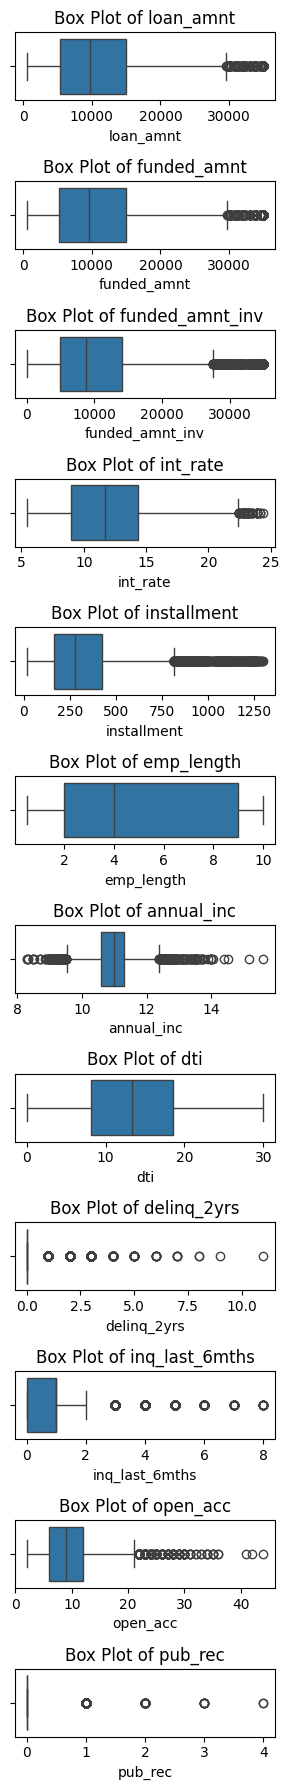

In [2834]:
# Create subplots for the first half of the columns
fig, axes = plt.subplots(len(first_half), 1, figsize=(3, 1.5 * len(first_half)))
for i, col in enumerate(first_half):
    # Box plot for first half
    sns.boxplot(data=x_train, x=col, ax=axes[i])
    axes[i].set_title(f'Box Plot of {col}')

plt.tight_layout()
plt.show()

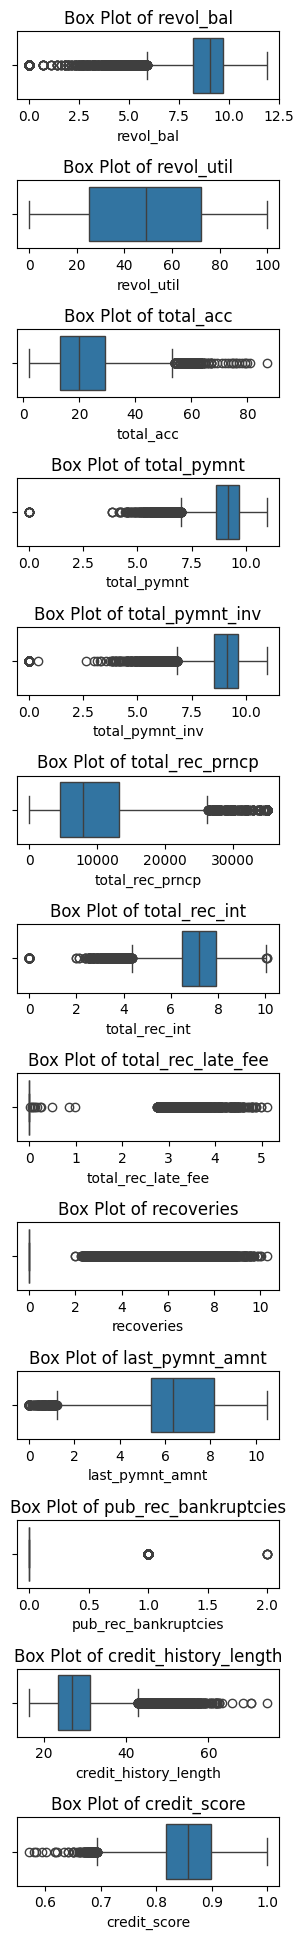

In [2835]:
# Create subplots for the second half of the columns
fig, axes = plt.subplots(len(second_half), 1, figsize=(3, 1.5 * len(second_half)))
for i, col in enumerate(second_half):
    # Box plot for second half
    sns.boxplot(data=x_train, x=col, ax=axes[i])
    axes[i].set_title(f'Box Plot of {col}')

plt.tight_layout()
plt.show()

In [2836]:
ignore_cols=['emp_length','dti','revol_util']
ignore_cols.extend(discrete_cols)
ignore_cols

['emp_length',
 'dti',
 'revol_util',
 'delinq_2yrs',
 'inq_last_6mths',
 'pub_rec',
 'pub_rec_bankruptcies']

In [2837]:
cap_cols=[col for col in numerical_columns if col not in ignore_cols]
cap_cols

['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'int_rate',
 'installment',
 'annual_inc',
 'open_acc',
 'revol_bal',
 'total_acc',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'last_pymnt_amnt',
 'credit_history_length',
 'credit_score']

In [2838]:

# Dictionary to store the 10th and 90th percentiles for each column
limits = {}

#Calculate and preserve the 10th and 90th percentiles from x_train
for col in cap_cols:
    lower_limit = x_train[col].quantile(0.10)
    upper_limit = x_train[col].quantile(0.90)
    limits[col] = (lower_limit, upper_limit)
#Cap outliers in x_train using the calculated percentiles
for col in cap_cols:
    lower_limit, upper_limit = limits[col]
    x_train[col] = x_train[col].clip(lower=lower_limit, upper=upper_limit)







In [2839]:
limits

{'loan_amnt': (3175.0, 21850.0),
 'funded_amnt': (3075.0, 20000.0),
 'funded_amnt_inv': (2840.37555, 20000.0),
 'int_rate': (7.05, 16.82),
 'installment': (99.08, 622.97),
 'annual_inc': (10.308985993422082, 11.654433707761807),
 'open_acc': (4.0, 15.0),
 'revol_bal': (7.003065458786462, 10.274085125315217),
 'total_acc': (9.0, 38.0),
 'total_pymnt': (7.974006208579107, 10.093842163613624),
 'total_pymnt_inv': (7.784444105058325, 10.060865590265314),
 'total_rec_prncp': (2100.0, 20000.0),
 'total_rec_int': (5.735862368119613, 8.496580195860377),
 'total_rec_late_fee': (0.0, 0.0),
 'recoveries': (0.0, 2.91180703861623),
 'last_pymnt_amnt': (4.563305981889393, 9.051135943446237),
 'credit_history_length': (20.396988364134156, 37.06228610540725),
 'credit_score': (0.7870713654873115, 0.9283139418610542)}

total_rec_late_fee still remain highly skewed. Also the eda did not provide any useful insight. All values from 10th to 90th percentile turned 0 on capping outliers. Hence deciding to drop.

In [2840]:
remove_cols=['total_rec_late_fee']

In [2841]:
for col in numerical_columns:
    if x_train[col].isnull().any():
        print(f"Column '{col}' has NaN values.")

In [2842]:
numerical_columns=[col for col in numerical_columns if col not in remove_cols]

## Correlation Matrix

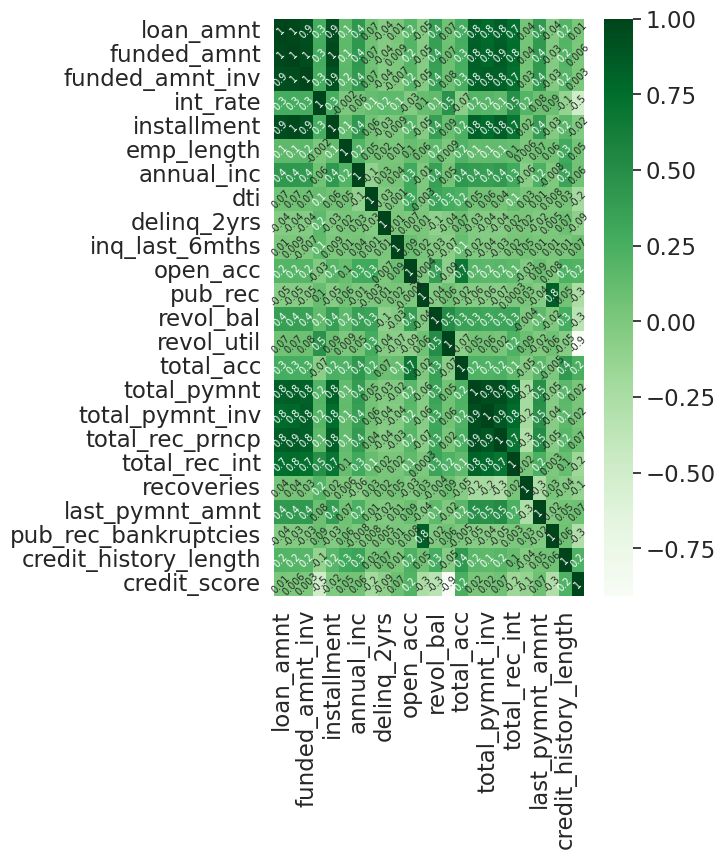

In [2843]:
#plt.figure(figsize=(10,15))
plt.figure(figsize=(5,7.5))
sns.set(font_scale=1.5)
sns.heatmap(x_train[numerical_columns].corr(),annot=True,fmt='.1g', annot_kws={"rotation": 45,"size": 7},cmap='Greens')
plt.show()

There are some columns which are showing extremely high correlations. These columns also carry related meanings. It is obvious that so much highly correlated columns will not help in prediction. We aim to remove the most obvious columns showing extreme positive correlations. Also, some columns did not provide much useful pattern in the analysis. We will proceed to further steps and later, leave it to PCA to extract the directions with most amount of information.

In [2844]:
remove_cols.extend(['funded_amnt','funded_amnt_inv','total_pymnt_inv','total_rec_prncp','pub_rec','total_rec_int','revol_util','total_acc','credit_history_length','open_acc'])
x_train.drop(columns=remove_cols,inplace=True)

## Encoding Target Column

In [2845]:
y_train = y_train.replace({"Fully Paid": 0, "Charged Off": 1})


# Verify the result
print(y_train.head())

0    0
1    1
2    0
3    0
4    0
Name: loan_status, dtype: int64


## Handling Required Integer/Numeric Columns

These columns show many outliers and skewness but these have few unique integer values.

In [2846]:
discrete_cols=['delinq_2yrs', 'inq_last_6mths', 'pub_rec_bankruptcies']

public record bankruptcies

In [2847]:
x_train['pub_rec_bankruptcies'] = x_train['pub_rec_bankruptcies'].apply(lambda x: 1 if x > 0 else 0)

In [2848]:
x_visual=x_train.copy(deep=True)
x_visual['loan_status']=y_train

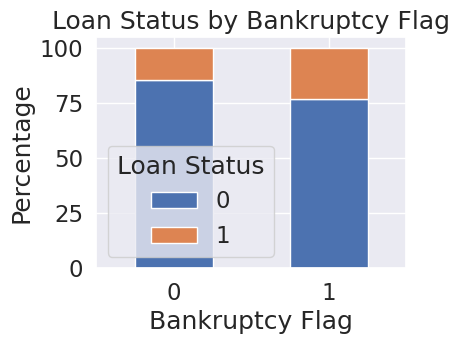

In [2849]:
# Group by bankruptcy flag and loan status, then calculate percentages
x_visual.groupby(['pub_rec_bankruptcies', 'loan_status']).size().unstack(fill_value=0).apply(lambda x: x / x.sum() * 100, axis=1).plot(kind='bar', stacked=True, figsize=(4, 3))

# Customize and display the plot
plt.title('Loan Status by Bankruptcy Flag')
plt.ylabel('Percentage')
plt.xlabel('Bankruptcy Flag')
plt.xticks(rotation=0)
plt.legend(title='Loan Status')
plt.show()

People with bankruptcies have higher chance of default.

inquiries last 6 months

In [2850]:
def custom_inq_binning(value):
    if value == 0:
        return 0
    elif value in [1, 2]:
        return 1
    elif value in [3, 4]:
        return 2
    elif value > 4:
        return 3

In [2851]:
x_train['inq_last_6mths'] = x_train['inq_last_6mths'].apply(custom_inq_binning)

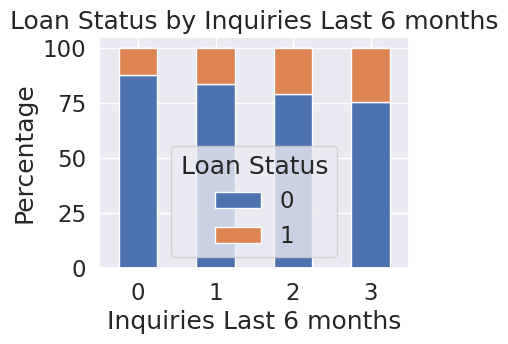

In [2852]:
x_visual=x_train.copy(deep=True)
x_visual['loan_status']=y_train

x_visual.groupby(['inq_last_6mths', 'loan_status']).size().unstack(fill_value=0).apply(lambda x: x / x.sum() * 100, axis=1).plot(kind='bar', stacked=True, figsize=(4, 3))

# Customize and display the plot
plt.title('Loan Status by Inquiries Last 6 months')
plt.ylabel('Percentage')
plt.xlabel('Inquiries Last 6 months')
plt.xticks(rotation=0)
plt.legend(title='Loan Status')
plt.show()

Clear pattern showing higher frequency of inquiries lead to higher default percentage.

delinq last 2 years

In [2853]:
x_train['delinq_2yrs'].value_counts()

delinq_2yrs
0     27453
1      2612
2       542
3       168
4        51
5        20
6         7
7         4
8         2
9         1
11        1
Name: count, dtype: int64

In [2854]:
def custom_delinq_binning(value):
    if value == 0:
        return 0
    else:
        return 1

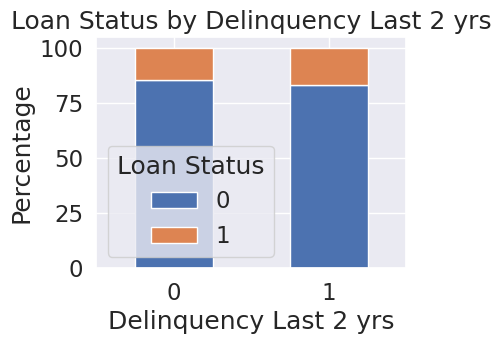

In [2855]:
x_visual['delinq_2yrs'] = x_visual['delinq_2yrs'].apply(custom_delinq_binning)


x_visual.groupby(['delinq_2yrs', 'loan_status']).size().unstack(fill_value=0).apply(lambda x: x / x.sum() * 100, axis=1).plot(kind='bar', stacked=True, figsize=(4, 3))

# Customize and display the plot
plt.title('Loan Status by Delinquency Last 2 yrs')
plt.ylabel('Percentage')
plt.xlabel('Delinquency Last 2 yrs')
plt.xticks(rotation=0)
plt.legend(title='Loan Status')
plt.show()

In [2856]:
x_train['delinq_2yrs'] = x_train['delinq_2yrs'].apply(custom_delinq_binning)

collection_recovery_fee

In [2857]:
for coll in collections:
  x_train[coll] = x_train[coll].apply(lambda x: 0 if x == 0 else 1)

In [2858]:
x_train[coll].value_counts()

collection_recovery_fee
0    27797
1     3064
Name: count, dtype: int64

In [2859]:
x_visual[coll]=x_train[coll]
x_visual.groupby(coll)['loan_status'].mean()*100

collection_recovery_fee
0      5.281145
1    100.000000
Name: loan_status, dtype: float64

## Encoding Ordinal Columns

Ordinal and binary columns

term, Last payment made, grade

In [2860]:
ordinal_cols=['term','Last payment made','grade']

In [2861]:
x_train['term'].unique()

array([' 36 months', ' 60 months'], dtype=object)

In [2862]:
x_train['term'] = x_train['term'].map({' 36 months': 0, ' 60 months': 1})
x_train['Last payment made'] = x_train['Last payment made'].map({'Paid': 1, 'Not paid': 0})

In [2863]:
grade_mapping = {
    'A': 0,
    'B': 1,
    'C': 2,
    'D': 3,
    'E': 4,
    'F': 5,
    'G': 6
}

# Apply the mapping to the 'grades' column
x_train['grade'] = x_train['grade'].map(grade_mapping)

## Handling Categorical Columns

Verification status

In [2864]:
x_train.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'revol_bal', 'total_pymnt', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'pub_rec_bankruptcies', 'Last payment made',
       'credit_score'],
      dtype='object')

In [2865]:
x_train['verification_status'].value_counts()

verification_status
Not Verified       13366
Verified            9816
Source Verified     7679
Name: count, dtype: int64

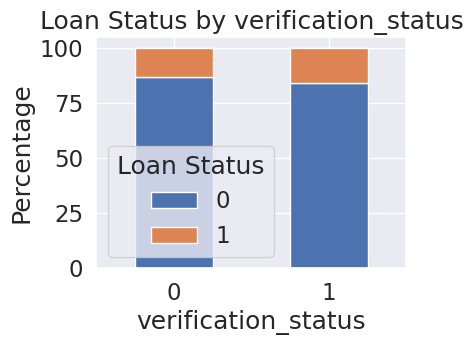

In [2866]:
x_visual['verification_status'] = x_visual['verification_status'].map({'Not Verified': 0, 'Source Verified': 1, 'Verified':1})

x_visual.groupby(['verification_status', 'loan_status']).size().unstack(fill_value=0).apply(lambda x: x / x.sum() * 100, axis=1).plot(kind='bar', stacked=True, figsize=(4, 3))

# Customize and display the plot
plt.title('Loan Status by verification_status')
plt.ylabel('Percentage')
plt.xlabel('verification_status')
plt.xticks(rotation=0)
plt.legend(title='Loan Status')
plt.show()

In [2867]:
x_train['verification_status'] = x_train['verification_status'].map({'Not Verified': 0, 'Source Verified': 1, 'Verified':1})

home ownership

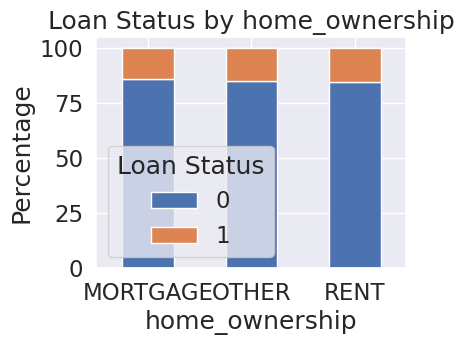

In [2868]:
x_visual['home_ownership'] = x_visual['home_ownership'].apply(lambda x: x if x in ['RENT', 'MORTGAGE'] else 'OTHER')

x_visual.groupby(['home_ownership', 'loan_status']).size().unstack(fill_value=0).apply(lambda x: x / x.sum() * 100, axis=1).plot(kind='bar', stacked=True, figsize=(4, 3))

# Customize and display the plot
plt.title('Loan Status by home_ownership')
plt.ylabel('Percentage')
plt.xlabel('home_ownership')
plt.xticks(rotation=0)
plt.legend(title='Loan Status')
plt.show()

In [2869]:
x_visual['home_ownership'].value_counts()

home_ownership
RENT        14750
MORTGAGE    13635
OTHER        2476
Name: count, dtype: int64

In [2870]:
# proportion of charged offs
x_visual.groupby('home_ownership')['loan_status'].mean() * 100

home_ownership
MORTGAGE    13.861386
OTHER       15.105008
RENT        15.376271
Name: loan_status, dtype: float64

Not much strong pattern is shown by home ownership which indicates this will not help in analysis. Hence dropping.

In [2871]:
x_train.drop(columns=['home_ownership'],inplace=True)

In [2872]:
purpose_mapping = {
    'debt_consolidation': 'Debt Consolidation',
    'credit_card': 'Credit-related',
    'other': 'Miscellaneous',
    'home_improvement': 'Home-related',
    'major_purchase': 'Major Purchases',
    'small_business': 'Business/Entrepreneurial',
    'car': 'Major Purchases',  # Merged with Major Purchases
    'wedding': 'Major Purchases',  # Merged with Major Purchases
    'medical': 'Health and Personal',  # New category
    'moving': 'Home-related',  # Merged with Home-related
    'house': 'Major Purchases',  # Merged with Major Purchases
    'vacation': 'Health and Personal',  # New category
    'educational': 'Health and Personal',  # New category
    'renewable_energy': 'Miscellaneous'  # Merged with Other
}

x_train['purpose'] = x_train['purpose'].map(purpose_mapping)

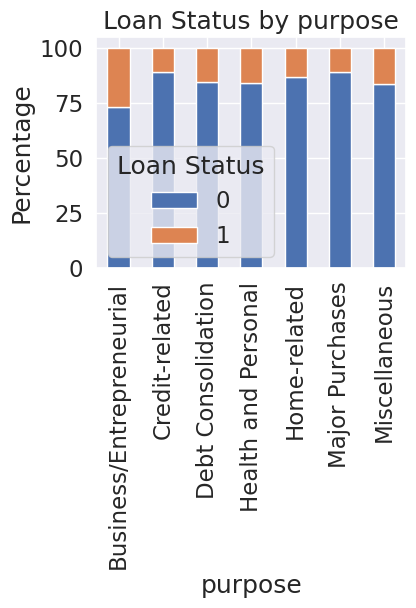

In [2873]:
x_visual=x_train.copy(deep=True)
x_visual['loan_status']=y_train

x_visual.groupby(['purpose', 'loan_status']).size().unstack(fill_value=0).apply(lambda x: x / x.sum() * 100, axis=1).plot(kind='bar', stacked=True, figsize=(4, 3))

# Customize and display the plot
plt.title('Loan Status by purpose')
plt.ylabel('Percentage')
plt.xlabel('purpose')
plt.xticks(rotation=90)
plt.legend(title='Loan Status')
plt.show()

In [2874]:
x_visual['purpose'].value_counts()

purpose
Debt Consolidation          14448
Credit-related               4019
Major Purchases              3944
Miscellaneous                3183
Home-related                 2759
Business/Entrepreneurial     1406
Health and Personal          1102
Name: count, dtype: int64

Mapping teh categories to fewer categories

In [2875]:
purpose_mapping2 = {
    'Debt Consolidation': 'Debt Consolidation',
    'Credit-related': 'Credit-related/Major Purchases',
    'Major Purchases': 'Credit-related/Major Purchases',
    'Business/Entrepreneurial': 'Business/Entrepreneurial',
    'Health and Personal': 'Personal/Miscellaneous',
    'Home-related': 'Personal/Miscellaneous',
    'Miscellaneous': 'Personal/Miscellaneous'
}

x_train['purpose'] = x_train['purpose'].map(purpose_mapping2)

In [2876]:
x_train['purpose'].value_counts()

purpose
Debt Consolidation                14448
Credit-related/Major Purchases     7963
Personal/Miscellaneous             7044
Business/Entrepreneurial           1406
Name: count, dtype: int64

In [2877]:
x_visual['purpose']=x_train['purpose']
x_visual['purpose'].value_counts()

purpose
Debt Consolidation                14448
Credit-related/Major Purchases     7963
Personal/Miscellaneous             7044
Business/Entrepreneurial           1406
Name: count, dtype: int64

In [2878]:
x_visual.groupby('purpose')['loan_status'].mean()*100

purpose
Business/Entrepreneurial          26.671408
Credit-related/Major Purchases    10.938089
Debt Consolidation                15.400055
Personal/Miscellaneous            15.062465
Name: loan_status, dtype: float64

In [2879]:
purpose_mapping3 = {
    'Debt Consolidation': 'Debt Consolidation',
    'Credit-related/Major Purchases': 'Personal/Miscellaneous',
    'Business/Entrepreneurial': 'Business/Entrepreneurial',
    'Personal/Miscellaneous': 'Personal/Miscellaneous'
}

x_train['purpose'] = x_train['purpose'].map(purpose_mapping3)

In [2880]:
x_visual['purpose']=x_train['purpose']
x_visual['purpose'].value_counts()

purpose
Personal/Miscellaneous      15007
Debt Consolidation          14448
Business/Entrepreneurial     1406
Name: count, dtype: int64

In [2881]:
x_visual.groupby('purpose')['loan_status'].mean()*100

purpose
Business/Entrepreneurial    26.671408
Debt Consolidation          15.400055
Personal/Miscellaneous      12.873992
Name: loan_status, dtype: float64

In [2882]:
x_train['emp_title'].value_counts()

emp_title
Other                             27512
Unknown                            1940
US Army                             222
US Air Force                        107
Bank of America                      89
US Postal Service                    71
Walmart                              63
JP Morgan Chase                      62
United Parcel Service                61
IBM                                  53
Self                                 52
AT&T                                 50
Kaiser Permanente                    47
Wells Fargo                          41
Self Employed                        36
Walgreens                            33
Verizon Wireless                     32
Lockheed Martin                      32
State of California                  29
US Navy                              28
Department of Defense                27
Verizon                              26
Fidelity Investments                 25
Accenture                            25
Target                               25
Northrop Grumman                     24
Booz Allen Hamilton                  23
Comcast                              22
Wells Fargo Bank                     21
Best Buy                             21
Social Security Administration       21
Home Depot                           21
General Electric                     20
Name: count, dtype: int64

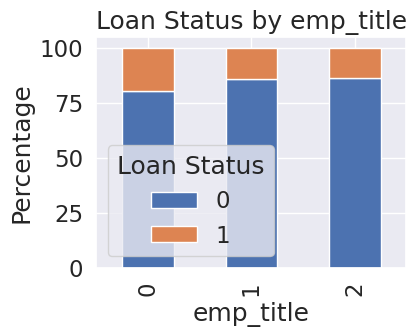

In [2883]:
x_visual['emp_title'] = x_visual['emp_title'].apply(lambda x: 0 if x == 'Unknown' else (1 if x == 'Other' else 2))
x_visual['loan_status']=y_train

x_visual.groupby(['emp_title', 'loan_status']).size().unstack(fill_value=0).apply(lambda x: x / x.sum() * 100, axis=1).plot(kind='bar', stacked=True, figsize=(4, 3))

# Customize and display the plot
plt.title('Loan Status by emp_title')
plt.ylabel('Percentage')
plt.xlabel('emp_title')
plt.xticks(rotation=90)
plt.legend(title='Loan Status')
plt.show()

In [2884]:
x_visual['emp_title'].value_counts()

emp_title
1    27512
0     1940
2     1409
Name: count, dtype: int64

In [2885]:
x_visual.groupby('emp_title')['loan_status'].mean()*100

emp_title
0    19.690722
1    14.382815
2    13.697658
Name: loan_status, dtype: float64

People with "other" profession and people with self employment/ private/ govt jobs have same percentage of charge offs. People with unknown profession have higher charge offs. So it all depends on whether a person's profession is known or not known.Unknown profession also strongly implies the people do not have a profession at all, so cannot pay loans.

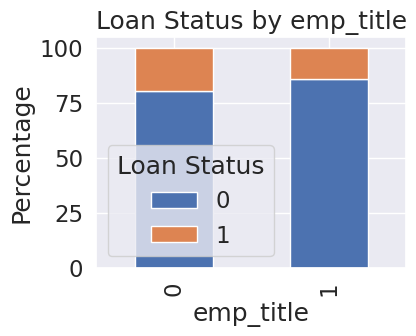

In [2886]:
x_visual['emp_title'] = x_visual['emp_title'].apply(lambda x: 0 if x == 0 else 1)
x_visual['loan_status']=y_train

x_visual.groupby(['emp_title', 'loan_status']).size().unstack(fill_value=0).apply(lambda x: x / x.sum() * 100, axis=1).plot(kind='bar', stacked=True, figsize=(4, 3))

# Customize and display the plot
plt.title('Loan Status by emp_title')
plt.ylabel('Percentage')
plt.xlabel('emp_title')
plt.xticks(rotation=90)
plt.legend(title='Loan Status')
plt.show()

Making emp_title a binary column


In [2887]:
x_train['emp_title'] = x_train['emp_title'].apply(lambda x: 0 if x == "Unknown" else 1)

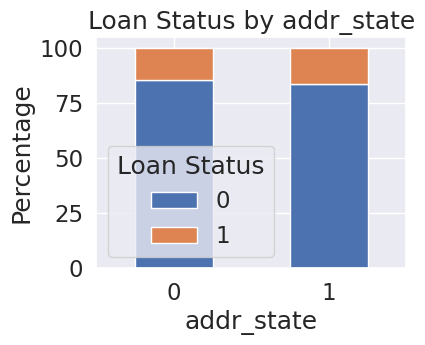

In [2888]:
x_visual['addr_state']=x_visual['addr_state'].apply(lambda x: 1 if x=='CA' else 0)

x_visual.groupby(['addr_state', 'loan_status']).size().unstack(fill_value=0).apply(lambda x: x / x.sum() * 100, axis=1).plot(kind='bar', stacked=True, figsize=(4, 3))

# Customize and display the plot
plt.title('Loan Status by addr_state')
plt.ylabel('Percentage')
plt.xlabel('addr_state')
plt.xticks(rotation=0)
plt.legend(title='Loan Status')
plt.show()

Address States do not show any strong pattern, Else dropping it.

In [2889]:
x_train.drop(columns=['addr_state'],inplace=True)

# Data Preparation

In [2618]:
x_train.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30861 entries, 0 to 30860
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   loan_amnt                30861 non-null  int64  
 1   term                     30861 non-null  int64  
 2   int_rate                 30861 non-null  float64
 3   installment              30861 non-null  float64
 4   grade                    30861 non-null  int64  
 5   emp_title                30861 non-null  int64  
 6   emp_length               30861 non-null  float64
 7   annual_inc               30861 non-null  float64
 8   verification_status      30861 non-null  int64  
 9   purpose                  30861 non-null  object 
 10  dti                      30861 non-null  float64
 11  delinq_2yrs              30861 non-null  int64  
 12  inq_last_6mths           30861 non-null  int64  
 13  revol_bal                30861 non-null  float64
 14  total_pymnt           

In [2619]:
categorical_columns = x_train.select_dtypes(include=['object']).columns.tolist()
categorical_columns

['purpose']

In [2620]:
ordinal_cols

['term', 'Last payment made', 'grade']

In [2621]:
ordinal_cols.extend(['verification_status','emp_title'])

In [2622]:
discrete_cols

['delinq_2yrs', 'inq_last_6mths', 'pub_rec_bankruptcies']

In [2623]:
discrete_cols.extend(['collection_recovery_fee'])

In [2624]:
numerical_columns=[col for col in numerical_columns if col not in discrete_cols and col not in remove_cols]
numerical_columns

['loan_amnt',
 'int_rate',
 'installment',
 'emp_length',
 'annual_inc',
 'dti',
 'revol_bal',
 'total_pymnt',
 'recoveries',
 'last_pymnt_amnt',
 'credit_score']

In [2625]:
reqd_cols=ordinal_cols+discrete_cols+numerical_columns+categorical_columns
len(reqd_cols)

21

In [2626]:
reqd_cols

['term',
 'Last payment made',
 'grade',
 'verification_status',
 'emp_title',
 'delinq_2yrs',
 'inq_last_6mths',
 'pub_rec_bankruptcies',
 'collection_recovery_fee',
 'loan_amnt',
 'int_rate',
 'installment',
 'emp_length',
 'annual_inc',
 'dti',
 'revol_bal',
 'total_pymnt',
 'recoveries',
 'last_pymnt_amnt',
 'credit_score',
 'purpose']

In [2627]:
order_columns = [col for col in x_train.columns if col in reqd_cols]

## Standardizing , One hot Encoding

In [2628]:
scaler = StandardScaler()

x_train_transformed=x_train.copy(deep=True)

x_train_transformed[numerical_columns] = scaler.fit_transform(x_train_transformed[numerical_columns])

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

x_train_ohe = ohe.fit_transform(x_train_transformed[categorical_columns])

cols_ohe = ohe.get_feature_names_out(categorical_columns)
print(cols_ohe)

x_train_ohe = pd.DataFrame(x_train_ohe, columns=cols_ohe, index=x_train_transformed.index)


x_train_transformed.drop(columns=categorical_columns,inplace=True)

x_train_transformed2 = pd.concat([x_train_transformed, x_train_ohe], axis=1)

['purpose_Business/Entrepreneurial' 'purpose_Debt Consolidation'
 'purpose_Personal/Miscellaneous']


In [2629]:
xstore=x_train.copy(deep=True)
ystore=y_train.copy(deep=True)

In [2630]:
y_train.value_counts()

loan_status
0    26329
1     4532
Name: count, dtype: int64

# Test Data Preparation

In [2636]:
df_test=pd.read_csv('df_test.csv')
x_test=df_test.drop(columns=['loan_status'])
y_test=df_test['loan_status']

In [2637]:
x_test.shape, y_test.shape

((7716, 110), (7716,))

## Basic Handling

In [2638]:
# converting int_rate to float

x_test['int_rate']=x_test['int_rate'].str.rstrip('%').astype('float')
print(x_test['int_rate'].dtype)
print(x_test['int_rate'].head(10))

# revol util to float
x_test['revol_util']=x_test['revol_util'].str.rstrip('%').astype(float)
print(x_test['revol_util'].dtype)
print(x_test['revol_util'].head(10))


# emp length
x_test['emp_length']=x_test['emp_length'].str.replace('years','')
x_test['emp_length']=x_test['emp_length'].str.replace('year','')
x_test['emp_length']=x_test['emp_length'].str.replace('+','')
x_test['emp_length']=x_test['emp_length'].str.replace('< 1','0.5')
x_test['emp_length']=x_test['emp_length'].astype('float')
print(x_test['emp_length'].dtype)
print(x_test['emp_length'].value_counts)



# drop uniq cols
x_test.drop(columns=cols_uniq1,inplace=True)
x_test.shape


# drop
x_test.drop(columns=['url','desc','zip_code','title','id','member_id'],inplace=True)
x_test.shape


# emp title
x_test['emp_title']=x_test['emp_title'].fillna('Unknown')


# last payment date
x_test['last_pymnt_d']=x_test['last_pymnt_d'].fillna('Not paid')


# credit pull date
x_test['last_credit_pull_d']=x_test['last_credit_pull_d'].fillna(credit_pull_mode)


# check cat nulls in xtest
for col in catcols:
  print(col,"--->  ",x_test[col].isnull().sum()/len(x_test)*100,"%")



# pub rec bankruptcies
x_test['pub_rec_bankruptcies']=x_test['pub_rec_bankruptcies'].fillna(0)



# impute in num cols
for col in ['emp_length', 'revol_util']:
    x_test[col] = x_test[col].fillna(medians[col])



# checking null values in numerical columns

for col in numcols:
  if col in x_test.columns:
    print(col,"--->  ",x_test[col].isnull().sum()/len(x_test)*100,"%")



# issue d
x_test['issue_dd'] = pd.to_datetime(x_test['issue_d'], format='%b-%y')

# Apply the function to create a new adjusted column
x_test['earliest_cr_line'] = x_test.apply(adjust_earliest_cr_line, axis=1)




# earliest credit length hist
x_test['earliest_cr_line'] = pd.to_datetime(x_test['earliest_cr_line'], format='%b-%Y')

# Calculate credit history length in years
x_test['credit_history_length'] = (pd.to_datetime('today') - x_test['earliest_cr_line']).dt.days / 365.25
len(x_test[x_test['credit_history_length']<0])


# credit score

# Normalize the relevant columns and create new ones
x_test[['delinq_2yrs_norm', 'pub_rec_bankruptcies_norm', 'total_rec_late_fee_norm',
    'collection_recovery_fee_norm', 'revol_util_norm', 'credit_history_length_norm',
    'total_acc_norm']] = mscaler.transform(
    x_test[['delinq_2yrs', 'pub_rec_bankruptcies', 'total_rec_late_fee', 'collection_recovery_fee',
        'revol_util', 'credit_history_length', 'total_acc']]
)

# Calculate the credit score using the normalized columns
x_test['credit_score'] = (
    (1 - x_test['delinq_2yrs_norm']) * 0.35 +    # Invert since lower is better
    (1 - x_test['pub_rec_bankruptcies_norm']) * 0.35 +  # Invert
    (1 - x_test['total_rec_late_fee_norm']) * 0.35 +  # Invert
    (1 - x_test['collection_recovery_fee_norm']) * 0.35 +  # Invert
    (1 - x_test['revol_util_norm']) * 0.30 +      # Invert since lower is better
    (x_test['credit_history_length_norm'] * 0.15) +  # Keep as is
    (x_test['total_acc_norm'] * 0.10)              # Keep as is
)

# Drop the normalization columns
x_test.drop(columns=['delinq_2yrs_norm', 'pub_rec_bankruptcies_norm',
                 'total_rec_late_fee_norm', 'collection_recovery_fee_norm',
                 'revol_util_norm', 'credit_history_length_norm',
                 'total_acc_norm'], inplace=True)

# Normalize the total score to fall within [0, 1]
x_test['credit_score'] = x_test['credit_score'] / x_test['credit_score'].max()
print(x_test[['credit_score']].head(10))



# emptitle category
# categorizing emp_title in x_test
x_test['emp_title'] = x_test['emp_title'].replace({'walmart': 'Walmart','WALMART': 'Walmart','WalMart': 'Walmart'})
x_test['emp_title'] = x_test['emp_title'].replace({'self': 'Self'})
x_test['emp_title'] = x_test['emp_title'].replace({'U.S. Army': 'US Army','US ARMY':'US Army','us army':'US Army','United States Army':'US Army'})
x_test['emp_title'] = x_test['emp_title'].replace({'United States Postal Service':'US Postal Service','USPS':'US Postal Service'})
x_test['emp_title'] = x_test['emp_title'].replace({'USAF':'US Air Force','United States Air Force':'US Air Force'})
x_test['emp_title'] = x_test['emp_title'].replace({'UPS':'United Parcel Service'})
x_test['emp_title'] = x_test['emp_title'].replace({'JPMorgan Chase':'JP Morgan Chase'})



x_test['emp_title'] = x_test['emp_title'].apply(lambda x: x if x in valid_emptitles else 'Other')


x_test['Last payment made']=np.where(x_test['last_pymnt_d']=='Not paid','Not paid','Paid')
x_test.drop(columns=['last_pymnt_d'],inplace=True)


x_test.drop(columns=['issue_dd','issue_d'],inplace=True)



x_test=x_test[reqd_columns]



float64
0    10.78
1     6.91
2    11.83
3     7.51
4    20.30
5    19.69
6     8.94
7    11.14
8     6.99
9    10.99
Name: int_rate, dtype: float64
float64
0    33.8
1    66.0
2    90.8
3    50.7
4    92.2
5    74.0
6    16.1
7    14.2
8    13.8
9    70.0
Name: revol_util, dtype: float64
float64
<bound method IndexOpsMixin.value_counts of 0        0.5
1       10.0
2        0.5
3        0.5
4       10.0
        ... 
7711     1.0
7712    10.0
7713     9.0
7714    10.0
7715     0.5
Name: emp_length, Length: 7716, dtype: float64>
term --->   0.0 %
grade --->   0.0 %
sub_grade --->   0.0 %
emp_title --->   0.0 %
home_ownership --->   0.0 %
verification_status --->   0.0 %
issue_d --->   0.0 %
purpose --->   0.0 %
addr_state --->   0.0 %
earliest_cr_line --->   0.0 %
last_pymnt_d --->   0.0 %
last_credit_pull_d --->   0.0 %
loan_amnt --->   0.0 %
funded_amnt --->   0.0 %
funded_amnt_inv --->   0.0 %
int_rate --->   0.0 %
installment --->   0.0 %
emp_length --->   0.0 %
annual_inc --->   0.0

## Transformation

In [2639]:
high_positive_skew

['annual_inc',
 'revol_bal',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'last_pymnt_amnt']

In [2640]:
# log transformation
for col in high_positive_skew:
    x_test[col] = np.log(x_test[col] + 1)

## Handling Outliers

In [2641]:
# outlier capping
#Cap outliers in x_test using the same limits from x_train
for col in cap_cols:
    lower_limit, upper_limit = limits[col]
    x_test[col] = x_test[col].clip(lower=lower_limit, upper=upper_limit)

## Encoding Columns

In [2642]:
x_test['pub_rec_bankruptcies'] = x_test['pub_rec_bankruptcies'].apply(lambda x: 1 if x > 0 else 0)
x_test['inq_last_6mths'] = x_test['inq_last_6mths'].apply(custom_inq_binning)
x_test['delinq_2yrs'] = x_test['delinq_2yrs'].apply(custom_delinq_binning)

for coll in collections:
  x_test[coll] = x_test[coll].apply(lambda x: 0 if x == 0 else 1)

x_test['term'] = x_test['term'].map({' 36 months': 0, ' 60 months': 1})
x_test['Last payment made'] = x_test['Last payment made'].map({'Paid': 1, 'Not paid': 0})
x_test['grade'] = x_test['grade'].map(grade_mapping)
x_test['verification_status'] = x_test['verification_status'].map({'Not Verified': 0, 'Source Verified': 1, 'Verified':1})
x_test['emp_title'] = x_test['emp_title'].apply(lambda x: 0 if x == "Unknown" else 1)


x_test['purpose'] = x_test['purpose'].map(purpose_mapping)
x_test['purpose'] = x_test['purpose'].map(purpose_mapping2)
x_test['purpose'] = x_test['purpose'].map(purpose_mapping3)

y_test = y_test.replace({"Fully Paid": 0, "Charged Off": 1})

In [2643]:
x_test = x_test[reqd_cols]
x_test = x_test[order_columns]

In [2644]:
reqd_cols

['term',
 'Last payment made',
 'grade',
 'verification_status',
 'emp_title',
 'delinq_2yrs',
 'inq_last_6mths',
 'pub_rec_bankruptcies',
 'collection_recovery_fee',
 'loan_amnt',
 'int_rate',
 'installment',
 'emp_length',
 'annual_inc',
 'dti',
 'revol_bal',
 'total_pymnt',
 'recoveries',
 'last_pymnt_amnt',
 'credit_score',
 'purpose']

In [2645]:
x_test.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'emp_title',
       'emp_length', 'annual_inc', 'verification_status', 'purpose', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'revol_bal', 'total_pymnt',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt',
       'pub_rec_bankruptcies', 'Last payment made', 'credit_score'],
      dtype='object')

## Standardize, OnehotEncode

In [2646]:
# Apply scaling to numerical columns in x_test using the same scaler fitted on x_train
x_test_transformed = x_test.copy(deep=True)

# Scale numerical columns in x_test based on the x_train scaler
x_test_transformed[numerical_columns] = scaler.transform(x_test_transformed[numerical_columns])

# One-hot encode categorical columns in x_test using the same OneHotEncoder fitted on x_train
x_test_ohe = ohe.transform(x_test_transformed[categorical_columns])

# Get the column names from the OneHotEncoder for x_test (it will match the columns from x_train)
cols_ohe = ohe.get_feature_names_out(categorical_columns)

# Convert the result into a DataFrame with proper column names and the same index as x_test
x_test_ohe = pd.DataFrame(x_test_ohe, columns=cols_ohe, index=x_test_transformed.index)

# Drop the categorical columns from x_test
x_test_transformed.drop(columns=categorical_columns, inplace=True)

# Concatenate the transformed numerical data with the one-hot encoded categorical data
x_test_transformed2 = pd.concat([x_test_transformed, x_test_ohe], axis=1)

# Check the result
print(x_test_transformed2.head())


   loan_amnt  term  int_rate  installment  grade  emp_title  emp_length  \
0  -1.233442     0 -0.322330    -1.254296      2          1   -1.305595   
1   1.808759     0 -1.483193     0.616152      0          1    1.459381   
2  -0.271661     0  0.004455    -0.071501      1          1   -1.305595   
3  -1.097224     0 -1.340030    -1.103603      0          1   -1.305595   
4   1.606496     1  1.557458     1.383814      4          1    1.459381   

   annual_inc  verification_status       dti  ...  total_pymnt  recoveries  \
0   -0.980883                    0  0.235153  ...    -1.689699   -0.351788   
1    0.821732                    1  1.554821  ...     0.690836   -0.351788   
2    0.493596                    0  0.933977  ...     0.238630   -0.351788   
3    0.257618                    1  0.734527  ...    -1.150778   -0.351788   
4    0.793655                    1  1.614806  ...     1.440827   -0.351788   

   collection_recovery_fee  last_pymnt_amnt  pub_rec_bankruptcies  \
0          

In [2647]:
x_test_transformed2.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'emp_title',
       'emp_length', 'annual_inc', 'verification_status', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'revol_bal', 'total_pymnt', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_amnt', 'pub_rec_bankruptcies',
       'Last payment made', 'credit_score', 'purpose_Business/Entrepreneurial',
       'purpose_Debt Consolidation', 'purpose_Personal/Miscellaneous'],
      dtype='object')

# PCA

In [2651]:
len(numerical_columns)

11

In [2652]:
numdata = x_train_transformed2[numerical_columns]

In [2653]:
pca2 = PCA(random_state=42)

In [2654]:
pca2.fit(numdata)

PCA(random_state=42)

Scree Plot

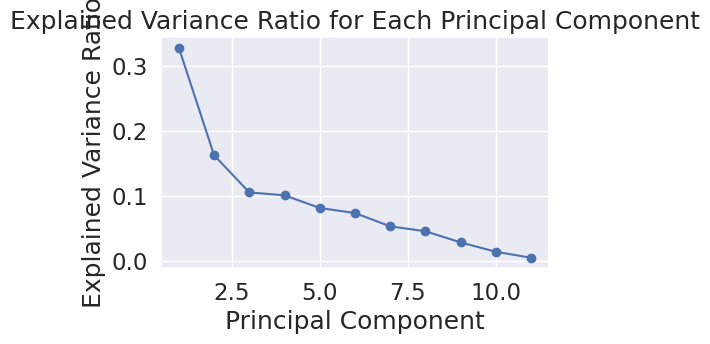

In [2655]:
explained_variance_ratio = pca2.explained_variance_ratio_

plt.figure(figsize=(5, 3))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.title('Explained Variance Ratio for Each Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

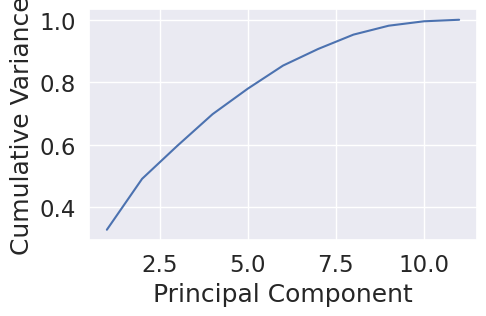

In [2656]:
var_cumu2 = np.cumsum(pca2.explained_variance_ratio_)
plt.figure(figsize=(5, 3))
plt.plot(range(1,len(var_cumu2)+1), var_cumu2)
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Variance')
plt.show()

In [2657]:
var_cumu2[6],var_cumu2[7],var_cumu2[8],var_cumu2[9], var_cumu2[10]

(0.906693638317492,
 0.952439428909079,
 0.9809498766311142,
 0.9950806299288002,
 0.9999999999999999)

In [2658]:
pc3 = IncrementalPCA(n_components=8)
newdata = pc3.fit_transform(numdata)
df = pd.DataFrame(newdata, columns=[f"PC{i}" for i in range(1,9)])
df.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  0.290372  0.158705  0.375743  0.715393 -0.446434 -0.540738 -0.273299   
1  1.663854 -2.853124 -1.565676  0.030503  2.173048 -0.211907  1.235050   
2 -0.155185  0.616381  1.218116  0.431181 -0.561173  1.241527  0.762305   
3 -0.948476 -1.305607  0.252678 -1.379180 -1.433855  0.859165  0.780836   
4  0.485233 -0.688744  0.778814 -0.069689  0.162776 -0.712597 -0.463430   

        PC8  
0  1.184431  
1  0.122421  
2 -0.035484  
3 -0.761403  
4  0.337839

In [2659]:
numdata_test = x_test_transformed2[numerical_columns]

In [2660]:
x_test_pca2 = pc3.transform(numdata_test)

In [2661]:
dftest = pd.DataFrame(x_test_pca2, columns=[f"PC{i}" for i in range(1,9)])
dftest.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -2.208029  0.177216  0.764239 -1.166461  0.277713 -0.442687  1.213528   
1  2.489117  0.219472  2.079548  0.839736  0.596914  0.340220  0.424443   
2  0.339252 -1.182538  0.742913 -1.210275 -0.069657 -1.158642  0.327777   
3 -1.471921  0.284744  1.397662 -0.866428  0.211639 -1.190325  1.521262   
4  3.853533 -1.669663  1.138142 -0.188128 -0.572178  1.187515  0.304276   

        PC8  
0 -0.151469  
1 -0.646424  
2  0.142048  
3 -0.087742  
4  0.193511

# Merging data with categorical columns

Train

In [2662]:
x_train_transformed2.drop(columns=numerical_columns,inplace=True)

x_train_transformed2= x_train_transformed2.reset_index(drop=True)
df = df.reset_index(drop=True)

x_train_final = pd.concat([x_train_transformed2, df], axis=1)

In [2663]:
x_train_final.shape, y_train.shape

((30861, 20), (30861,))

Test

In [2664]:
x_test_store=x_test_transformed2.copy(deep=True)
x_test_transformed2.drop(columns=numerical_columns,inplace=True)

x_test_transformed2 = x_test_transformed2.reset_index(drop=True)
dftest = dftest.reset_index(drop=True)
x_test_final = pd.concat([x_test_transformed2, dftest], axis=1)

In [2665]:
x_test_final.shape, y_test.shape

((7716, 20), (7716,))

# Model Building

## Custom Functions

In [2666]:
def print_confusion_matrix(xx,yy,model):
  # Predict using the trained model
  y_pred = model.predict(xx)

  # Confusion Matrix
  cm = confusion_matrix(yy, y_pred)

  # Display Confusion Matrix as a heatmap
  plt.figure(figsize=(3, 2))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted Labels')
  plt.ylabel('Actual Labels')
  plt.show()

  # Precision
  precision = precision_score(yy, y_pred, average='binary')  # For binary classification
  print(f"Precision: {precision:.4f}")

  # Recall
  recall = recall_score(yy, y_pred, average='binary')  # For binary classification
  print(f"Recall (Sensitivity): {recall:.4f}")


  # F1 score
  f1 = f1_score(yy, y_pred)
  print(f"F1 Score: {f1}")

  # Specificity
  TN, FP, FN, TP = cm.ravel()
  specificity = TN / (TN + FP)
  print(f"Specificity: {specificity:.4f}")

In [2667]:
def roc(xx,yy,model):
  fpr, tpr, thresholds = roc_curve(yy, model.predict_proba(xx)[:, 1])
  roc_auc = auc(fpr, tpr)


  plt.figure(figsize=(4, 3))
  plt.plot(fpr, tpr, color='green', label=f'ROC Curve (AUC = {roc_auc:.4f})')
  plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate (Sensitivity)')
  plt.legend(loc='lower right')
  plt.show()

## RandomForest

For class imbalance handling, setting 'class_weight':'balanced'

In [2681]:
rf_model = RandomForestClassifier()

param_grid = {
    'max_depth': [2,3],
    'min_samples_split': [1000,2000],
    'min_samples_leaf': [2000],
    'class_weight':['balanced']
}


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=cv, n_jobs=-1, verbose=2)


#grid_search.fit(x_train, y_train)

grid_search.fit(x_train_final, y_train)


best_rf_model = grid_search.best_estimator_

# Evaluate the model on training and test sets


train_acc = best_rf_model.score(x_train_final, y_train)
test_acc = best_rf_model.score(x_test_final, y_test)

# Print out the results
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Training Accuracy: {train_acc}")
print(f"Test Accuracy: {test_acc}")

# Optionally, get more detailed classification metrics
y_pred_train = best_rf_model.predict(x_train_final)
y_pred_test = best_rf_model.predict(x_test_final)

print("Training Classification Report:")
print(classification_report(y_train, y_pred_train))

print("Test Classification Report:")
print(classification_report(y_test, y_pred_test))




Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Parameters: {'class_weight': 'balanced', 'max_depth': 3, 'min_samples_leaf': 2000, 'min_samples_split': 1000}
Training Accuracy: 0.9422248144907812
Test Accuracy: 0.9406428201140488
Training Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     26329
           1       0.80      0.80      0.80      4532

    accuracy                           0.94     30861
   macro avg       0.89      0.88      0.88     30861
weighted avg       0.94      0.94      0.94     30861

Test Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      6621
           1       0.79      0.79      0.79      1095

    accuracy                           0.94      7716
   macro avg       0.88      0.88      0.88      7716
weighted avg       0.94      0.94      0.94      7716



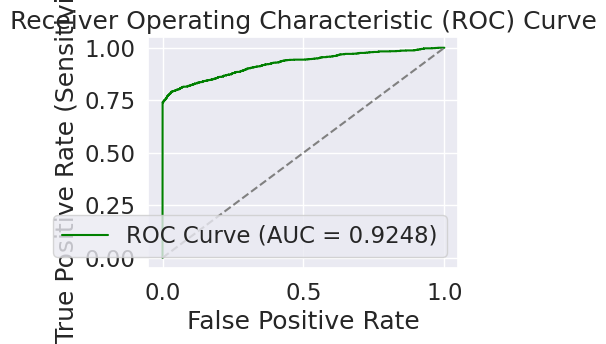

In [2688]:
roc(x_test_final,y_test,best_rf_model)

## XGBoost

### Handling Class Imbalance By Assigning Weights

In [ ]:
scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)

### Model Training & Evaluation

In [2682]:


xgb_model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight)

param_grid = {
    'max_depth': [1,2],
    'min_child_weight':[10,20],
    'reg_alpha':[50]

}


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


grid_search = GridSearchCV(estimator=xgb_model , param_grid=param_grid, cv=cv, n_jobs=-1, verbose=2)


#grid_search.fit(x_train, y_train)

grid_search.fit(x_train_final, y_train)


best_rf_model = grid_search.best_estimator_

# Evaluate the model on training and test sets


train_acc = best_rf_model.score(x_train_final, y_train)
test_acc = best_rf_model.score(x_test_final, y_test)

# Print out the results
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Training Accuracy: {train_acc}")
print(f"Test Accuracy: {test_acc}")

# Optionally, get more detailed classification metrics
y_pred_train = best_rf_model.predict(x_train_final)
y_pred_test = best_rf_model.predict(x_test_final)

print("Training Classification Report:")
print(classification_report(y_train, y_pred_train))

print("Test Classification Report:")
print(classification_report(y_test, y_pred_test))




Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Parameters: {'max_depth': 2, 'min_child_weight': 10, 'reg_alpha': 50}
Training Accuracy: 0.9621852823952561
Test Accuracy: 0.9569725246241576
Training Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     26329
           1       0.87      0.88      0.87      4532

    accuracy                           0.96     30861
   macro avg       0.92      0.93      0.92     30861
weighted avg       0.96      0.96      0.96     30861

Test Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      6621
           1       0.84      0.86      0.85      1095

    accuracy                           0.96      7716
   macro avg       0.91      0.92      0.91      7716
weighted avg       0.96      0.96      0.96      7716



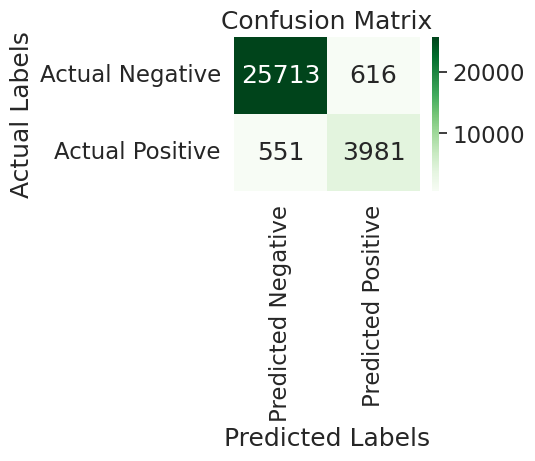

Precision: 0.8660
Recall (Sensitivity): 0.8784
F1 Score: 0.8721656260269471
Specificity: 0.9766


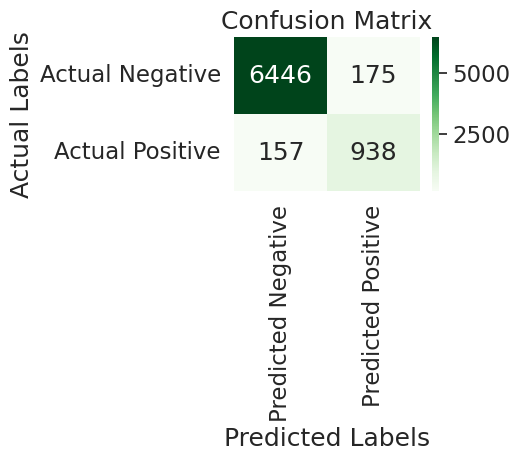

Precision: 0.8428
Recall (Sensitivity): 0.8566
F1 Score: 0.8496376811594204
Specificity: 0.9736


In [2683]:
print_confusion_matrix(x_train_final,y_train,best_rf_model)
print_confusion_matrix(x_test_final,y_test,best_rf_model)

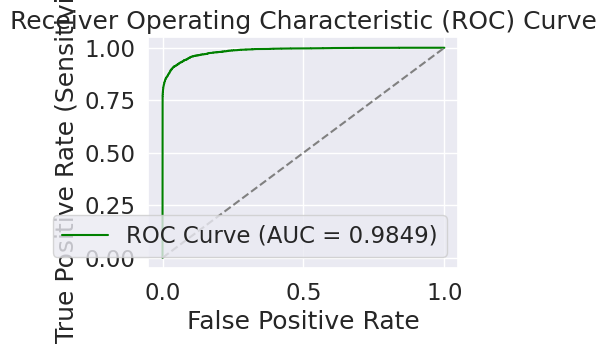

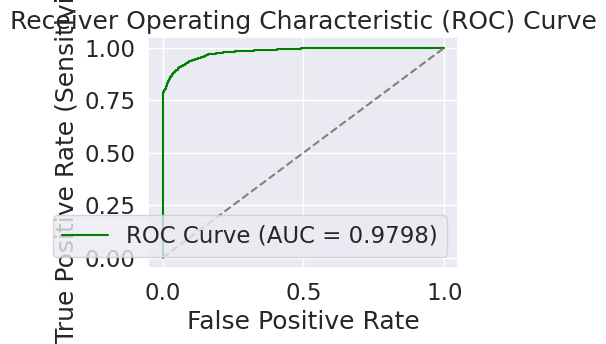

In [2684]:
# train roc
roc(x_train_final,y_train,best_rf_model)
# test roc
roc(x_test_final,y_test,best_rf_model)

# Conclusion

1. Higher charged off cases are observed for very high loan amounts. To reduce defaulter cases, the loan amounts are recommended to stay within 17K. Also, not all loans are funded by investors.

2. High interest rates on loans is also a driving factor leading to high charge off cases. To curb down defaulter cases, a reasonable interest rate roughly within 5.4% to 11% is recommended.

3. Charged Off applicants have slightly higher Debt to Income Ratio significantly higher Revolving Line Utilization indicating they rely too much on loans and consequently cannot pay the debts. Borrowers whose Debt Income Ratio cross 15 and Revolving Line Utilization cross 45 are risky and need to be treated with caution.

4. a) As loan grade increases, from A to G, the charge off rate also increases and the grades are influenced by interest rates. Applicants in small business are taking higher graded higher interest loans, making more inquiries in last 6 months requesting for more credits, struggling with credit repay than debt consolidation and consequently getting charged off more than other purpose categories (about 26%). Lower grade loans preferably grade A should be prioritised.

 b) While rejecting people taking loans for small business purpose as they had high charge off rates, it should be ensured that no opportunity is missed while rejecting a capable applicant with small business purpose from providing loan by taking care of the nuances. Criteria for applicants taking loans for small business purpose who should not be rejected from taking loans:

  - Credit score > 0.85
  - Revolving Line Utilization rate < 35
  - Annual Income group = VH (16000.00 to 35000.00)



5. Applicants with lower income charge off more.

6. Most applicants opt for short term (36 months) loans. Applicants with long term loans (60 months) were observed to have charged off more.

7. Charged Off borrowers have lower credit score than fully paid ones. Credit score below 0.8 should be treated with caution.

8. Borrowers whose employee titles are unknown have charged off more. So it is imperative to take information about the work title of the borrowers before providing loans.



9. Weak indicators:
Although weak indicators, following patterns are observed:

  a. Applicants with higher bankruptcy records have charged off more.

  b. Charged Off applicants have paid higher late fees than fully paid ones.


------------------------------------------------------------------------

Selected Model

* XGBoost : {'max_depth': 2, 'min_child_weight': 10, 'reg_alpha': 50}

* Train Accuracy: 0.9621852823952561

* Test Accuracy: 0.9569725246241576

Train Metrics

* Accuracy: 0.9621852823952561

* Precision: 0.8660

* Recall (Sensitivity): 0.8784

* F1 Score: 0.8721656260269471

* Specificity: 0.9766

* AUC: 0.9849


Test Metrics

* Accuracy: 0.9569725246241576

* Precision: 0.8428

* Recall (Sensitivity): 0.8566

* F1 Score: 0.8496376811594204

* Specificity: 0.9736

* AUC: 0.9798

